In [1]:
import matplotlib.pyplot as plt

import cv2
import numpy as np
import os
import PIL
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [3]:
data_dir =Path('../input/defect-detection')

In [4]:
data_dir

PosixPath('../input/defect-detection')

In [5]:
data_dir = Path(data_dir)
data_dir

PosixPath('../input/defect-detection')

In [6]:
list(data_dir.glob('*/*.bmp'))[:5]

[PosixPath('../input/defect-detection/shape_Defect/X21Y92_10035_16.bmp'),
 PosixPath('../input/defect-detection/shape_Defect/X3Y2_10035_16.bmp'),
 PosixPath('../input/defect-detection/shape_Defect/X23Y83_9792_12.bmp'),
 PosixPath('../input/defect-detection/shape_Defect/X29Y92_10035_16.bmp'),
 PosixPath('../input/defect-detection/shape_Defect/X6Y11_10035_16.bmp')]

In [7]:
image_count = len(list(data_dir.glob('*/*.bmp')))
print(image_count)

268


In [8]:
blurry = list(data_dir.glob('Blurry/*'))
blurry[:5]

[PosixPath('../input/defect-detection/Blurry/X38Y89_1.bmp'),
 PosixPath('../input/defect-detection/Blurry/X38Y89_1 .bmp'),
 PosixPath('../input/defect-detection/Blurry/X15Y2_1.bmp'),
 PosixPath('../input/defect-detection/Blurry/X15Y2_1 .bmp'),
 PosixPath('../input/defect-detection/Blurry/X36Y68_1 .bmp')]

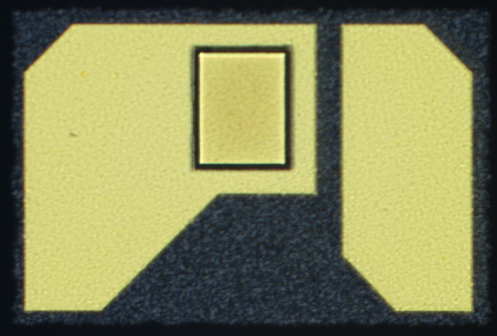

In [9]:
PIL.Image.open(str(blurry[1]))

Read Images from disk into numpy array with opencv

In [10]:
defect_images_dict = {
    'Blurry': list(data_dir.glob('Blurry/*')),
    'cracks': list(data_dir.glob('cracks/*')),
    'Good': list(data_dir.glob('Good/*')),
    'Hole': list(data_dir.glob('Hole/*')),
    'shape_Defect': list(data_dir.glob('shape_Defect/*')),
    'stains': list(data_dir.glob('stains/*')),
    'white_discolorization': list(data_dir.glob('white_discolorization/*')),
    'yellow_brown_discolor': list(data_dir.glob('yellow_brown_discolor/*')),
}

In [11]:
str(defect_images_dict['cracks'][1])

'../input/defect-detection/cracks/X2Y2_10035_16.bmp'

In [12]:
img = cv2.imread(str(defect_images_dict['Blurry'][0]))

In [13]:
img.shape

(336, 497, 3)

In [14]:
cv2.resize(img,(180,180)).shape

(180, 180, 3)

In [15]:
defect_labels_dict = {
    'Blurry': 0,
    'cracks': 1,
    'Good': 2,
    'Hole': 3,
    'shape_Defect': 4,
    'stains': 5,
    'white_discolorization': 6,
    'yellow_brown_discolor': 7,
}

In [22]:
X, y, class_names= [], [], []

for defect_name, images in defect_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(180,180))
        X.append(resized_img)
        y.append(defect_labels_dict[defect_name])
        class_names.append(defect_name)
        #print(defect_name)
#print(y)
#print(class_names)


In [17]:
X = np.array(X)
y = np.array(y)
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7]


Train or Test split

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Preprocessing: scale images

In [19]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

Build convolutional neural network and train it

In [23]:
num_classes = 8

model = Sequential([
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model.fit(X_train_scaled, y_train, epochs=30) 
print(model.summary())

Epoch 1/30


2022-12-07 13:11:53.042363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


7/7 [==============================] - 1s 89ms/step - loss: 2.5323 - accuracy: 0.1841
Epoch 2/30
7/7 [==============================] - 0s 60ms/step - loss: 1.9532 - accuracy: 0.2985
Epoch 3/30
7/7 [==============================] - 0s 59ms/step - loss: 1.8763 - accuracy: 0.2537
Epoch 4/30
7/7 [==============================] - 0s 60ms/step - loss: 1.8455 - accuracy: 0.2985
Epoch 5/30
7/7 [==============================] - 0s 58ms/step - loss: 1.8255 - accuracy: 0.2985
Epoch 6/30
7/7 [==============================] - 0s 63ms/step - loss: 1.7876 - accuracy: 0.3582
Epoch 7/30
7/7 [==============================] - 0s 58ms/step - loss: 1.7299 - accuracy: 0.3930
Epoch 8/30
7/7 [==============================] - 0s 63ms/step - loss: 1.6903 - accuracy: 0.3731
Epoch 9/30
7/7 [==============================] - 0s 60ms/step - loss: 1.6110 - accuracy: 0.4378
Epoch 10/30
7/7 [==============================] - 0s 61ms/step - loss: 1.5151 - accuracy: 0.4776
Epoch 11/30
7/7 [=======================

In [24]:
model.evaluate(X_test_scaled,y_test)
y_test

2022-12-07 13:12:45.680856: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 0s 57ms/step - loss: 1.4215 - accuracy: 0.5522


array([3, 7, 3, 3, 5, 5, 7, 2, 1, 0, 2, 7, 4, 2, 7, 5, 5, 4, 3, 5, 3, 6,
       5, 7, 3, 2, 4, 5, 5, 7, 0, 4, 2, 5, 7, 5, 4, 5, 1, 3, 5, 2, 5, 1,
       7, 3, 3, 4, 5, 0, 1, 7, 7, 1, 5, 5, 7, 5, 3, 7, 2, 2, 3, 7, 5, 7,
       5])

In [25]:
predictions = model.predict(X_test_scaled)
y_pred=np.round(abs(predictions))
y_pred
#print('accuracy of the algorithm is: {}'.format(accuracy_score(y_test, y_pred)))

3/3 [==============================] - 0s 48ms/step


2022-12-07 13:12:50.125490: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[ 3.,  0.,  2.,  2.,  2.,  5.,  1.,  2.],
       [ 2.,  0.,  4.,  2.,  1.,  3.,  2.,  3.],
       [ 2.,  0.,  3.,  2.,  0.,  3.,  1.,  2.],
       [ 1.,  1.,  2.,  2.,  0.,  1.,  1.,  0.],
       [ 2.,  0.,  3.,  3.,  1.,  4.,  2.,  4.],
       [ 1.,  0.,  4.,  2.,  0.,  5.,  1.,  2.],
       [ 2.,  0.,  3.,  2.,  0.,  3.,  2.,  3.],
       [ 3.,  1.,  1.,  2.,  0.,  4.,  2.,  3.],
       [ 2.,  3.,  3.,  2.,  1.,  1.,  1.,  1.],
       [ 2.,  0.,  2.,  0.,  2.,  2.,  1.,  0.],
       [ 0.,  1.,  6.,  2.,  4.,  1.,  2.,  1.],
       [ 0.,  1.,  1.,  1.,  0.,  0.,  1.,  1.],
       [ 1.,  1.,  4.,  1.,  0.,  4.,  1.,  2.],
       [ 1.,  0., 10.,  2.,  4.,  3.,  4.,  0.],
       [ 1.,  2.,  2.,  1.,  1.,  1.,  2.,  2.],
       [ 2.,  0.,  2.,  2.,  2.,  3.,  1.,  1.],
       [ 4.,  0.,  3.,  4.,  1.,  6.,  2.,  3.],
       [ 2.,  0.,  3.,  2.,  0.,  3.,  1.,  2.],
       [ 1.,  1.,  2.,  1.,  0.,  2.,  1.,  2.],
       [ 3.,  1.,  3.,  3.,  1.,  4.,  2.,  3.],
       [ 1.,  0.,  3

In [26]:
score = tf.nn.softmax(predictions[0])

In [29]:
pred=np.argmax(score)
print(pred)

5


In [28]:
y_test[0]

3

In [52]:
conf_matrix = metrics.confusion_matrix(y_test, y_pred)

ValueError: Classification metrics can't handle a mix of multiclass and multiclass-multioutput targets

In [30]:
test_im = Path("../input/defect-detection/cracks/X2Y2_10035_16.bmp")
#test_im2 = Path("../input/defect-detection/negative/X1Y92_9858_15.bmp")
#image_path = tf.keras.utils.get_file('test_image', origin=test_im)
img = tf.keras.preprocessing.image.load_img(
    test_im, target_size=(180,180)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(y_test[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 584ms/step
This image most likely belongs to 7 with a 100.00 percent confidence.


Improve test Accuracy Using data Augmentation

In [31]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(180, 
                                                              180,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

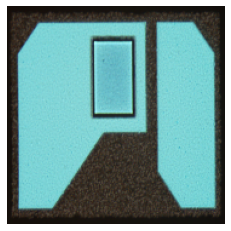

In [32]:
plt.axis('off')
plt.imshow(X[5])

ValueError: Layer "sequential_2" expects 1 input(s), but it received 268 input tensors. Inputs received: [<tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14,  9],
        [21, 13, 10],
        [19, 15,  8],
        ...,
        [16, 11, 11],
        [15, 12, 10],
        [15, 12,  9]],

       [[19, 15,  9],
        [20, 14, 10],
        [20, 14, 10],
        ...,
        [15, 13, 10],
        [16, 13,  9],
        [17, 12,  8]],

       [[21, 14, 10],
        [20, 14,  9],
        [20, 13,  9],
        ...,
        [16, 12, 11],
        [16, 12,  8],
        [15, 13, 11]],

       ...,

       [[22, 16, 10],
        [19, 18, 11],
        [18, 16, 11],
        ...,
        [16, 15, 11],
        [16, 16, 12],
        [17, 15, 12]],

       [[21, 16, 11],
        [21, 16, 10],
        [22, 14, 12],
        ...,
        [16, 15, 12],
        [18, 15, 11],
        [17, 14, 13]],

       [[22, 15, 12],
        [21, 17, 10],
        [20, 15, 12],
        ...,
        [17, 15, 11],
        [18, 14, 11],
        [16, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14,  9],
        [21, 13, 10],
        [19, 15,  8],
        ...,
        [16, 11, 11],
        [15, 12, 10],
        [15, 12,  9]],

       [[19, 15,  9],
        [20, 14, 10],
        [20, 14, 10],
        ...,
        [15, 13, 10],
        [16, 13,  9],
        [17, 12,  8]],

       [[21, 14, 10],
        [20, 14,  9],
        [20, 13,  9],
        ...,
        [16, 12, 11],
        [16, 12,  8],
        [15, 13, 11]],

       ...,

       [[22, 16, 10],
        [19, 18, 11],
        [18, 16, 11],
        ...,
        [16, 15, 11],
        [16, 16, 12],
        [17, 15, 12]],

       [[21, 16, 11],
        [21, 16, 10],
        [22, 14, 12],
        ...,
        [16, 15, 12],
        [18, 15, 11],
        [17, 14, 13]],

       [[22, 15, 12],
        [21, 17, 10],
        [20, 15, 12],
        ...,
        [17, 15, 11],
        [18, 14, 11],
        [16, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14,  9],
        [20, 14,  9],
        [21, 15, 11],
        ...,
        [17, 15, 12],
        [16, 15, 13],
        [17, 15, 13]],

       [[21, 15, 10],
        [22, 14, 10],
        [20, 14, 10],
        ...,
        [17, 15, 12],
        [17, 15, 13],
        [16, 16, 12]],

       [[22, 15, 11],
        [21, 15,  9],
        [20, 14, 10],
        ...,
        [17, 16, 12],
        [17, 15, 13],
        [18, 15, 13]],

       ...,

       [[22, 16, 12],
        [20, 16, 11],
        [20, 16, 11],
        ...,
        [17, 14, 10],
        [18, 14, 11],
        [18, 14, 12]],

       [[20, 17, 12],
        [21, 16, 12],
        [21, 16, 10],
        ...,
        [18, 13, 11],
        [17, 14, 10],
        [18, 14, 12]],

       [[21, 16, 11],
        [21, 16, 11],
        [22, 16, 11],
        ...,
        [17, 14, 10],
        [17, 14, 10],
        [18, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14,  9],
        [20, 14,  9],
        [21, 15, 11],
        ...,
        [17, 15, 12],
        [16, 15, 13],
        [17, 15, 13]],

       [[21, 15, 10],
        [22, 14, 10],
        [20, 14, 10],
        ...,
        [17, 15, 12],
        [17, 15, 13],
        [16, 16, 12]],

       [[22, 15, 11],
        [21, 15,  9],
        [20, 14, 10],
        ...,
        [17, 16, 12],
        [17, 15, 13],
        [18, 15, 13]],

       ...,

       [[22, 16, 12],
        [20, 16, 11],
        [20, 16, 11],
        ...,
        [17, 14, 10],
        [18, 14, 11],
        [18, 14, 12]],

       [[20, 17, 12],
        [21, 16, 12],
        [21, 16, 10],
        ...,
        [18, 13, 11],
        [17, 14, 10],
        [18, 14, 12]],

       [[21, 16, 11],
        [21, 16, 11],
        [22, 16, 11],
        ...,
        [17, 14, 10],
        [17, 14, 10],
        [18, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14, 10],
        [20, 14,  8],
        [19, 13, 10],
        ...,
        [15, 13,  9],
        [14, 13,  9],
        [15, 12, 10]],

       [[20, 14, 10],
        [19, 14,  9],
        [19, 14,  9],
        ...,
        [15, 13, 11],
        [15, 14, 10],
        [14, 12, 10]],

       [[21, 15,  9],
        [21, 14, 11],
        [20, 14,  8],
        ...,
        [16, 13, 10],
        [16, 13,  9],
        [16, 13,  9]],

       ...,

       [[23, 17, 12],
        [23, 20, 15],
        [25, 23, 19],
        ...,
        [16, 14, 11],
        [17, 13, 11],
        [15, 14, 12]],

       [[22, 17, 12],
        [24, 19, 13],
        [23, 21, 17],
        ...,
        [15, 15, 10],
        [16, 13, 11],
        [15, 14, 10]],

       [[20, 17, 13],
        [23, 18, 12],
        [23, 20, 15],
        ...,
        [17, 14, 11],
        [16, 14, 11],
        [16, 13, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 13,  8],
        [21, 13, 10],
        [21, 14,  9],
        ...,
        [16, 14, 10],
        [16, 14, 10],
        [15, 15, 11]],

       [[20, 14, 10],
        [21, 14,  8],
        [19, 14,  9],
        ...,
        [18, 13, 10],
        [16, 15, 10],
        [15, 15, 11]],

       [[17, 16,  9],
        [20, 14,  9],
        [22, 13, 10],
        ...,
        [17, 14, 10],
        [15, 16, 10],
        [18, 14, 10]],

       ...,

       [[23, 15,  9],
        [22, 15, 10],
        [20, 16, 12],
        ...,
        [17, 15, 12],
        [17, 15, 10],
        [17, 15, 12]],

       [[20, 15, 12],
        [21, 15, 10],
        [21, 16, 10],
        ...,
        [17, 16, 12],
        [17, 15, 11],
        [17, 14, 13]],

       [[21, 15, 11],
        [20, 16, 10],
        [20, 16, 10],
        ...,
        [17, 15, 12],
        [17, 16, 12],
        [17, 15, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 15, 11],
        [21, 14, 10],
        [21, 14, 11],
        ...,
        [14, 15, 10],
        [16, 13, 10],
        [16, 15, 10]],

       [[19, 15, 12],
        [21, 14, 11],
        [20, 15, 11],
        ...,
        [15, 15, 11],
        [15, 14, 11],
        [16, 15, 11]],

       [[22, 15,  9],
        [21, 15,  7],
        [20, 15, 10],
        ...,
        [17, 14, 11],
        [16, 13, 11],
        [14, 14, 12]],

       ...,

       [[20, 15, 11],
        [20, 14, 11],
        [20, 15,  9],
        ...,
        [18, 12,  7],
        [16, 11,  8],
        [17, 12,  8]],

       [[22, 14, 10],
        [22, 14, 10],
        [21, 15, 10],
        ...,
        [16, 12,  8],
        [17, 11,  8],
        [17, 12,  7]],

       [[21, 14,  9],
        [21, 15, 10],
        [22, 14,  9],
        ...,
        [17, 11,  8],
        [15, 13,  7],
        [15, 13,  8]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 14, 10],
        [19, 13,  7],
        [20, 13, 11],
        ...,
        [14, 11,  9],
        [14, 11,  8],
        [14, 10,  8]],

       [[19, 13, 10],
        [20, 14,  8],
        [20, 13, 10],
        ...,
        [13, 11,  8],
        [15, 11,  7],
        [16, 12, 10]],

       [[19, 14, 10],
        [20, 14,  9],
        [20, 14,  9],
        ...,
        [14, 11,  9],
        [14, 12, 10],
        [16, 13, 10]],

       ...,

       [[21, 15, 11],
        [22, 15, 13],
        [22, 15, 12],
        ...,
        [18, 13, 11],
        [18, 13, 10],
        [17, 13, 11]],

       [[22, 16, 11],
        [21, 15, 11],
        [21, 15, 12],
        ...,
        [15, 14,  9],
        [17, 15, 10],
        [17, 13, 10]],

       [[21, 16,  9],
        [23, 15, 12],
        [21, 16, 11],
        ...,
        [17, 14, 10],
        [16, 14, 11],
        [16, 14,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 14, 10],
        [19, 13,  7],
        [20, 13, 11],
        ...,
        [14, 11,  9],
        [14, 11,  8],
        [14, 10,  8]],

       [[19, 13, 10],
        [20, 14,  8],
        [20, 13, 10],
        ...,
        [13, 11,  8],
        [15, 11,  7],
        [16, 12, 10]],

       [[19, 14, 10],
        [20, 14,  9],
        [20, 14,  9],
        ...,
        [14, 11,  9],
        [14, 12, 10],
        [16, 13, 10]],

       ...,

       [[21, 15, 11],
        [22, 15, 13],
        [22, 15, 12],
        ...,
        [18, 13, 11],
        [18, 13, 10],
        [17, 13, 11]],

       [[22, 16, 11],
        [21, 15, 11],
        [21, 15, 12],
        ...,
        [15, 14,  9],
        [17, 15, 10],
        [17, 13, 10]],

       [[21, 16,  9],
        [23, 15, 12],
        [21, 16, 11],
        ...,
        [17, 14, 10],
        [16, 14, 11],
        [16, 14,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14, 10],
        [20, 14,  8],
        [19, 13, 10],
        ...,
        [15, 13,  9],
        [14, 13,  9],
        [15, 12, 10]],

       [[20, 14, 10],
        [19, 14,  9],
        [19, 14,  9],
        ...,
        [15, 13, 11],
        [15, 14, 10],
        [14, 12, 10]],

       [[21, 15,  9],
        [21, 14, 11],
        [20, 14,  8],
        ...,
        [16, 13, 10],
        [16, 13,  9],
        [16, 13,  9]],

       ...,

       [[23, 17, 12],
        [23, 20, 15],
        [25, 23, 19],
        ...,
        [16, 14, 11],
        [17, 13, 11],
        [15, 14, 12]],

       [[22, 17, 12],
        [24, 19, 13],
        [23, 21, 17],
        ...,
        [15, 15, 10],
        [16, 13, 11],
        [15, 14, 10]],

       [[20, 17, 13],
        [23, 18, 12],
        [23, 20, 15],
        ...,
        [17, 14, 11],
        [16, 14, 11],
        [16, 13, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 13,  8],
        [21, 13, 10],
        [21, 14,  9],
        ...,
        [16, 14, 10],
        [16, 14, 10],
        [15, 15, 11]],

       [[20, 14, 10],
        [21, 14,  8],
        [19, 14,  9],
        ...,
        [18, 13, 10],
        [16, 15, 10],
        [15, 15, 11]],

       [[17, 16,  9],
        [20, 14,  9],
        [22, 13, 10],
        ...,
        [17, 14, 10],
        [15, 16, 10],
        [18, 14, 10]],

       ...,

       [[23, 15,  9],
        [22, 15, 10],
        [20, 16, 12],
        ...,
        [17, 15, 12],
        [17, 15, 10],
        [17, 15, 12]],

       [[20, 15, 12],
        [21, 15, 10],
        [21, 16, 10],
        ...,
        [17, 16, 12],
        [17, 15, 11],
        [17, 14, 13]],

       [[21, 15, 11],
        [20, 16, 10],
        [20, 16, 10],
        ...,
        [17, 15, 12],
        [17, 16, 12],
        [17, 15, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 15, 11],
        [21, 14, 10],
        [21, 14, 11],
        ...,
        [14, 15, 10],
        [16, 13, 10],
        [16, 15, 10]],

       [[19, 15, 12],
        [21, 14, 11],
        [20, 15, 11],
        ...,
        [15, 15, 11],
        [15, 14, 11],
        [16, 15, 11]],

       [[22, 15,  9],
        [21, 15,  7],
        [20, 15, 10],
        ...,
        [17, 14, 11],
        [16, 13, 11],
        [14, 14, 12]],

       ...,

       [[20, 15, 11],
        [20, 14, 11],
        [20, 15,  9],
        ...,
        [18, 12,  7],
        [16, 11,  8],
        [17, 12,  8]],

       [[22, 14, 10],
        [22, 14, 10],
        [21, 15, 10],
        ...,
        [16, 12,  8],
        [17, 11,  8],
        [17, 12,  7]],

       [[21, 14,  9],
        [21, 15, 10],
        [22, 14,  9],
        ...,
        [17, 11,  8],
        [15, 13,  7],
        [15, 13,  8]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14, 10],
        [19, 14,  8],
        [21, 14,  8],
        ...,
        [14, 12, 13],
        [14, 13, 12],
        [15, 15, 10]],

       [[23, 15, 11],
        [20, 14, 10],
        [20, 14,  9],
        ...,
        [14, 14, 10],
        [14, 14, 12],
        [15, 15, 12]],

       [[23, 15, 10],
        [21, 14, 10],
        [21, 14,  8],
        ...,
        [14, 15, 13],
        [14, 14, 14],
        [14, 15, 11]],

       ...,

       [[20, 15, 11],
        [19, 15,  9],
        [20, 14, 11],
        ...,
        [14, 11, 12],
        [15, 13, 10],
        [12, 13, 10]],

       [[21, 14, 10],
        [20, 15,  9],
        [19, 15, 11],
        ...,
        [14, 12,  8],
        [13, 12, 12],
        [13, 14, 10]],

       [[19, 15, 11],
        [20, 15,  9],
        [19, 14, 10],
        ...,
        [12, 13, 10],
        [13, 12, 10],
        [15, 12, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 14,  9],
        [22, 14,  9],
        [20, 14, 10],
        ...,
        [16, 16, 13],
        [18, 16, 13],
        [16, 16, 14]],

       [[21, 14, 11],
        [21, 13, 10],
        [21, 14, 10],
        ...,
        [18, 16, 15],
        [17, 16, 13],
        [17, 16, 13]],

       [[20, 15, 10],
        [20, 16,  9],
        [21, 15,  9],
        ...,
        [18, 17, 13],
        [17, 17, 12],
        [16, 16, 16]],

       ...,

       [[21, 16, 13],
        [21, 15, 10],
        [23, 15, 11],
        ...,
        [17, 15, 10],
        [15, 15,  9],
        [18, 15, 10]],

       [[22, 16,  9],
        [22, 15, 10],
        [23, 15, 10],
        ...,
        [17, 14, 10],
        [20, 13, 11],
        [18, 14, 10]],

       [[21, 16, 10],
        [20, 16,  9],
        [20, 16, 11],
        ...,
        [18, 14, 10],
        [18, 15, 10],
        [18, 14, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 15, 10],
        [21, 14, 11],
        [21, 14,  9],
        ...,
        [17, 16, 13],
        [17, 15, 13],
        [18, 14, 12]],

       [[22, 14, 10],
        [22, 15,  9],
        [21, 14, 10],
        ...,
        [17, 16, 13],
        [17, 15, 13],
        [19, 15, 12]],

       [[22, 16,  9],
        [21, 15,  9],
        [20, 15, 10],
        ...,
        [18, 15, 12],
        [16, 16, 13],
        [17, 15, 13]],

       ...,

       [[22, 16,  9],
        [22, 15, 11],
        [22, 15, 10],
        ...,
        [18, 14, 10],
        [18, 15, 11],
        [19, 15, 10]],

       [[19, 17, 10],
        [22, 15, 10],
        [21, 15, 11],
        ...,
        [18, 14, 10],
        [20, 15, 11],
        [20, 16,  9]],

       [[21, 15,  9],
        [23, 15, 10],
        [20, 15,  9],
        ...,
        [17, 14, 11],
        [18, 14, 11],
        [19, 14, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14,  9],
        [21, 14,  9],
        [20, 14, 10],
        ...,
        [14, 13, 11],
        [14, 14, 11],
        [15, 14, 10]],

       [[20, 14,  9],
        [20, 14,  9],
        [21, 14,  9],
        ...,
        [16, 13, 11],
        [15, 14, 10],
        [14, 14, 10]],

       [[22, 13,  9],
        [20, 14, 11],
        [21, 14,  9],
        ...,
        [16, 13, 12],
        [15, 14, 11],
        [15, 13, 11]],

       ...,

       [[22, 16, 12],
        [22, 15, 11],
        [20, 16, 11],
        ...,
        [16, 15, 12],
        [16, 14, 12],
        [17, 15, 12]],

       [[21, 17, 10],
        [22, 16, 11],
        [21, 16,  9],
        ...,
        [16, 15, 12],
        [18, 14, 11],
        [17, 15, 13]],

       [[21, 16, 10],
        [21, 15, 11],
        [21, 16, 10],
        ...,
        [16, 14, 12],
        [17, 14, 12],
        [17, 14, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14,  9],
        [21, 14,  9],
        [20, 14, 10],
        ...,
        [14, 13, 11],
        [14, 14, 11],
        [15, 14, 10]],

       [[20, 14,  9],
        [20, 14,  9],
        [21, 14,  9],
        ...,
        [16, 13, 11],
        [15, 14, 10],
        [14, 14, 10]],

       [[22, 13,  9],
        [20, 14, 11],
        [21, 14,  9],
        ...,
        [16, 13, 12],
        [15, 14, 11],
        [15, 13, 11]],

       ...,

       [[22, 16, 12],
        [22, 15, 11],
        [20, 16, 11],
        ...,
        [16, 15, 12],
        [16, 14, 12],
        [17, 15, 12]],

       [[21, 17, 10],
        [22, 16, 11],
        [21, 16,  9],
        ...,
        [16, 15, 12],
        [18, 14, 11],
        [17, 15, 13]],

       [[21, 16, 10],
        [21, 15, 11],
        [21, 16, 10],
        ...,
        [16, 14, 12],
        [17, 14, 12],
        [17, 14, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14, 10],
        [19, 14,  8],
        [21, 14,  8],
        ...,
        [14, 12, 13],
        [14, 13, 12],
        [15, 15, 10]],

       [[23, 15, 11],
        [20, 14, 10],
        [20, 14,  9],
        ...,
        [14, 14, 10],
        [14, 14, 12],
        [15, 15, 12]],

       [[23, 15, 10],
        [21, 14, 10],
        [21, 14,  8],
        ...,
        [14, 15, 13],
        [14, 14, 14],
        [14, 15, 11]],

       ...,

       [[20, 15, 11],
        [19, 15,  9],
        [20, 14, 11],
        ...,
        [14, 11, 12],
        [15, 13, 10],
        [12, 13, 10]],

       [[21, 14, 10],
        [20, 15,  9],
        [19, 15, 11],
        ...,
        [14, 12,  8],
        [13, 12, 12],
        [13, 14, 10]],

       [[19, 15, 11],
        [20, 15,  9],
        [19, 14, 10],
        ...,
        [12, 13, 10],
        [13, 12, 10],
        [15, 12, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14,  9],
        [21, 14,  9],
        [20, 14, 10],
        ...,
        [14, 13, 11],
        [14, 14, 11],
        [15, 14, 10]],

       [[20, 14,  9],
        [20, 14,  9],
        [21, 14,  9],
        ...,
        [16, 13, 11],
        [15, 14, 10],
        [14, 14, 10]],

       [[22, 13,  9],
        [20, 14, 11],
        [21, 14,  9],
        ...,
        [16, 13, 12],
        [15, 14, 11],
        [15, 13, 11]],

       ...,

       [[22, 16, 12],
        [22, 15, 11],
        [20, 16, 11],
        ...,
        [16, 15, 12],
        [16, 14, 12],
        [17, 15, 12]],

       [[21, 17, 10],
        [22, 16, 11],
        [21, 16,  9],
        ...,
        [16, 15, 12],
        [18, 14, 11],
        [17, 15, 13]],

       [[21, 16, 10],
        [21, 15, 11],
        [21, 16, 10],
        ...,
        [16, 14, 12],
        [17, 14, 12],
        [17, 14, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 13, 10],
        [21, 14,  9],
        [20, 13,  9],
        ...,
        [17, 14, 12],
        [16, 14, 11],
        [15, 14, 11]],

       [[21, 13, 11],
        [21, 13,  8],
        [21, 13,  9],
        ...,
        [16, 15, 12],
        [17, 14, 11],
        [15, 15, 10]],

       [[21, 14, 10],
        [21, 14, 10],
        [22, 16, 11],
        ...,
        [18, 15, 13],
        [19, 16, 14],
        [16, 16, 13]],

       ...,

       [[21, 14,  9],
        [20, 16,  9],
        [22, 15,  8],
        ...,
        [17, 15, 11],
        [15, 15, 11],
        [17, 14, 11]],

       [[21, 14, 11],
        [21, 15, 10],
        [22, 15,  9],
        ...,
        [16, 14, 11],
        [17, 15, 10],
        [16, 15, 13]],

       [[20, 15, 11],
        [21, 15, 11],
        [19, 15,  9],
        ...,
        [18, 14, 11],
        [17, 14, 11],
        [16, 15, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 13, 10],
        [21, 14,  9],
        [20, 13,  9],
        ...,
        [17, 14, 12],
        [16, 14, 11],
        [15, 14, 11]],

       [[21, 13, 11],
        [21, 13,  8],
        [21, 13,  9],
        ...,
        [16, 15, 12],
        [17, 14, 11],
        [15, 15, 10]],

       [[21, 14, 10],
        [21, 14, 10],
        [22, 16, 11],
        ...,
        [18, 15, 13],
        [19, 16, 14],
        [16, 16, 13]],

       ...,

       [[21, 14,  9],
        [20, 16,  9],
        [22, 15,  8],
        ...,
        [17, 15, 11],
        [15, 15, 11],
        [17, 14, 11]],

       [[21, 14, 11],
        [21, 15, 10],
        [22, 15,  9],
        ...,
        [16, 14, 11],
        [17, 15, 10],
        [16, 15, 13]],

       [[20, 15, 11],
        [21, 15, 11],
        [19, 15,  9],
        ...,
        [18, 14, 11],
        [17, 14, 11],
        [16, 15, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 14,  9],
        [22, 14,  9],
        [20, 14, 10],
        ...,
        [16, 16, 13],
        [18, 16, 13],
        [16, 16, 14]],

       [[21, 14, 11],
        [21, 13, 10],
        [21, 14, 10],
        ...,
        [18, 16, 15],
        [17, 16, 13],
        [17, 16, 13]],

       [[20, 15, 10],
        [20, 16,  9],
        [21, 15,  9],
        ...,
        [18, 17, 13],
        [17, 17, 12],
        [16, 16, 16]],

       ...,

       [[21, 16, 13],
        [21, 15, 10],
        [23, 15, 11],
        ...,
        [17, 15, 10],
        [15, 15,  9],
        [18, 15, 10]],

       [[22, 16,  9],
        [22, 15, 10],
        [23, 15, 10],
        ...,
        [17, 14, 10],
        [20, 13, 11],
        [18, 14, 10]],

       [[21, 16, 10],
        [20, 16,  9],
        [20, 16, 11],
        ...,
        [18, 14, 10],
        [18, 15, 10],
        [18, 14, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 14,  9],
        [22, 14,  9],
        [20, 14, 10],
        ...,
        [16, 16, 13],
        [18, 16, 13],
        [16, 16, 14]],

       [[21, 14, 11],
        [21, 13, 10],
        [21, 14, 10],
        ...,
        [18, 16, 15],
        [17, 16, 13],
        [17, 16, 13]],

       [[20, 15, 10],
        [20, 16,  9],
        [21, 15,  9],
        ...,
        [18, 17, 13],
        [17, 17, 12],
        [16, 16, 16]],

       ...,

       [[21, 16, 13],
        [21, 15, 10],
        [23, 15, 11],
        ...,
        [17, 15, 10],
        [15, 15,  9],
        [18, 15, 10]],

       [[22, 16,  9],
        [22, 15, 10],
        [23, 15, 10],
        ...,
        [17, 14, 10],
        [20, 13, 11],
        [18, 14, 10]],

       [[21, 16, 10],
        [20, 16,  9],
        [20, 16, 11],
        ...,
        [18, 14, 10],
        [18, 15, 10],
        [18, 14, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 15, 10],
        [21, 14, 11],
        [21, 14,  9],
        ...,
        [17, 16, 13],
        [17, 15, 13],
        [18, 14, 12]],

       [[22, 14, 10],
        [22, 15,  9],
        [21, 14, 10],
        ...,
        [17, 16, 13],
        [17, 15, 13],
        [19, 15, 12]],

       [[22, 16,  9],
        [21, 15,  9],
        [20, 15, 10],
        ...,
        [18, 15, 12],
        [16, 16, 13],
        [17, 15, 13]],

       ...,

       [[22, 16,  9],
        [22, 15, 11],
        [22, 15, 10],
        ...,
        [18, 14, 10],
        [18, 15, 11],
        [19, 15, 10]],

       [[19, 17, 10],
        [22, 15, 10],
        [21, 15, 11],
        ...,
        [18, 14, 10],
        [20, 15, 11],
        [20, 16,  9]],

       [[21, 15,  9],
        [23, 15, 10],
        [20, 15,  9],
        ...,
        [17, 14, 11],
        [18, 14, 11],
        [19, 14, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14,  9],
        [20, 13, 10],
        [20, 13, 10],
        ...,
        [16, 13, 11],
        [16, 14, 12],
        [16, 14, 10]],

       [[19, 13, 11],
        [21, 14,  9],
        [21, 13,  8],
        ...,
        [16, 15, 11],
        [17, 14, 11],
        [16, 13,  9]],

       [[21, 13, 12],
        [19, 14, 10],
        [20, 14,  9],
        ...,
        [17, 14, 11],
        [17, 13, 11],
        [18, 15, 10]],

       ...,

       [[21, 17,  9],
        [20, 16,  8],
        [21, 15, 11],
        ...,
        [17, 15, 11],
        [17, 14, 14],
        [16, 15, 12]],

       [[21, 15, 10],
        [21, 15, 11],
        [21, 16, 10],
        ...,
        [16, 15, 12],
        [17, 15, 12],
        [17, 14, 11]],

       [[22, 16, 10],
        [20, 16, 10],
        [19, 16, 11],
        ...,
        [18, 15, 11],
        [18, 14, 12],
        [16, 15, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14, 10],
        [19, 14,  8],
        [21, 14,  8],
        ...,
        [14, 12, 13],
        [14, 13, 12],
        [15, 15, 10]],

       [[23, 15, 11],
        [20, 14, 10],
        [20, 14,  9],
        ...,
        [14, 14, 10],
        [14, 14, 12],
        [15, 15, 12]],

       [[23, 15, 10],
        [21, 14, 10],
        [21, 14,  8],
        ...,
        [14, 15, 13],
        [14, 14, 14],
        [14, 15, 11]],

       ...,

       [[20, 15, 11],
        [19, 15,  9],
        [20, 14, 11],
        ...,
        [14, 11, 12],
        [15, 13, 10],
        [12, 13, 10]],

       [[21, 14, 10],
        [20, 15,  9],
        [19, 15, 11],
        ...,
        [14, 12,  8],
        [13, 12, 12],
        [13, 14, 10]],

       [[19, 15, 11],
        [20, 15,  9],
        [19, 14, 10],
        ...,
        [12, 13, 10],
        [13, 12, 10],
        [15, 12, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 15, 10],
        [21, 14, 11],
        [21, 14,  9],
        ...,
        [17, 16, 13],
        [17, 15, 13],
        [18, 14, 12]],

       [[22, 14, 10],
        [22, 15,  9],
        [21, 14, 10],
        ...,
        [17, 16, 13],
        [17, 15, 13],
        [19, 15, 12]],

       [[22, 16,  9],
        [21, 15,  9],
        [20, 15, 10],
        ...,
        [18, 15, 12],
        [16, 16, 13],
        [17, 15, 13]],

       ...,

       [[22, 16,  9],
        [22, 15, 11],
        [22, 15, 10],
        ...,
        [18, 14, 10],
        [18, 15, 11],
        [19, 15, 10]],

       [[19, 17, 10],
        [22, 15, 10],
        [21, 15, 11],
        ...,
        [18, 14, 10],
        [20, 15, 11],
        [20, 16,  9]],

       [[21, 15,  9],
        [23, 15, 10],
        [20, 15,  9],
        ...,
        [17, 14, 11],
        [18, 14, 11],
        [19, 14, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 13, 10],
        [21, 14,  9],
        [20, 13,  9],
        ...,
        [17, 14, 12],
        [16, 14, 11],
        [15, 14, 11]],

       [[21, 13, 11],
        [21, 13,  8],
        [21, 13,  9],
        ...,
        [16, 15, 12],
        [17, 14, 11],
        [15, 15, 10]],

       [[21, 14, 10],
        [21, 14, 10],
        [22, 16, 11],
        ...,
        [18, 15, 13],
        [19, 16, 14],
        [16, 16, 13]],

       ...,

       [[21, 14,  9],
        [20, 16,  9],
        [22, 15,  8],
        ...,
        [17, 15, 11],
        [15, 15, 11],
        [17, 14, 11]],

       [[21, 14, 11],
        [21, 15, 10],
        [22, 15,  9],
        ...,
        [16, 14, 11],
        [17, 15, 10],
        [16, 15, 13]],

       [[20, 15, 11],
        [21, 15, 11],
        [19, 15,  9],
        ...,
        [18, 14, 11],
        [17, 14, 11],
        [16, 15, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 13, 10],
        [20, 14, 10],
        [19, 15,  9],
        ...,
        [14, 12, 10],
        [14, 12, 10],
        [13, 12,  9]],

       [[20, 15, 10],
        [20, 14,  9],
        [22, 13,  9],
        ...,
        [16, 12, 10],
        [13, 13,  9],
        [14, 12,  9]],

       [[23, 14, 11],
        [21, 14,  9],
        [19, 15,  9],
        ...,
        [14, 13, 10],
        [14, 12, 11],
        [15, 12, 10]],

       ...,

       [[20, 16, 11],
        [22, 16, 11],
        [22, 15, 12],
        ...,
        [16, 14, 11],
        [17, 13, 11],
        [15, 13, 12]],

       [[21, 16, 11],
        [21, 16, 11],
        [21, 15, 10],
        ...,
        [17, 13, 10],
        [16, 13, 12],
        [17, 13, 10]],

       [[22, 15, 11],
        [21, 16, 12],
        [21, 16,  9],
        ...,
        [16, 13, 11],
        [15, 13, 10],
        [16, 13, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15, 10],
        [21, 14, 10],
        [21, 14, 10],
        ...,
        [16, 16, 13],
        [17, 15, 13],
        [16, 16, 13]],

       [[20, 15, 11],
        [21, 15, 10],
        [20, 14, 11],
        ...,
        [17, 16, 13],
        [17, 16, 13],
        [16, 16, 12]],

       [[21, 14, 11],
        [20, 14, 11],
        [20, 14, 10],
        ...,
        [19, 17, 13],
        [20, 16, 15],
        [18, 16, 12]],

       ...,

       [[21, 14, 12],
        [22, 16, 10],
        [21, 16, 10],
        ...,
        [17, 13, 11],
        [19, 15, 10],
        [18, 14, 13]],

       [[22, 15, 11],
        [21, 16,  9],
        [22, 15, 10],
        ...,
        [16, 14,  9],
        [20, 13, 12],
        [18, 14, 10]],

       [[22, 15, 13],
        [20, 16, 11],
        [19, 16, 10],
        ...,
        [16, 15, 10],
        [16, 15, 10],
        [17, 13, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 15, 11],
        [22, 15, 13],
        [22, 15, 11],
        ...,
        [15, 13, 11],
        [15, 14, 10],
        [17, 13, 12]],

       [[20, 17, 10],
        [22, 15, 12],
        [22, 15, 11],
        ...,
        [14, 15,  9],
        [16, 14, 12],
        [16, 13, 12]],

       [[19, 17, 12],
        [23, 14, 11],
        [21, 15, 10],
        ...,
        [17, 15, 11],
        [15, 14, 10],
        [15, 14, 11]],

       ...,

       [[20, 17, 11],
        [22, 16, 11],
        [20, 16, 10],
        ...,
        [16, 13,  8],
        [17, 13,  9],
        [16, 14,  9]],

       [[21, 17,  9],
        [20, 16, 11],
        [21, 16, 11],
        ...,
        [15, 13,  8],
        [18, 13, 10],
        [17, 12, 10]],

       [[21, 16, 10],
        [21, 16, 10],
        [21, 15, 12],
        ...,
        [17, 13, 10],
        [16, 14,  9],
        [16, 12, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14,  9],
        [21, 13,  9],
        [20, 14,  9],
        ...,
        [17, 14, 10],
        [18, 14, 12],
        [19, 14, 12]],

       [[21, 15, 10],
        [21, 14, 10],
        [19, 14, 11],
        ...,
        [17, 15, 13],
        [16, 15, 11],
        [18, 14, 12]],

       [[19, 14, 10],
        [18, 14, 12],
        [19, 14,  9],
        ...,
        [18, 15, 12],
        [16, 15, 14],
        [13, 17, 11]],

       ...,

       [[22, 16, 11],
        [22, 15, 11],
        [21, 15, 11],
        ...,
        [16, 14, 14],
        [18, 14, 11],
        [17, 14, 12]],

       [[20, 15, 11],
        [20, 16,  8],
        [20, 16,  9],
        ...,
        [16, 14, 13],
        [19, 14, 11],
        [16, 15, 10]],

       [[21, 15, 12],
        [22, 15, 11],
        [21, 14, 10],
        ...,
        [17, 15, 11],
        [17, 14, 11],
        [17, 14, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 14, 10],
        [20, 15, 10],
        [20, 14, 11],
        ...,
        [18, 15, 12],
        [17, 16, 13],
        [18, 15, 13]],

       [[21, 15,  9],
        [21, 14, 10],
        [21, 14,  9],
        ...,
        [17, 16, 11],
        [18, 15, 12],
        [18, 14, 13]],

       [[22, 14,  9],
        [20, 15, 10],
        [20, 15, 10],
        ...,
        [16, 16, 14],
        [17, 16, 12],
        [17, 16, 13]],

       ...,

       [[20, 15, 12],
        [21, 16,  9],
        [21, 17, 10],
        ...,
        [17, 15, 10],
        [17, 13, 11],
        [17, 14, 10]],

       [[18, 17, 10],
        [21, 15, 10],
        [20, 15, 12],
        ...,
        [17, 13, 13],
        [18, 14, 11],
        [19, 13, 10]],

       [[21, 15, 11],
        [20, 17,  8],
        [21, 15, 10],
        ...,
        [17, 14, 10],
        [16, 14, 10],
        [15, 14, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 13, 10],
        [20, 14, 10],
        [19, 15,  9],
        ...,
        [14, 12, 10],
        [14, 12, 10],
        [13, 12,  9]],

       [[20, 15, 10],
        [20, 14,  9],
        [22, 13,  9],
        ...,
        [16, 12, 10],
        [13, 13,  9],
        [14, 12,  9]],

       [[23, 14, 11],
        [21, 14,  9],
        [19, 15,  9],
        ...,
        [14, 13, 10],
        [14, 12, 11],
        [15, 12, 10]],

       ...,

       [[20, 16, 11],
        [22, 16, 11],
        [22, 15, 12],
        ...,
        [16, 14, 11],
        [17, 13, 11],
        [15, 13, 12]],

       [[21, 16, 11],
        [21, 16, 11],
        [21, 15, 10],
        ...,
        [17, 13, 10],
        [16, 13, 12],
        [17, 13, 10]],

       [[22, 15, 11],
        [21, 16, 12],
        [21, 16,  9],
        ...,
        [16, 13, 11],
        [15, 13, 10],
        [16, 13, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15,  9],
        [20, 15,  9],
        [19, 14, 10],
        ...,
        [14, 14, 10],
        [15, 14, 11],
        [18, 15, 12]],

       [[21, 15,  9],
        [22, 14,  9],
        [20, 15,  9],
        ...,
        [16, 13, 12],
        [17, 13, 10],
        [19, 15, 12]],

       [[20, 15, 12],
        [21, 15, 10],
        [21, 15,  9],
        ...,
        [15, 15, 13],
        [16, 14, 12],
        [17, 14, 11]],

       ...,

       [[20, 17, 12],
        [22, 14, 12],
        [20, 15, 11],
        ...,
        [15, 15, 10],
        [16, 13, 11],
        [16, 15, 11]],

       [[19, 17, 12],
        [21, 16, 11],
        [20, 16, 11],
        ...,
        [16, 14, 10],
        [17, 14, 10],
        [17, 14, 13]],

       [[23, 15, 11],
        [22, 15, 12],
        [21, 15, 11],
        ...,
        [17, 14, 10],
        [18, 13, 12],
        [16, 14, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15, 10],
        [21, 14, 10],
        [21, 14, 10],
        ...,
        [16, 16, 13],
        [17, 15, 13],
        [16, 16, 13]],

       [[20, 15, 11],
        [21, 15, 10],
        [20, 14, 11],
        ...,
        [17, 16, 13],
        [17, 16, 13],
        [16, 16, 12]],

       [[21, 14, 11],
        [20, 14, 11],
        [20, 14, 10],
        ...,
        [19, 17, 13],
        [20, 16, 15],
        [18, 16, 12]],

       ...,

       [[21, 14, 12],
        [22, 16, 10],
        [21, 16, 10],
        ...,
        [17, 13, 11],
        [19, 15, 10],
        [18, 14, 13]],

       [[22, 15, 11],
        [21, 16,  9],
        [22, 15, 10],
        ...,
        [16, 14,  9],
        [20, 13, 12],
        [18, 14, 10]],

       [[22, 15, 13],
        [20, 16, 11],
        [19, 16, 10],
        ...,
        [16, 15, 10],
        [16, 15, 10],
        [17, 13, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 15, 11],
        [22, 15, 13],
        [22, 15, 11],
        ...,
        [15, 13, 11],
        [15, 14, 10],
        [17, 13, 12]],

       [[20, 17, 10],
        [22, 15, 12],
        [22, 15, 11],
        ...,
        [14, 15,  9],
        [16, 14, 12],
        [16, 13, 12]],

       [[19, 17, 12],
        [23, 14, 11],
        [21, 15, 10],
        ...,
        [17, 15, 11],
        [15, 14, 10],
        [15, 14, 11]],

       ...,

       [[20, 17, 11],
        [22, 16, 11],
        [20, 16, 10],
        ...,
        [16, 13,  8],
        [17, 13,  9],
        [16, 14,  9]],

       [[21, 17,  9],
        [20, 16, 11],
        [21, 16, 11],
        ...,
        [15, 13,  8],
        [18, 13, 10],
        [17, 12, 10]],

       [[21, 16, 10],
        [21, 16, 10],
        [21, 15, 12],
        ...,
        [17, 13, 10],
        [16, 14,  9],
        [16, 12, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14, 10],
        [21, 14, 10],
        [20, 14, 11],
        ...,
        [15, 13, 11],
        [15, 14, 10],
        [16, 13, 11]],

       [[20, 14, 11],
        [21, 14,  9],
        [21, 14,  9],
        ...,
        [16, 13, 11],
        [15, 14, 10],
        [15, 14, 11]],

       [[20, 15, 11],
        [20, 14, 11],
        [21, 14,  9],
        ...,
        [14, 15,  9],
        [15, 14, 10],
        [16, 12, 10]],

       ...,

       [[22, 16,  9],
        [20, 15, 11],
        [20, 15, 10],
        ...,
        [17, 14, 10],
        [16, 14, 10],
        [17, 14,  9]],

       [[22, 15, 11],
        [20, 16,  9],
        [21, 15, 10],
        ...,
        [16, 13, 10],
        [17, 12, 10],
        [17, 14, 10]],

       [[21, 16, 11],
        [20, 16, 10],
        [20, 16, 10],
        ...,
        [17, 13, 11],
        [18, 13, 10],
        [17, 14, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14,  9],
        [21, 13,  9],
        [20, 14,  9],
        ...,
        [17, 14, 10],
        [18, 14, 12],
        [19, 14, 12]],

       [[21, 15, 10],
        [21, 14, 10],
        [19, 14, 11],
        ...,
        [17, 15, 13],
        [16, 15, 11],
        [18, 14, 12]],

       [[19, 14, 10],
        [18, 14, 12],
        [19, 14,  9],
        ...,
        [18, 15, 12],
        [16, 15, 14],
        [13, 17, 11]],

       ...,

       [[22, 16, 11],
        [22, 15, 11],
        [21, 15, 11],
        ...,
        [16, 14, 14],
        [18, 14, 11],
        [17, 14, 12]],

       [[20, 15, 11],
        [20, 16,  8],
        [20, 16,  9],
        ...,
        [16, 14, 13],
        [19, 14, 11],
        [16, 15, 10]],

       [[21, 15, 12],
        [22, 15, 11],
        [21, 14, 10],
        ...,
        [17, 15, 11],
        [17, 14, 11],
        [17, 14, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15,  9],
        [20, 15,  9],
        [19, 14, 10],
        ...,
        [14, 14, 10],
        [15, 14, 11],
        [18, 15, 12]],

       [[21, 15,  9],
        [22, 14,  9],
        [20, 15,  9],
        ...,
        [16, 13, 12],
        [17, 13, 10],
        [19, 15, 12]],

       [[20, 15, 12],
        [21, 15, 10],
        [21, 15,  9],
        ...,
        [15, 15, 13],
        [16, 14, 12],
        [17, 14, 11]],

       ...,

       [[20, 17, 12],
        [22, 14, 12],
        [20, 15, 11],
        ...,
        [15, 15, 10],
        [16, 13, 11],
        [16, 15, 11]],

       [[19, 17, 12],
        [21, 16, 11],
        [20, 16, 11],
        ...,
        [16, 14, 10],
        [17, 14, 10],
        [17, 14, 13]],

       [[23, 15, 11],
        [22, 15, 12],
        [21, 15, 11],
        ...,
        [17, 14, 10],
        [18, 13, 12],
        [16, 14, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14, 10],
        [21, 14, 10],
        [20, 14, 11],
        ...,
        [15, 13, 11],
        [15, 14, 10],
        [16, 13, 11]],

       [[20, 14, 11],
        [21, 14,  9],
        [21, 14,  9],
        ...,
        [16, 13, 11],
        [15, 14, 10],
        [15, 14, 11]],

       [[20, 15, 11],
        [20, 14, 11],
        [21, 14,  9],
        ...,
        [14, 15,  9],
        [15, 14, 10],
        [16, 12, 10]],

       ...,

       [[22, 16,  9],
        [20, 15, 11],
        [20, 15, 10],
        ...,
        [17, 14, 10],
        [16, 14, 10],
        [17, 14,  9]],

       [[22, 15, 11],
        [20, 16,  9],
        [21, 15, 10],
        ...,
        [16, 13, 10],
        [17, 12, 10],
        [17, 14, 10]],

       [[21, 16, 11],
        [20, 16, 10],
        [20, 16, 10],
        ...,
        [17, 13, 11],
        [18, 13, 10],
        [17, 14, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 14, 10],
        [20, 15, 10],
        [20, 14, 11],
        ...,
        [18, 15, 12],
        [17, 16, 13],
        [18, 15, 13]],

       [[21, 15,  9],
        [21, 14, 10],
        [21, 14,  9],
        ...,
        [17, 16, 11],
        [18, 15, 12],
        [18, 14, 13]],

       [[22, 14,  9],
        [20, 15, 10],
        [20, 15, 10],
        ...,
        [16, 16, 14],
        [17, 16, 12],
        [17, 16, 13]],

       ...,

       [[20, 15, 12],
        [21, 16,  9],
        [21, 17, 10],
        ...,
        [17, 15, 10],
        [17, 13, 11],
        [17, 14, 10]],

       [[18, 17, 10],
        [21, 15, 10],
        [20, 15, 12],
        ...,
        [17, 13, 13],
        [18, 14, 11],
        [19, 13, 10]],

       [[21, 15, 11],
        [20, 17,  8],
        [21, 15, 10],
        ...,
        [17, 14, 10],
        [16, 14, 10],
        [15, 14, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14,  9],
        [21, 13, 10],
        [20, 14,  8],
        ...,
        [17, 14, 12],
        [17, 15, 14],
        [18, 16, 12]],

       [[21, 13, 10],
        [21, 14,  8],
        [21, 13,  9],
        ...,
        [16, 14, 15],
        [16, 16, 13],
        [17, 17, 12]],

       [[20, 15, 10],
        [21, 13, 12],
        [21, 14,  9],
        ...,
        [17, 15, 12],
        [19, 17, 13],
        [18, 17, 11]],

       ...,

       [[21, 16, 10],
        [20, 15, 10],
        [22, 15,  9],
        ...,
        [17, 13, 10],
        [17, 12, 11],
        [16, 13, 10]],

       [[21, 15, 11],
        [22, 16, 11],
        [20, 16, 10],
        ...,
        [17, 13,  8],
        [16, 13, 10],
        [18, 13,  9]],

       [[22, 15,  9],
        [22, 15, 11],
        [22, 15,  9],
        ...,
        [17, 13,  9],
        [17, 13, 10],
        [17, 13, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14,  9],
        [21, 13, 10],
        [20, 14,  8],
        ...,
        [17, 14, 12],
        [17, 15, 14],
        [18, 16, 12]],

       [[21, 13, 10],
        [21, 14,  8],
        [21, 13,  9],
        ...,
        [16, 14, 15],
        [16, 16, 13],
        [17, 17, 12]],

       [[20, 15, 10],
        [21, 13, 12],
        [21, 14,  9],
        ...,
        [17, 15, 12],
        [19, 17, 13],
        [18, 17, 11]],

       ...,

       [[21, 16, 10],
        [20, 15, 10],
        [22, 15,  9],
        ...,
        [17, 13, 10],
        [17, 12, 11],
        [16, 13, 10]],

       [[21, 15, 11],
        [22, 16, 11],
        [20, 16, 10],
        ...,
        [17, 13,  8],
        [16, 13, 10],
        [18, 13,  9]],

       [[22, 15,  9],
        [22, 15, 11],
        [22, 15,  9],
        ...,
        [17, 13,  9],
        [17, 13, 10],
        [17, 13, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  7],
        [19, 13,  7],
        [19, 12,  7],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 14, 11]],

       [[19, 12,  7],
        [20, 12,  7],
        [19, 12,  9],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [17, 13, 11]],

       [[17, 14,  8],
        [19, 12,  8],
        [20, 12,  8],
        ...,
        [16, 14, 11],
        [14, 14, 11],
        [16, 13, 10]],

       ...,

       [[20, 13,  9],
        [20, 13,  8],
        [20, 13,  8],
        ...,
        [16, 14,  9],
        [15, 13, 10],
        [17, 13,  9]],

       [[20, 14,  9],
        [19, 14,  7],
        [20, 13,  7],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [17, 13, 10]],

       [[20, 14,  8],
        [19, 14,  8],
        [19, 14,  7],
        ...,
        [15, 13, 10],
        [17, 12,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14,  9],
        [21, 14, 11],
        [20, 14,  9],
        ...,
        [17, 14, 11],
        [16, 14, 12],
        [18, 14, 10]],

       [[20, 14,  9],
        [20, 14,  9],
        [21, 14,  9],
        ...,
        [17, 15, 11],
        [16, 14, 12],
        [17, 14, 10]],

       [[21, 14,  9],
        [20, 15, 10],
        [20, 15,  9],
        ...,
        [18, 16, 12],
        [17, 14, 13],
        [16, 15, 12]],

       ...,

       [[20, 16, 10],
        [19, 15, 10],
        [21, 15, 10],
        ...,
        [16, 15, 12],
        [16, 16, 12],
        [15, 16, 12]],

       [[19, 16, 11],
        [22, 15, 10],
        [19, 16, 10],
        ...,
        [18, 15, 12],
        [17, 15, 13],
        [18, 15, 11]],

       [[20, 16, 11],
        [21, 15, 10],
        [21, 16, 11],
        ...,
        [17, 15, 12],
        [17, 15, 12],
        [17, 15, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14,  8],
        [20, 13,  8],
        [20, 14,  8],
        ...,
        [16, 13,  9],
        [15, 13, 11],
        [16, 12, 11]],

       [[21, 14,  9],
        [20, 13,  8],
        [20, 14,  8],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [16, 12, 11]],

       [[20, 15,  9],
        [21, 13,  8],
        [20, 13,  8],
        ...,
        [15, 14,  9],
        [17, 13, 11],
        [16, 14, 10]],

       ...,

       [[22, 16, 11],
        [20, 16, 10],
        [21, 15, 10],
        ...,
        [15, 14, 11],
        [16, 14, 12],
        [17, 14, 10]],

       [[22, 15, 10],
        [22, 15, 10],
        [21, 16,  9],
        ...,
        [17, 14, 11],
        [17, 14, 10],
        [16, 14, 10]],

       [[22, 16, 10],
        [21, 16, 10],
        [20, 15,  9],
        ...,
        [16, 15, 11],
        [17, 13, 11],
        [17, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14,  9],
        [20, 13,  9],
        [20, 13,  8],
        ...,
        [16, 13, 10],
        [17, 13, 10],
        [16, 13, 10]],

       [[19, 14,  9],
        [20, 14,  9],
        [19, 15,  8],
        ...,
        [17, 13, 12],
        [16, 14,  8],
        [17, 13,  9]],

       [[18, 14, 10],
        [21, 14,  9],
        [19, 14,  8],
        ...,
        [18, 14, 10],
        [14, 14, 11],
        [18, 11,  9]],

       ...,

       [[21, 16,  7],
        [21, 15, 10],
        [22, 14, 12],
        ...,
        [18, 14, 14],
        [16, 15, 11],
        [18, 14, 14]],

       [[21, 16, 12],
        [21, 15,  9],
        [20, 16, 10],
        ...,
        [17, 15, 11],
        [16, 15, 11],
        [17, 15, 13]],

       [[22, 15,  8],
        [21, 15, 10],
        [21, 15, 11],
        ...,
        [16, 15, 10],
        [18, 15, 11],
        [16, 15, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14, 10],
        [20, 15,  8],
        [19, 15, 10],
        ...,
        [16, 15, 12],
        [16, 14, 11],
        [14, 14, 11]],

       [[21, 15, 11],
        [21, 15,  9],
        [21, 14, 10],
        ...,
        [17, 14, 11],
        [15, 14, 11],
        [18, 15, 12]],

       [[21, 14, 11],
        [20, 15,  9],
        [22, 13, 10],
        ...,
        [16, 15, 12],
        [18, 14, 11],
        [18, 16, 11]],

       ...,

       [[21, 15, 11],
        [21, 15, 11],
        [21, 16, 10],
        ...,
        [16, 14, 11],
        [16, 14, 10],
        [17, 14, 11]],

       [[21, 16, 10],
        [22, 15, 12],
        [21, 15, 11],
        ...,
        [19, 13, 10],
        [17, 14, 10],
        [16, 14, 12]],

       [[21, 16, 10],
        [21, 15, 11],
        [21, 15,  9],
        ...,
        [15, 14, 11],
        [17, 14, 11],
        [16, 14, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[23, 14,  8],
        [20, 15, 10],
        [21, 14, 10],
        ...,
        [15, 12,  9],
        [13, 13,  9],
        [14, 12, 10]],

       [[20, 15,  8],
        [20, 15,  9],
        [20, 14, 10],
        ...,
        [15, 12, 12],
        [15, 12, 10],
        [14, 13,  8]],

       [[21, 15,  9],
        [20, 16,  9],
        [21, 15, 11],
        ...,
        [15, 15,  8],
        [16, 12, 10],
        [17, 13, 10]],

       ...,

       [[20, 16, 11],
        [21, 16, 10],
        [21, 15, 10],
        ...,
        [14, 14, 11],
        [15, 15,  9],
        [18, 14,  9]],

       [[21, 16, 11],
        [21, 15, 11],
        [20, 16,  9],
        ...,
        [17, 13, 11],
        [15, 14, 10],
        [16, 14, 11]],

       [[22, 16, 11],
        [22, 15, 10],
        [21, 16, 11],
        ...,
        [16, 14, 10],
        [17, 14, 11],
        [16, 13, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15, 10],
        [21, 14,  9],
        [21, 14, 10],
        ...,
        [17, 14, 11],
        [16, 15, 12],
        [16, 14, 11]],

       [[20, 15,  9],
        [20, 14, 10],
        [21, 13, 10],
        ...,
        [17, 15, 11],
        [17, 16, 11],
        [17, 14, 12]],

       [[20, 16,  9],
        [21, 14, 10],
        [20, 15,  9],
        ...,
        [19, 15, 13],
        [18, 16, 12],
        [17, 14, 13]],

       ...,

       [[23, 16, 11],
        [21, 17, 10],
        [21, 16,  9],
        ...,
        [17, 14, 11],
        [18, 15, 11],
        [18, 15, 12]],

       [[21, 15, 12],
        [21, 15, 10],
        [21, 16, 10],
        ...,
        [16, 15, 12],
        [17, 15, 11],
        [17, 15, 11]],

       [[22, 15, 11],
        [21, 15, 12],
        [20, 16, 10],
        ...,
        [17, 15, 12],
        [17, 15, 12],
        [17, 15, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14,  9],
        [20, 14, 10],
        [21, 13, 10],
        ...,
        [14, 12,  9],
        [14, 13, 10],
        [15, 11, 11]],

       [[21, 14, 10],
        [21, 14, 10],
        [22, 13,  9],
        ...,
        [15, 14, 11],
        [15, 13, 11],
        [15, 13, 11]],

       [[21, 14,  8],
        [22, 13, 10],
        [20, 14, 10],
        ...,
        [16, 13, 12],
        [16, 13, 10],
        [15, 14, 10]],

       ...,

       [[22, 17, 12],
        [22, 16, 10],
        [21, 16, 10],
        ...,
        [17, 14, 11],
        [17, 14, 12],
        [18, 15, 11]],

       [[22, 17, 11],
        [21, 17, 11],
        [21, 17, 11],
        ...,
        [16, 15, 11],
        [16, 15, 12],
        [16, 15, 15]],

       [[22, 16, 12],
        [22, 15, 10],
        [21, 16, 11],
        ...,
        [16, 15, 12],
        [16, 15, 12],
        [18, 15, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 16, 10],
        [20, 15, 12],
        [22, 14,  9],
        ...,
        [14, 11,  8],
        [13, 12,  8],
        [14, 11, 10]],

       [[22, 16, 11],
        [21, 15, 11],
        [20, 15, 11],
        ...,
        [13, 13,  8],
        [16, 12, 10],
        [14, 12,  9]],

       [[21, 16, 11],
        [22, 15, 10],
        [22, 14, 10],
        ...,
        [13, 14,  9],
        [15, 12, 10],
        [14, 13,  9]],

       ...,

       [[21, 17, 11],
        [21, 16,  9],
        [21, 16, 10],
        ...,
        [16, 13,  9],
        [16, 13, 10],
        [15, 13, 11]],

       [[22, 17, 11],
        [21, 15, 11],
        [20, 16, 10],
        ...,
        [16, 13,  9],
        [16, 12, 11],
        [15, 14, 10]],

       [[22, 17, 12],
        [23, 15, 12],
        [21, 15, 10],
        ...,
        [15, 13, 10],
        [16, 13, 11],
        [15, 13, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14,  8],
        [21, 14, 10],
        [19, 15,  9],
        ...,
        [16, 15, 10],
        [18, 14, 13],
        [16, 14, 12]],

       [[20, 13,  8],
        [20, 14, 10],
        [21, 14,  9],
        ...,
        [16, 15, 11],
        [16, 15, 13],
        [16, 14, 14]],

       [[19, 15,  9],
        [20, 14, 10],
        [20, 15,  8],
        ...,
        [18, 14, 11],
        [17, 14, 12],
        [16, 15, 13]],

       ...,

       [[23, 15, 10],
        [21, 16, 10],
        [19, 14, 12],
        ...,
        [18, 15, 12],
        [17, 15, 11],
        [17, 16, 12]],

       [[21, 16, 12],
        [21, 15, 10],
        [21, 15, 10],
        ...,
        [17, 15, 11],
        [17, 15, 13],
        [19, 14, 12]],

       [[21, 15,  9],
        [21, 16, 10],
        [22, 15, 11],
        ...,
        [17, 15, 11],
        [17, 16, 12],
        [18, 15, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14, 10],
        [20, 15, 10],
        [20, 15, 10],
        ...,
        [13, 13, 11],
        [12, 13, 10],
        [12, 13, 10]],

       [[20, 14, 10],
        [21, 15, 10],
        [20, 15, 10],
        ...,
        [14, 13, 11],
        [12, 13, 12],
        [14, 13, 11]],

       [[20, 15, 10],
        [19, 15, 10],
        [22, 14, 10],
        ...,
        [13, 13, 11],
        [13, 13, 11],
        [13, 14, 12]],

       ...,

       [[20, 15, 11],
        [19, 14, 10],
        [19, 16,  9],
        ...,
        [12, 11,  9],
        [13, 11,  9],
        [14, 11,  8]],

       [[22, 14, 11],
        [21, 15, 11],
        [20, 16,  9],
        ...,
        [13, 11,  9],
        [11, 12,  9],
        [13, 11, 10]],

       [[20, 15, 11],
        [21, 15, 10],
        [20, 15, 10],
        ...,
        [13, 11,  9],
        [12, 11,  9],
        [12, 11,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14,  9],
        [20, 14,  9],
        [19, 14,  8],
        ...,
        [15, 12, 10],
        [16, 12, 11],
        [15, 12, 10]],

       [[21, 13,  9],
        [20, 13, 11],
        [19, 14,  8],
        ...,
        [17, 13, 11],
        [14, 13, 10],
        [17, 12, 11]],

       [[22, 14,  9],
        [21, 14,  9],
        [20, 13,  8],
        ...,
        [16, 14, 10],
        [17, 12,  9],
        [15, 15, 11]],

       ...,

       [[22, 16,  9],
        [20, 15, 12],
        [21, 15, 12],
        ...,
        [18, 14, 12],
        [17, 14, 12],
        [18, 15, 12]],

       [[20, 15, 12],
        [20, 16, 12],
        [19, 15, 10],
        ...,
        [16, 15, 11],
        [18, 15, 11],
        [18, 14, 11]],

       [[21, 15, 11],
        [21, 15, 12],
        [20, 15, 11],
        ...,
        [17, 14, 11],
        [17, 15, 10],
        [19, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 13, 11],
        [20, 15,  9],
        [21, 15,  9],
        ...,
        [16, 13, 11],
        [16, 13,  9],
        [15, 13, 10]],

       [[22, 14,  9],
        [21, 15,  9],
        [21, 13, 10],
        ...,
        [16, 14, 12],
        [16, 13, 10],
        [15, 13, 11]],

       [[19, 15, 11],
        [21, 15,  9],
        [21, 13, 10],
        ...,
        [17, 13, 11],
        [16, 13, 12],
        [15, 15, 12]],

       ...,

       [[21, 16, 11],
        [21, 15, 10],
        [20, 16, 12],
        ...,
        [17, 15, 10],
        [17, 15, 11],
        [19, 14, 11]],

       [[23, 15, 12],
        [20, 15, 12],
        [19, 15, 12],
        ...,
        [16, 16, 12],
        [17, 15, 13],
        [16, 15, 13]],

       [[21, 15, 12],
        [21, 15, 11],
        [21, 15, 11],
        ...,
        [17, 15, 11],
        [18, 15, 11],
        [16, 15, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14,  9],
        [20, 13, 10],
        [21, 14,  9],
        ...,
        [17, 16, 12],
        [17, 15, 11],
        [17, 15, 11]],

       [[21, 13, 12],
        [21, 14,  9],
        [21, 12, 10],
        ...,
        [17, 16, 11],
        [17, 16, 12],
        [17, 16, 10]],

       [[21, 13, 10],
        [20, 14, 10],
        [19, 15,  9],
        ...,
        [17, 16, 13],
        [19, 15, 12],
        [17, 16, 11]],

       ...,

       [[20, 16, 10],
        [21, 15, 10],
        [21, 14, 10],
        ...,
        [15, 15, 12],
        [17, 15, 10],
        [16, 17, 10]],

       [[21, 16, 11],
        [20, 16, 11],
        [21, 16, 10],
        ...,
        [18, 14, 12],
        [16, 14, 12],
        [18, 15, 12]],

       [[22, 15, 10],
        [21, 15, 10],
        [21, 15, 11],
        ...,
        [19, 14, 11],
        [17, 15, 12],
        [15, 16, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15, 11],
        [21, 14, 10],
        [20, 14, 10],
        ...,
        [18, 15, 13],
        [16, 17, 14],
        [17, 16, 13]],

       [[21, 14, 11],
        [20, 15, 10],
        [21, 14, 10],
        ...,
        [17, 16, 12],
        [19, 16, 13],
        [17, 16, 14]],

       [[20, 17,  9],
        [20, 14, 10],
        [20, 15, 10],
        ...,
        [20, 16, 15],
        [20, 15, 14],
        [18, 17, 13]],

       ...,

       [[21, 15, 10],
        [20, 16, 11],
        [19, 14, 12],
        ...,
        [16, 15, 10],
        [16, 13, 11],
        [17, 15, 12]],

       [[21, 16, 10],
        [18, 17, 11],
        [21, 15, 11],
        ...,
        [17, 13, 11],
        [19, 14, 13],
        [17, 14,  9]],

       [[21, 16, 12],
        [21, 16, 11],
        [20, 16, 10],
        ...,
        [18, 14,  9],
        [17, 14, 12],
        [17, 14, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 13,  8],
        [21, 13,  8],
        [21, 12,  8],
        ...,
        [15, 11, 11],
        [15, 12,  8],
        [14, 12,  9]],

       [[21, 13,  8],
        [21, 14,  8],
        [21, 12,  8],
        ...,
        [13, 13,  9],
        [15, 13, 10],
        [15, 12,  8]],

       [[21, 14,  8],
        [22, 13,  9],
        [19, 14,  8],
        ...,
        [15, 12, 10],
        [15, 13, 10],
        [14, 13,  9]],

       ...,

       [[22, 15,  8],
        [21, 15, 11],
        [22, 15, 10],
        ...,
        [15, 14, 10],
        [16, 13, 11],
        [17, 14, 12]],

       [[23, 15,  8],
        [22, 15, 10],
        [21, 16,  8],
        ...,
        [16, 14, 11],
        [15, 14, 11],
        [17, 14, 10]],

       [[22, 16, 10],
        [22, 15,  8],
        [21, 15,  9],
        ...,
        [17, 13, 11],
        [17, 13, 11],
        [17, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 13,  9],
        [20, 14,  9],
        [20, 14,  9],
        ...,
        [15, 13, 11],
        [15, 14, 11],
        [15, 12, 10]],

       [[20, 14,  9],
        [19, 15,  9],
        [20, 14,  9],
        ...,
        [15, 14, 10],
        [17, 13, 10],
        [17, 13, 12]],

       [[20, 13, 11],
        [20, 14,  8],
        [19, 13, 11],
        ...,
        [15, 14, 11],
        [16, 14, 10],
        [16, 14,  9]],

       ...,

       [[20, 15, 12],
        [21, 15, 10],
        [21, 15, 10],
        ...,
        [16, 16, 13],
        [19, 15, 13],
        [17, 16, 12]],

       [[22, 16, 10],
        [21, 15, 11],
        [21, 16, 11],
        ...,
        [19, 14, 11],
        [19, 15, 13],
        [16, 17, 13]],

       [[19, 18, 11],
        [20, 16, 11],
        [20, 15, 10],
        ...,
        [17, 15, 12],
        [17, 15, 12],
        [19, 17, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15,  9],
        [21, 14, 11],
        [20, 15, 11],
        ...,
        [16, 15, 12],
        [18, 14, 11],
        [16, 15, 11]],

       [[26, 12, 11],
        [21, 15, 11],
        [21, 14, 10],
        ...,
        [16, 15, 13],
        [16, 16, 11],
        [15, 15, 12]],

       [[22, 14, 11],
        [22, 14, 10],
        [20, 14, 11],
        ...,
        [17, 15, 12],
        [18, 15, 10],
        [17, 15, 11]],

       ...,

       [[22, 17, 11],
        [21, 16, 11],
        [22, 16, 11],
        ...,
        [16, 14, 11],
        [18, 15, 11],
        [17, 14, 11]],

       [[22, 16,  9],
        [22, 16,  9],
        [20, 16, 11],
        ...,
        [16, 14, 11],
        [17, 15, 12],
        [15, 15, 12]],

       [[21, 16, 11],
        [21, 16, 11],
        [20, 16, 10],
        ...,
        [17, 13, 12],
        [17, 15, 10],
        [18, 14, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15, 10],
        [21, 15, 10],
        [20, 15, 10],
        ...,
        [15, 13,  9],
        [15, 12, 11],
        [15, 13, 10]],

       [[22, 15, 10],
        [22, 15, 11],
        [21, 15, 11],
        ...,
        [15, 12, 10],
        [15, 12, 10],
        [14, 14,  9]],

       [[20, 17, 10],
        [22, 15, 10],
        [22, 14, 10],
        ...,
        [15, 13,  9],
        [15, 12, 11],
        [15, 12, 11]],

       ...,

       [[20, 17, 12],
        [21, 15, 10],
        [21, 15, 11],
        ...,
        [15, 13,  7],
        [15, 12,  9],
        [15, 12, 10]],

       [[21, 16, 10],
        [21, 16, 10],
        [21, 16, 11],
        ...,
        [15, 12,  9],
        [16, 12,  9],
        [15, 12,  9]],

       [[22, 16, 10],
        [21, 16, 10],
        [20, 16, 10],
        ...,
        [15, 12,  9],
        [16, 12,  9],
        [14, 12,  8]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 12,  8],
        [20, 13,  7],
        [21, 13,  8],
        ...,
        [12, 11,  7],
        [12, 11,  8],
        [14, 10,  8]],

       [[20, 14,  9],
        [19, 14,  7],
        [19, 13,  9],
        ...,
        [13, 10,  8],
        [13, 10,  9],
        [12, 11,  8]],

       [[20, 14,  9],
        [20, 13,  8],
        [19, 12,  8],
        ...,
        [13, 11,  8],
        [14, 12,  8],
        [13, 12,  9]],

       ...,

       [[22, 16, 10],
        [20, 16, 11],
        [21, 15, 10],
        ...,
        [17, 12, 12],
        [16, 14, 10],
        [16, 13, 11]],

       [[22, 16, 13],
        [21, 16, 10],
        [22, 15, 10],
        ...,
        [15, 13, 11],
        [16, 13, 11],
        [15, 13,  9]],

       [[24, 16, 11],
        [20, 17, 10],
        [22, 15,  8],
        ...,
        [15, 14, 11],
        [15, 14,  9],
        [15, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15,  9],
        [22, 15, 11],
        [21, 15, 11],
        ...,
        [16, 14, 10],
        [16, 14, 11],
        [17, 13, 11]],

       [[21, 15,  8],
        [20, 15, 11],
        [21, 14,  9],
        ...,
        [17, 14, 11],
        [16, 15, 10],
        [17, 15, 11]],

       [[22, 14, 12],
        [21, 15, 11],
        [22, 14, 11],
        ...,
        [17, 14, 11],
        [16, 14, 11],
        [17, 15, 12]],

       ...,

       [[21, 15,  9],
        [21, 14, 10],
        [21, 15,  9],
        ...,
        [17, 12, 10],
        [17, 13,  9],
        [19, 12,  9]],

       [[21, 15, 10],
        [20, 15,  9],
        [21, 15,  9],
        ...,
        [16, 13,  9],
        [15, 14,  8],
        [16, 13,  9]],

       [[21, 15,  9],
        [21, 15,  9],
        [21, 15,  9],
        ...,
        [16, 13, 10],
        [16, 14,  8],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 13,  8],
        [20, 15, 10],
        [21, 14,  9],
        ...,
        [14, 12,  9],
        [15, 12,  9],
        [14, 12,  9]],

       [[20, 15,  9],
        [20, 14, 10],
        [20, 14, 10],
        ...,
        [14, 12,  9],
        [14, 12,  9],
        [14, 12, 11]],

       [[20, 14, 10],
        [20, 14,  9],
        [20, 14, 10],
        ...,
        [15, 14,  9],
        [14, 12, 10],
        [14, 13,  8]],

       ...,

       [[21, 16, 10],
        [20, 16, 11],
        [20, 16, 10],
        ...,
        [17, 13, 13],
        [16, 14, 12],
        [17, 15, 11]],

       [[21, 15, 11],
        [20, 16, 10],
        [21, 15, 10],
        ...,
        [16, 14, 12],
        [17, 14, 11],
        [18, 14, 11]],

       [[22, 15, 11],
        [20, 14, 11],
        [21, 15, 10],
        ...,
        [16, 15, 11],
        [17, 14, 12],
        [16, 15, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14, 10],
        [21, 14, 10],
        [22, 14, 10],
        ...,
        [18, 13, 11],
        [16, 14, 12],
        [17, 15, 11]],

       [[20, 15,  9],
        [22, 15, 10],
        [21, 14, 10],
        ...,
        [17, 14, 12],
        [18, 15, 11],
        [18, 13, 12]],

       [[21, 15, 10],
        [23, 14, 12],
        [21, 15, 10],
        ...,
        [18, 15, 13],
        [15, 16, 11],
        [17, 15, 13]],

       ...,

       [[20, 16, 10],
        [19, 16, 10],
        [20, 16, 11],
        ...,
        [17, 13, 10],
        [16, 14,  9],
        [17, 13, 11]],

       [[21, 16, 11],
        [20, 16, 10],
        [19, 16, 11],
        ...,
        [16, 14, 10],
        [17, 13, 10],
        [17, 13, 10]],

       [[20, 15, 12],
        [21, 16, 10],
        [20, 16, 10],
        ...,
        [15, 15,  9],
        [16, 13, 11],
        [16, 13, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14, 10],
        [18, 16,  9],
        [19, 15, 10],
        ...,
        [12, 11, 11],
        [14, 11, 11],
        [13, 11,  9]],

       [[19, 16,  9],
        [22, 14, 10],
        [20, 14, 10],
        ...,
        [11, 12, 11],
        [13, 13,  9],
        [13, 11, 11]],

       [[21, 15,  9],
        [22, 13, 11],
        [21, 14, 10],
        ...,
        [13, 12, 10],
        [14, 12, 10],
        [14, 13,  9]],

       ...,

       [[21, 14, 10],
        [19, 15, 10],
        [21, 14,  9],
        ...,
        [11, 10,  9],
        [12, 10,  7],
        [13, 10, 10]],

       [[20, 13, 10],
        [21, 13,  9],
        [19, 14,  9],
        ...,
        [11, 10,  9],
        [14,  9,  8],
        [13, 11, 10]],

       [[20, 15,  7],
        [20, 15, 10],
        [19, 14, 10],
        ...,
        [12,  9,  7],
        [12, 10,  6],
        [12, 11, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13, 10],
        [21, 14,  9],
        [21, 13,  9],
        ...,
        [14, 13,  9],
        [15, 14,  9],
        [15, 12, 10]],

       [[20, 14,  9],
        [19, 14,  8],
        [21, 14,  9],
        ...,
        [15, 14,  9],
        [15, 13, 10],
        [15, 13, 10]],

       [[21, 14,  9],
        [21, 14, 10],
        [20, 15,  9],
        ...,
        [17, 14, 10],
        [16, 14, 11],
        [15, 14, 10]],

       ...,

       [[21, 16, 10],
        [21, 16, 11],
        [22, 15, 11],
        ...,
        [15, 15, 12],
        [17, 13, 12],
        [17, 13,  9]],

       [[21, 16, 10],
        [20, 16, 10],
        [20, 17, 10],
        ...,
        [16, 15, 10],
        [16, 14, 11],
        [17, 14, 10]],

       [[21, 15,  9],
        [22, 15, 11],
        [21, 16,  9],
        ...,
        [17, 14, 12],
        [17, 13, 12],
        [15, 15,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 14, 10],
        [19, 14, 10],
        [22, 15, 10],
        ...,
        [16, 16, 13],
        [17, 16, 12],
        [18, 15, 12]],

       [[20, 15,  9],
        [21, 14,  9],
        [19, 16,  9],
        ...,
        [18, 15, 13],
        [19, 15, 13],
        [18, 14, 14]],

       [[23, 13, 10],
        [21, 14, 10],
        [21, 14, 12],
        ...,
        [18, 17, 12],
        [18, 15, 14],
        [19, 16, 12]],

       ...,

       [[22, 15, 12],
        [22, 15, 10],
        [22, 15, 10],
        ...,
        [17, 15, 11],
        [17, 14, 11],
        [16, 16, 10]],

       [[21, 16, 11],
        [21, 16, 12],
        [21, 16,  9],
        ...,
        [17, 15, 12],
        [18, 14, 11],
        [17, 15, 11]],

       [[22, 16, 10],
        [20, 17,  9],
        [22, 15, 10],
        ...,
        [17, 14, 12],
        [18, 14, 12],
        [16, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 15,  9],
        [20, 13,  8],
        [20, 13, 10],
        ...,
        [15, 12,  9],
        [15, 12,  9],
        [15, 12, 10]],

       [[20, 13,  9],
        [19, 14,  9],
        [20, 13, 10],
        ...,
        [17, 13,  8],
        [15, 13,  8],
        [17, 12,  8]],

       [[19, 13,  8],
        [19, 13, 10],
        [19, 15,  8],
        ...,
        [17, 11,  9],
        [15, 14,  9],
        [16, 12, 11]],

       ...,

       [[22, 16,  9],
        [20, 15, 11],
        [20, 15,  8],
        ...,
        [17, 14, 12],
        [17, 15, 11],
        [18, 14, 13]],

       [[20, 16,  8],
        [20, 16, 10],
        [19, 15, 11],
        ...,
        [16, 15, 11],
        [17, 15, 12],
        [15, 16, 11]],

       [[22, 15, 11],
        [21, 16, 11],
        [20, 15, 10],
        ...,
        [17, 15, 12],
        [17, 16, 10],
        [17, 15, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 13,  9],
        [21, 13,  9],
        [20, 13,  9],
        ...,
        [15, 13, 11],
        [16, 13, 11],
        [15, 13, 11]],

       [[22, 14, 10],
        [21, 14,  9],
        [21, 13, 10],
        ...,
        [15, 14, 11],
        [15, 14, 11],
        [17, 13, 13]],

       [[20, 15,  8],
        [19, 14,  9],
        [21, 14,  9],
        ...,
        [16, 14, 11],
        [17, 13, 12],
        [16, 14, 11]],

       ...,

       [[21, 16, 12],
        [21, 15, 10],
        [21, 15,  9],
        ...,
        [17, 14, 12],
        [17, 14, 11],
        [16, 15, 11]],

       [[21, 16,  9],
        [20, 17, 10],
        [20, 15, 10],
        ...,
        [16, 15, 11],
        [16, 15, 13],
        [16, 14, 12]],

       [[19, 16, 10],
        [21, 15, 10],
        [21, 15, 11],
        ...,
        [15, 15, 11],
        [18, 13, 12],
        [18, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15, 10],
        [21, 15, 10],
        [20, 14,  9],
        ...,
        [13, 12, 11],
        [13, 12,  9],
        [12, 12, 11]],

       [[20, 16,  9],
        [19, 15, 10],
        [20, 14, 10],
        ...,
        [13, 11, 11],
        [12, 12,  9],
        [13, 13, 12]],

       [[20, 13, 14],
        [19, 15,  8],
        [18, 14,  9],
        ...,
        [14, 12, 13],
        [13, 13, 10],
        [14, 12, 10]],

       ...,

       [[20, 17, 12],
        [20, 16, 10],
        [20, 15, 10],
        ...,
        [12, 13,  8],
        [12, 12, 10],
        [12, 13,  8]],

       [[22, 16, 12],
        [22, 15, 11],
        [21, 15, 13],
        ...,
        [13, 12, 10],
        [11, 12, 10],
        [12, 13,  9]],

       [[22, 15, 11],
        [21, 15, 10],
        [21, 15, 11],
        ...,
        [13, 12, 10],
        [12, 12, 10],
        [13, 11, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14, 10],
        [19, 15,  8],
        [19, 14, 11],
        ...,
        [15, 13, 12],
        [15, 14, 10],
        [16, 13, 11]],

       [[20, 13, 10],
        [21, 14,  9],
        [20, 14,  9],
        ...,
        [14, 14, 11],
        [16, 14, 11],
        [15, 15, 11]],

       [[19, 15, 10],
        [20, 14, 10],
        [20, 14,  9],
        ...,
        [15, 14, 11],
        [16, 15, 12],
        [18, 14, 12]],

       ...,

       [[19, 15, 12],
        [21, 15, 12],
        [21, 15, 10],
        ...,
        [15, 14, 11],
        [16, 14, 10],
        [18, 14, 11]],

       [[21, 15, 12],
        [20, 15, 11],
        [20, 15, 11],
        ...,
        [15, 14, 12],
        [18, 13, 10],
        [16, 14, 11]],

       [[21, 15, 10],
        [20, 16,  9],
        [20, 15, 10],
        ...,
        [16, 13, 11],
        [17, 13, 10],
        [16, 14, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15,  9],
        [21, 14, 10],
        [20, 15, 10],
        ...,
        [16, 15, 11],
        [16, 15, 11],
        [16, 14, 12]],

       [[20, 15, 10],
        [21, 15, 11],
        [19, 15, 10],
        ...,
        [16, 16, 11],
        [17, 15, 10],
        [16, 15, 13]],

       [[20, 15,  9],
        [20, 15, 11],
        [21, 14, 10],
        ...,
        [18, 16, 13],
        [18, 17, 14],
        [17, 16, 12]],

       ...,

       [[23, 16, 12],
        [22, 16, 13],
        [19, 17, 10],
        ...,
        [18, 13, 10],
        [18, 13, 10],
        [18, 14, 10]],

       [[22, 16, 12],
        [21, 17, 10],
        [20, 17, 10],
        ...,
        [18, 13, 12],
        [17, 15, 10],
        [18, 13, 11]],

       [[22, 17, 12],
        [21, 16, 10],
        [23, 16, 10],
        ...,
        [16, 13, 11],
        [16, 14, 11],
        [17, 13, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 13,  9],
        [20, 13,  9],
        [19, 13,  8],
        ...,
        [15, 13,  9],
        [16, 13, 11],
        [16, 12, 10]],

       [[20, 14,  8],
        [20, 13,  8],
        [20, 14,  8],
        ...,
        [15, 14, 10],
        [15, 13, 11],
        [15, 13, 11]],

       [[21, 13,  9],
        [20, 14,  9],
        [20, 13,  9],
        ...,
        [17, 13, 11],
        [15, 14, 11],
        [15, 15, 10]],

       ...,

       [[22, 16,  9],
        [21, 16, 10],
        [20, 16, 10],
        ...,
        [16, 14, 11],
        [16, 15, 11],
        [18, 14, 12]],

       [[21, 15, 12],
        [22, 15, 10],
        [20, 15,  9],
        ...,
        [16, 14, 11],
        [17, 15, 10],
        [17, 14, 11]],

       [[21, 15, 11],
        [22, 15, 10],
        [22, 15,  9],
        ...,
        [18, 14, 11],
        [17, 14, 11],
        [18, 15,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 14, 10],
        [20, 14,  9],
        [18, 15, 10],
        ...,
        [11, 11, 11],
        [12, 10, 11],
        [11, 10, 10]],

       [[19, 15,  9],
        [21, 14,  9],
        [19, 15, 10],
        ...,
        [11, 12, 10],
        [11, 10, 10],
        [10, 11, 10]],

       [[20, 15,  8],
        [19, 15,  9],
        [20, 15,  9],
        ...,
        [11, 12, 11],
        [11, 11, 10],
        [11, 12,  8]],

       ...,

       [[20, 17, 10],
        [20, 15, 10],
        [19, 15, 13],
        ...,
        [ 9, 10,  7],
        [10, 10,  7],
        [ 9, 10,  7]],

       [[20, 15, 10],
        [18, 16, 11],
        [20, 15, 11],
        ...,
        [10,  9,  8],
        [10,  9,  9],
        [11, 10,  8]],

       [[21, 16, 11],
        [20, 15, 11],
        [21, 15, 11],
        ...,
        [11,  9,  7],
        [10, 10,  8],
        [11,  8,  7]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14,  9],
        [20, 13, 10],
        [20, 13, 10],
        ...,
        [16, 13, 11],
        [16, 14, 12],
        [16, 14, 10]],

       [[19, 13, 11],
        [21, 14,  9],
        [21, 13,  8],
        ...,
        [16, 15, 11],
        [17, 14, 11],
        [16, 13,  9]],

       [[21, 13, 12],
        [19, 14, 10],
        [20, 14,  9],
        ...,
        [17, 14, 11],
        [17, 13, 11],
        [18, 15, 10]],

       ...,

       [[21, 17,  9],
        [20, 16,  8],
        [21, 15, 11],
        ...,
        [17, 15, 11],
        [17, 14, 14],
        [16, 15, 12]],

       [[21, 15, 10],
        [21, 15, 11],
        [21, 16, 10],
        ...,
        [16, 15, 12],
        [17, 15, 12],
        [17, 14, 11]],

       [[22, 16, 10],
        [20, 16, 10],
        [19, 16, 11],
        ...,
        [18, 15, 11],
        [18, 14, 12],
        [16, 15, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 13, 11],
        [20, 14, 10],
        [20, 14,  9],
        ...,
        [16, 14, 12],
        [17, 15, 12],
        [18, 15, 12]],

       [[21, 13,  9],
        [20, 14,  8],
        [20, 13, 10],
        ...,
        [17, 15, 11],
        [18, 15, 12],
        [18, 14, 12]],

       [[22, 13, 10],
        [21, 14,  8],
        [20, 14,  9],
        ...,
        [17, 16, 12],
        [17, 16, 11],
        [18, 14, 14]],

       ...,

       [[21, 15, 11],
        [20, 15, 11],
        [20, 15, 10],
        ...,
        [18, 14, 12],
        [17, 15, 12],
        [18, 15, 13]],

       [[21, 16, 11],
        [21, 15, 11],
        [20, 15, 11],
        ...,
        [19, 14, 10],
        [18, 15, 12],
        [17, 15, 12]],

       [[20, 17, 11],
        [20, 16, 11],
        [19, 16, 10],
        ...,
        [18, 14, 11],
        [17, 15, 11],
        [18, 14, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15,  9],
        [21, 14,  9],
        [21, 14,  9],
        ...,
        [17, 15, 12],
        [17, 15, 12],
        [17, 13, 12]],

       [[21, 15,  8],
        [19, 14, 10],
        [21, 14,  9],
        ...,
        [18, 15, 12],
        [17, 15, 13],
        [16, 16, 12]],

       [[20, 17, 10],
        [20, 14, 10],
        [22, 13, 10],
        ...,
        [17, 16, 11],
        [18, 15, 14],
        [19, 15, 12]],

       ...,

       [[20, 16, 11],
        [22, 15, 11],
        [22, 16,  9],
        ...,
        [17, 14, 13],
        [18, 15, 11],
        [18, 15, 11]],

       [[21, 16, 10],
        [21, 15, 12],
        [20, 15, 11],
        ...,
        [17, 15, 12],
        [18, 14, 12],
        [15, 15, 12]],

       [[21, 16, 11],
        [22, 15, 12],
        [20, 15, 11],
        ...,
        [17, 15, 12],
        [17, 15, 12],
        [18, 15, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 13, 12],
        [21, 14,  9],
        [20, 13, 10],
        ...,
        [13, 12,  9],
        [14, 11, 10],
        [14, 12, 10]],

       [[22, 14,  9],
        [23, 14,  7],
        [23, 13, 10],
        ...,
        [14, 12, 10],
        [13, 12, 10],
        [14, 12,  8]],

       [[22, 13, 11],
        [22, 14, 10],
        [20, 15,  9],
        ...,
        [16, 12,  9],
        [17, 11, 10],
        [14, 13, 10]],

       ...,

       [[21, 17, 12],
        [22, 16, 11],
        [21, 16, 11],
        ...,
        [16, 14, 11],
        [16, 13, 11],
        [16, 14, 10]],

       [[21, 16, 13],
        [22, 15, 12],
        [20, 16, 12],
        ...,
        [16, 14, 11],
        [15, 13, 12],
        [16, 14, 10]],

       [[22, 16, 12],
        [21, 17, 10],
        [21, 16, 12],
        ...,
        [17, 14, 10],
        [16, 14, 11],
        [15, 15, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15, 11],
        [22, 14, 10],
        [22, 15,  8],
        ...,
        [18, 15, 12],
        [16, 15, 11],
        [17, 15, 13]],

       [[21, 15, 10],
        [22, 14, 10],
        [20, 15, 10],
        ...,
        [18, 14, 12],
        [17, 15, 12],
        [18, 15, 12]],

       [[21, 15,  9],
        [21, 15, 10],
        [21, 15,  9],
        ...,
        [17, 15, 11],
        [18, 15, 12],
        [18, 14, 12]],

       ...,

       [[21, 16, 10],
        [22, 15, 11],
        [20, 16,  9],
        ...,
        [17, 13, 10],
        [17, 14,  9],
        [18, 13, 12]],

       [[23, 15, 10],
        [22, 15, 10],
        [21, 16, 11],
        ...,
        [16, 14, 10],
        [17, 14,  9],
        [16, 14, 10]],

       [[21, 15, 10],
        [21, 15, 10],
        [21, 15, 11],
        ...,
        [15, 14,  9],
        [18, 13,  9],
        [18, 14, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14,  9],
        [20, 13,  9],
        [20, 13,  8],
        ...,
        [16, 13, 10],
        [17, 13, 10],
        [16, 13, 10]],

       [[19, 14,  9],
        [20, 14,  9],
        [19, 15,  8],
        ...,
        [17, 13, 12],
        [16, 14,  8],
        [17, 13,  9]],

       [[18, 14, 10],
        [21, 14,  9],
        [19, 14,  8],
        ...,
        [18, 14, 10],
        [14, 14, 11],
        [18, 11,  9]],

       ...,

       [[21, 16,  7],
        [21, 15, 10],
        [22, 14, 12],
        ...,
        [18, 14, 14],
        [16, 15, 11],
        [18, 14, 14]],

       [[21, 16, 12],
        [21, 15,  9],
        [20, 16, 10],
        ...,
        [17, 15, 11],
        [16, 15, 11],
        [17, 15, 13]],

       [[22, 15,  8],
        [21, 15, 10],
        [21, 15, 11],
        ...,
        [16, 15, 10],
        [18, 15, 11],
        [16, 15, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15, 11],
        [20, 15, 10],
        [21, 15, 12],
        ...,
        [18, 16, 14],
        [18, 17, 13],
        [17, 17, 14]],

       [[21, 15, 11],
        [21, 15, 12],
        [21, 14, 12],
        ...,
        [20, 16, 13],
        [18, 17, 14],
        [18, 16, 14]],

       [[19, 16, 11],
        [21, 16, 11],
        [22, 14, 10],
        ...,
        [19, 17, 13],
        [20, 17, 15],
        [18, 17, 14]],

       ...,

       [[23, 16, 10],
        [19, 16, 11],
        [21, 15, 11],
        ...,
        [18, 15, 11],
        [19, 14, 11],
        [17, 16, 12]],

       [[21, 18, 11],
        [22, 16, 13],
        [20, 16, 12],
        ...,
        [18, 14, 11],
        [18, 13, 13],
        [19, 15, 10]],

       [[22, 17, 11],
        [22, 16, 11],
        [22, 16, 10],
        ...,
        [17, 14, 12],
        [17, 15, 12],
        [20, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15, 10],
        [21, 15, 10],
        [20, 14,  9],
        ...,
        [14, 12, 11],
        [14, 12, 11],
        [13, 12, 11]],

       [[20, 15, 11],
        [20, 15,  9],
        [20, 15, 10],
        ...,
        [13, 12, 10],
        [14, 12, 10],
        [14, 12, 11]],

       [[20, 15, 10],
        [20, 15, 11],
        [20, 15,  9],
        ...,
        [13, 13, 11],
        [15, 13, 11],
        [15, 13, 11]],

       ...,

       [[21, 16, 10],
        [21, 15, 11],
        [19, 15, 10],
        ...,
        [12, 12,  9],
        [12, 12, 10],
        [13, 12,  9]],

       [[19, 16, 10],
        [21, 15, 10],
        [20, 15, 10],
        ...,
        [14, 11, 10],
        [12, 11, 10],
        [13, 12, 10]],

       [[21, 15, 10],
        [19, 15, 10],
        [20, 15, 10],
        ...,
        [13, 11, 10],
        [13, 11,  9],
        [13, 12,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14, 10],
        [21, 13, 10],
        [20, 14,  9],
        ...,
        [15, 12, 10],
        [14, 13,  9],
        [15, 13,  9]],

       [[21, 14, 10],
        [20, 14, 10],
        [20, 13, 10],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [16, 12, 11]],

       [[20, 15,  9],
        [20, 14,  9],
        [21, 14,  9],
        ...,
        [16, 12,  9],
        [16, 13,  9],
        [16, 13, 11]],

       ...,

       [[18, 16, 11],
        [20, 15, 11],
        [20, 15, 10],
        ...,
        [18, 15, 12],
        [18, 15, 12],
        [17, 15, 12]],

       [[20, 16, 10],
        [22, 15, 11],
        [21, 15, 10],
        ...,
        [16, 15, 13],
        [17, 15, 12],
        [18, 15, 12]],

       [[20, 15, 11],
        [21, 15, 11],
        [21, 15, 11],
        ...,
        [17, 15, 12],
        [17, 16, 11],
        [17, 15, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 15,  8],
        [23, 15,  9],
        [20, 15, 10],
        ...,
        [17, 15, 12],
        [15, 16, 11],
        [17, 15, 12]],

       [[22, 14, 10],
        [21, 15, 11],
        [21, 15, 10],
        ...,
        [18, 15, 14],
        [16, 17, 13],
        [15, 15, 14]],

       [[20, 15, 11],
        [20, 15, 12],
        [21, 15, 10],
        ...,
        [17, 16, 12],
        [16, 17, 12],
        [18, 15, 13]],

       ...,

       [[23, 15, 10],
        [20, 16, 10],
        [20, 16,  9],
        ...,
        [17, 14, 12],
        [17, 14, 10],
        [17, 16, 12]],

       [[22, 15, 10],
        [21, 15, 10],
        [22, 15, 10],
        ...,
        [18, 14, 11],
        [17, 15, 11],
        [18, 15, 12]],

       [[19, 16,  9],
        [22, 16, 10],
        [21, 15, 11],
        ...,
        [17, 14, 12],
        [18, 15, 12],
        [18, 15, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14, 11],
        [19, 14,  9],
        [21, 13, 12],
        ...,
        [18, 16, 12],
        [17, 15, 13],
        [16, 16, 12]],

       [[20, 15,  8],
        [21, 14,  9],
        [20, 14,  8],
        ...,
        [17, 17, 14],
        [17, 16, 13],
        [15, 17, 11]],

       [[19, 15,  9],
        [22, 13,  9],
        [21, 14,  9],
        ...,
        [18, 16, 13],
        [18, 18, 13],
        [16, 17, 13]],

       ...,

       [[21, 16, 13],
        [22, 16,  9],
        [22, 16, 11],
        ...,
        [18, 15, 12],
        [17, 16, 13],
        [17, 15, 14]],

       [[21, 16, 12],
        [20, 16, 11],
        [20, 17,  9],
        ...,
        [17, 15, 12],
        [18, 16, 11],
        [17, 16, 13]],

       [[20, 16, 11],
        [22, 16, 10],
        [21, 15, 11],
        ...,
        [17, 15, 12],
        [17, 15, 12],
        [18, 16, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 13,  9],
        [21, 14,  8],
        [18, 14,  9],
        ...,
        [13, 11,  9],
        [13, 11, 10],
        [14, 11,  9]],

       [[21, 14,  8],
        [20, 14, 10],
        [20, 14,  9],
        ...,
        [13, 10, 11],
        [13, 11,  9],
        [11, 11, 10]],

       [[21, 14,  8],
        [20, 14,  7],
        [19, 15,  9],
        ...,
        [12, 11,  8],
        [12, 11, 10],
        [13, 12,  8]],

       ...,

       [[17, 16,  9],
        [21, 13, 10],
        [21, 14,  9],
        ...,
        [14, 11, 11],
        [12, 12,  9],
        [14, 11, 11]],

       [[20, 14,  9],
        [20, 14,  8],
        [21, 15,  9],
        ...,
        [12, 13, 10],
        [12, 11, 11],
        [14, 11, 12]],

       [[19, 15, 10],
        [20, 15, 11],
        [20, 15, 10],
        ...,
        [12, 12, 10],
        [14, 11, 11],
        [13, 12, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14,  9],
        [20, 14, 12],
        [21, 14, 10],
        ...,
        [15, 14, 10],
        [15, 14, 11],
        [18, 12, 11]],

       [[22, 14,  9],
        [20, 14, 11],
        [21, 15, 10],
        ...,
        [16, 14, 10],
        [15, 13, 12],
        [17, 13,  9]],

       [[23, 15, 11],
        [20, 15, 10],
        [19, 14, 10],
        ...,
        [18, 13, 12],
        [15, 14, 11],
        [17, 12, 12]],

       ...,

       [[22, 15,  9],
        [23, 16, 11],
        [20, 16,  9],
        ...,
        [17, 14, 13],
        [16, 14, 11],
        [17, 14, 11]],

       [[24, 16,  9],
        [20, 16, 11],
        [23, 15, 10],
        ...,
        [17, 15, 11],
        [16, 15, 10],
        [16, 16, 11]],

       [[22, 15, 11],
        [20, 16, 10],
        [21, 17,  9],
        ...,
        [17, 14, 11],
        [18, 14, 12],
        [16, 15, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  8],
        [20, 14,  7],
        [20, 14,  9],
        ...,
        [12, 11,  9],
        [13, 11, 10],
        [13, 10,  8]],

       [[21, 14,  9],
        [20, 15,  8],
        [21, 14,  8],
        ...,
        [15, 11, 10],
        [15, 12,  9],
        [13, 11,  9]],

       [[19, 14,  8],
        [21, 13, 11],
        [20, 13,  9],
        ...,
        [14, 12, 11],
        [14, 12, 11],
        [13, 12, 10]],

       ...,

       [[22, 17,  9],
        [22, 16, 10],
        [22, 16, 10],
        ...,
        [13, 13, 10],
        [15, 13, 11],
        [15, 13, 10]],

       [[23, 16, 11],
        [23, 16,  9],
        [21, 16, 11],
        ...,
        [14, 13,  9],
        [15, 13,  9],
        [14, 12,  9]],

       [[22, 16, 11],
        [21, 17, 10],
        [22, 16, 10],
        ...,
        [15, 12,  9],
        [15, 12,  8],
        [15, 13,  8]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 14, 10],
        [20, 15,  9],
        [19, 15, 10],
        ...,
        [14, 13, 11],
        [13, 14, 12],
        [13, 13, 11]],

       [[23, 14, 10],
        [20, 15, 10],
        [20, 15,  9],
        ...,
        [15, 13, 13],
        [13, 15, 10],
        [12, 14, 11]],

       [[20, 15, 11],
        [19, 15, 11],
        [20, 14, 10],
        ...,
        [13, 15, 12],
        [15, 14, 10],
        [14, 14,  9]],

       ...,

       [[19, 14, 11],
        [21, 14, 12],
        [19, 15, 11],
        ...,
        [13, 11, 11],
        [13, 12,  9],
        [12, 11, 10]],

       [[20, 15, 10],
        [20, 15, 10],
        [19, 14, 11],
        ...,
        [13, 11,  8],
        [12, 11, 10],
        [14, 12,  9]],

       [[21, 15, 11],
        [20, 15, 10],
        [20, 14, 12],
        ...,
        [12, 10, 10],
        [13, 11, 10],
        [12, 11, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14, 10],
        [18, 16,  9],
        [19, 15, 10],
        ...,
        [12, 11, 11],
        [14, 11, 11],
        [13, 11,  9]],

       [[19, 16,  9],
        [22, 14, 10],
        [20, 14, 10],
        ...,
        [11, 12, 11],
        [13, 13,  9],
        [13, 11, 11]],

       [[21, 15,  9],
        [22, 13, 11],
        [21, 14, 10],
        ...,
        [13, 12, 10],
        [14, 12, 10],
        [14, 13,  9]],

       ...,

       [[21, 14, 10],
        [19, 15, 10],
        [21, 14,  9],
        ...,
        [11, 10,  9],
        [12, 10,  7],
        [13, 10, 10]],

       [[20, 13, 10],
        [21, 13,  9],
        [19, 14,  9],
        ...,
        [11, 10,  9],
        [14,  9,  8],
        [13, 11, 10]],

       [[20, 15,  7],
        [20, 15, 10],
        [19, 14, 10],
        ...,
        [12,  9,  7],
        [12, 10,  6],
        [12, 11, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 16,  9],
        [21, 15,  9],
        [19, 15, 10],
        ...,
        [16, 16, 14],
        [17, 16, 13],
        [19, 15, 12]],

       [[21, 14, 11],
        [22, 14, 10],
        [21, 14,  9],
        ...,
        [18, 16, 13],
        [18, 15, 13],
        [17, 16, 14]],

       [[22, 14,  9],
        [21, 14, 10],
        [21, 13, 10],
        ...,
        [18, 16, 13],
        [17, 18, 13],
        [17, 15, 13]],

       ...,

       [[21, 16, 11],
        [21, 16,  9],
        [21, 15, 11],
        ...,
        [18, 13, 11],
        [16, 14, 12],
        [17, 16, 12]],

       [[21, 16, 12],
        [22, 15, 10],
        [19, 16, 10],
        ...,
        [18, 14, 11],
        [16, 15, 11],
        [17, 14, 11]],

       [[20, 16, 12],
        [20, 16, 10],
        [21, 16, 10],
        ...,
        [16, 14, 12],
        [17, 15, 12],
        [16, 15, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14, 10],
        [22, 13, 10],
        [20, 14, 11],
        ...,
        [16, 12, 10],
        [15, 12,  9],
        [14, 12,  9]],

       [[21, 14, 10],
        [19, 15, 11],
        [19, 14, 11],
        ...,
        [16, 13, 10],
        [15, 12, 10],
        [15, 13,  9]],

       [[20, 15,  9],
        [21, 14, 10],
        [20, 14,  9],
        ...,
        [16, 13, 11],
        [15, 13, 10],
        [15, 13, 10]],

       ...,

       [[21, 16, 11],
        [21, 15, 11],
        [22, 14, 12],
        ...,
        [18, 12, 12],
        [16, 14, 10],
        [17, 15,  9]],

       [[21, 15, 12],
        [20, 17, 10],
        [21, 15, 11],
        ...,
        [16, 13, 10],
        [17, 14, 11],
        [16, 14, 10]],

       [[20, 16, 11],
        [20, 15, 11],
        [21, 15,  9],
        ...,
        [16, 13, 11],
        [16, 14, 11],
        [16, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 15, 11],
        [21, 16, 11],
        [22, 15, 10],
        ...,
        [17, 16, 10],
        [20, 15, 11],
        [16, 15, 11]],

       [[22, 15, 11],
        [21, 15, 13],
        [21, 16, 12],
        ...,
        [18, 14, 13],
        [15, 15, 11],
        [16, 14, 13]],

       [[24, 14, 11],
        [21, 16, 10],
        [20, 15, 11],
        ...,
        [19, 15, 11],
        [18, 14, 12],
        [19, 14, 14]],

       ...,

       [[20, 15, 10],
        [20, 16, 10],
        [20, 15, 10],
        ...,
        [14, 14, 10],
        [14, 14, 10],
        [14, 15,  8]],

       [[20, 16, 10],
        [19, 16,  9],
        [20, 15,  8],
        ...,
        [16, 13, 10],
        [15, 14, 11],
        [15, 14, 10]],

       [[20, 15, 10],
        [20, 15,  9],
        [19, 15, 10],
        ...,
        [15, 13, 12],
        [15, 13, 10],
        [15, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 15,  9],
        [20, 13,  8],
        [20, 13, 10],
        ...,
        [15, 12,  9],
        [15, 12,  9],
        [15, 12, 10]],

       [[20, 13,  9],
        [19, 14,  9],
        [20, 13, 10],
        ...,
        [17, 13,  8],
        [15, 13,  8],
        [17, 12,  8]],

       [[19, 13,  8],
        [19, 13, 10],
        [19, 15,  8],
        ...,
        [17, 11,  9],
        [15, 14,  9],
        [16, 12, 11]],

       ...,

       [[22, 16,  9],
        [20, 15, 11],
        [20, 15,  8],
        ...,
        [17, 14, 12],
        [17, 15, 11],
        [18, 14, 13]],

       [[20, 16,  8],
        [20, 16, 10],
        [19, 15, 11],
        ...,
        [16, 15, 11],
        [17, 15, 12],
        [15, 16, 11]],

       [[22, 15, 11],
        [21, 16, 11],
        [20, 15, 10],
        ...,
        [17, 15, 12],
        [17, 16, 10],
        [17, 15, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 15, 11],
        [21, 16, 10],
        [22, 14, 11],
        ...,
        [15, 12,  9],
        [16, 13, 10],
        [16, 12,  8]],

       [[23, 15, 10],
        [21, 16, 10],
        [22, 15, 11],
        ...,
        [16, 12,  9],
        [14, 12, 10],
        [15, 13,  8]],

       [[23, 15, 11],
        [21, 16, 11],
        [21, 16, 11],
        ...,
        [15, 12,  9],
        [15, 13, 10],
        [14, 14, 11]],

       ...,

       [[21, 16, 12],
        [21, 16, 11],
        [22, 15, 11],
        ...,
        [15, 12, 10],
        [16, 12, 10],
        [18, 12, 10]],

       [[21, 17,  9],
        [21, 16, 11],
        [20, 17, 10],
        ...,
        [15, 13,  9],
        [16, 12, 10],
        [17, 12, 10]],

       [[22, 16, 10],
        [21, 16, 10],
        [21, 16, 10],
        ...,
        [15, 13,  9],
        [15, 12,  9],
        [16, 12,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15,  8],
        [21, 14,  9],
        [19, 14,  9],
        ...,
        [15, 14, 11],
        [15, 13, 11],
        [14, 13, 12]],

       [[20, 14, 10],
        [20, 14,  9],
        [19, 14, 10],
        ...,
        [16, 14, 12],
        [14, 13, 11],
        [14, 12, 11]],

       [[19, 15, 10],
        [20, 14,  9],
        [20, 14,  9],
        ...,
        [15, 16, 12],
        [15, 13, 11],
        [14, 13, 11]],

       ...,

       [[21, 15, 11],
        [22, 14, 10],
        [19, 15,  9],
        ...,
        [11, 12, 10],
        [12, 12, 12],
        [12, 12, 10]],

       [[20, 15, 11],
        [21, 15, 10],
        [20, 15, 11],
        ...,
        [12, 11, 11],
        [13, 11, 10],
        [12, 12, 10]],

       [[21, 14, 11],
        [20, 16, 10],
        [20, 16,  9],
        ...,
        [13, 12, 10],
        [12, 12,  9],
        [12, 12, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 12, 10],
        [21, 14,  8],
        [19, 13,  8],
        ...,
        [15, 10,  6],
        [14, 10,  8],
        [14,  9,  7]],

       [[20, 13,  8],
        [20, 14,  8],
        [21, 13,  9],
        ...,
        [15, 11,  8],
        [15, 10,  8],
        [14, 10,  8]],

       [[21, 13,  8],
        [20, 13, 10],
        [20, 13,  8],
        ...,
        [16, 10,  8],
        [15, 10,  7],
        [15,  9,  7]],

       ...,

       [[22, 17,  8],
        [22, 16, 12],
        [20, 17, 10],
        ...,
        [16, 13,  9],
        [16, 13, 10],
        [15, 14, 12]],

       [[20, 16, 10],
        [22, 15, 10],
        [21, 16, 10],
        ...,
        [16, 12, 11],
        [15, 13, 10],
        [16, 12, 10]],

       [[20, 17, 10],
        [21, 16, 10],
        [21, 16, 11],
        ...,
        [15, 13,  9],
        [16, 13, 10],
        [16, 12, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14,  9],
        [22, 15,  7],
        [20, 15, 10],
        ...,
        [16, 15, 10],
        [16, 14, 12],
        [17, 14, 14]],

       [[21, 15, 10],
        [22, 15,  8],
        [21, 14, 11],
        ...,
        [16, 15, 12],
        [17, 14, 12],
        [19, 15, 11]],

       [[19, 16, 10],
        [22, 15,  7],
        [21, 14, 11],
        ...,
        [17, 15, 12],
        [16, 16, 12],
        [18, 13, 15]],

       ...,

       [[23, 16, 11],
        [21, 16, 11],
        [22, 17,  9],
        ...,
        [16, 12,  9],
        [17, 12,  9],
        [17, 13,  8]],

       [[22, 16, 11],
        [22, 16, 10],
        [21, 16, 11],
        ...,
        [16, 11,  9],
        [18, 11, 11],
        [18, 12,  9]],

       [[23, 15, 11],
        [22, 15, 11],
        [22, 15, 11],
        ...,
        [16, 12,  8],
        [16, 11,  9],
        [17, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15,  9],
        [21, 14, 10],
        [20, 15, 10],
        ...,
        [16, 15, 11],
        [16, 15, 11],
        [16, 14, 12]],

       [[20, 15, 10],
        [21, 15, 11],
        [19, 15, 10],
        ...,
        [16, 16, 11],
        [17, 15, 10],
        [16, 15, 13]],

       [[20, 15,  9],
        [20, 15, 11],
        [21, 14, 10],
        ...,
        [18, 16, 13],
        [18, 17, 14],
        [17, 16, 12]],

       ...,

       [[23, 16, 12],
        [22, 16, 13],
        [19, 17, 10],
        ...,
        [18, 13, 10],
        [18, 13, 10],
        [18, 14, 10]],

       [[22, 16, 12],
        [21, 17, 10],
        [20, 17, 10],
        ...,
        [18, 13, 12],
        [17, 15, 10],
        [18, 13, 11]],

       [[22, 17, 12],
        [21, 16, 10],
        [23, 16, 10],
        ...,
        [16, 13, 11],
        [16, 14, 11],
        [17, 13, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 15, 10],
        [21, 14, 10],
        [18, 16,  9],
        ...,
        [13, 13, 11],
        [15, 12, 11],
        [15, 12, 13]],

       [[22, 14,  9],
        [21, 15, 10],
        [20, 14,  9],
        ...,
        [13, 13, 10],
        [15, 12, 10],
        [13, 13, 11]],

       [[21, 15,  9],
        [22, 14, 10],
        [21, 13, 10],
        ...,
        [14, 13, 10],
        [14, 12, 11],
        [14, 13, 10]],

       ...,

       [[20, 15, 11],
        [22, 14, 11],
        [19, 15, 11],
        ...,
        [13, 13, 10],
        [12, 12, 11],
        [13, 13, 11]],

       [[21, 15, 11],
        [20, 15, 10],
        [21, 15, 11],
        ...,
        [14, 12, 11],
        [13, 12, 11],
        [14, 13, 11]],

       [[21, 15, 11],
        [21, 16, 10],
        [20, 15, 11],
        ...,
        [13, 13, 12],
        [13, 13, 10],
        [14, 13, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15, 10],
        [22, 14,  9],
        [20, 14, 10],
        ...,
        [13, 12, 10],
        [12, 12, 11],
        [13, 12, 10]],

       [[21, 14, 10],
        [22, 14, 10],
        [20, 15,  9],
        ...,
        [14, 12, 11],
        [13, 12, 11],
        [13, 13, 10]],

       [[21, 15, 10],
        [20, 14,  8],
        [20, 13,  9],
        ...,
        [14, 13, 10],
        [14, 13, 10],
        [13, 13, 11]],

       ...,

       [[20, 15, 11],
        [20, 15, 10],
        [20, 15,  9],
        ...,
        [13, 12, 11],
        [12, 12, 10],
        [13, 12, 11]],

       [[20, 15, 11],
        [20, 15, 11],
        [22, 14, 10],
        ...,
        [13, 12, 11],
        [13, 12, 10],
        [13, 12, 11]],

       [[20, 15, 10],
        [20, 15, 10],
        [21, 15, 10],
        ...,
        [13, 13, 10],
        [13, 11, 10],
        [13, 12, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14,  8],
        [20, 14, 10],
        [20, 14, 10],
        ...,
        [14, 13, 10],
        [15, 13, 10],
        [14, 15, 11]],

       [[21, 14,  9],
        [20, 14,  8],
        [22, 13,  9],
        ...,
        [15, 13, 11],
        [14, 14, 10],
        [15, 13, 10]],

       [[21, 14,  9],
        [21, 14,  8],
        [19, 14, 10],
        ...,
        [16, 14,  9],
        [14, 14, 10],
        [15, 14, 10]],

       ...,

       [[22, 16, 11],
        [20, 16, 10],
        [20, 16, 12],
        ...,
        [17, 15, 11],
        [17, 14, 12],
        [16, 15, 12]],

       [[21, 16, 10],
        [21, 16, 11],
        [21, 15, 11],
        ...,
        [16, 15, 10],
        [16, 15, 12],
        [16, 15, 11]],

       [[21, 16, 12],
        [20, 16, 11],
        [22, 15, 11],
        ...,
        [18, 14, 11],
        [17, 14, 13],
        [17, 13, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  9],
        [20, 14,  8],
        [20, 14,  7],
        ...,
        [15, 12,  9],
        [15, 12,  8],
        [14, 12,  9]],

       [[20, 14,  9],
        [19, 14,  9],
        [20, 13, 10],
        ...,
        [16, 13, 10],
        [16, 11,  9],
        [17, 11, 10]],

       [[20, 14,  8],
        [19, 15,  8],
        [19, 14, 10],
        ...,
        [17, 13,  9],
        [15, 13, 11],
        [18, 11, 11]],

       ...,

       [[21, 15, 11],
        [20, 15, 10],
        [20, 15, 11],
        ...,
        [15, 15, 10],
        [17, 15, 12],
        [17, 15,  9]],

       [[23, 15, 11],
        [21, 15, 11],
        [21, 15,  9],
        ...,
        [18, 15, 12],
        [17, 15, 12],
        [15, 15, 12]],

       [[20, 15, 10],
        [21, 15, 10],
        [21, 15, 11],
        ...,
        [18, 14, 11],
        [16, 14, 12],
        [18, 15, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14,  9],
        [20, 13, 10],
        [20, 13, 10],
        ...,
        [16, 13, 11],
        [16, 14, 12],
        [16, 14, 10]],

       [[19, 13, 11],
        [21, 14,  9],
        [21, 13,  8],
        ...,
        [16, 15, 11],
        [17, 14, 11],
        [16, 13,  9]],

       [[21, 13, 12],
        [19, 14, 10],
        [20, 14,  9],
        ...,
        [17, 14, 11],
        [17, 13, 11],
        [18, 15, 10]],

       ...,

       [[21, 17,  9],
        [20, 16,  8],
        [21, 15, 11],
        ...,
        [17, 15, 11],
        [17, 14, 14],
        [16, 15, 12]],

       [[21, 15, 10],
        [21, 15, 11],
        [21, 16, 10],
        ...,
        [16, 15, 12],
        [17, 15, 12],
        [17, 14, 11]],

       [[22, 16, 10],
        [20, 16, 10],
        [19, 16, 11],
        ...,
        [18, 15, 11],
        [18, 14, 12],
        [16, 15, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 15,  9],
        [20, 15, 10],
        [21, 14, 11],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 13, 10]],

       [[22, 14, 11],
        [21, 14, 11],
        [20, 15, 10],
        ...,
        [16, 14, 11],
        [16, 14, 11],
        [16, 13, 13]],

       [[22, 14, 10],
        [21, 14, 10],
        [22, 14,  9],
        ...,
        [17, 13, 10],
        [16, 14, 11],
        [14, 14, 12]],

       ...,

       [[22, 16, 11],
        [22, 16, 11],
        [21, 16,  9],
        ...,
        [15, 15, 11],
        [17, 14, 11],
        [15, 14, 11]],

       [[20, 17, 10],
        [21, 16, 10],
        [21, 16, 10],
        ...,
        [16, 15, 10],
        [17, 14, 12],
        [16, 15, 10]],

       [[23, 17, 10],
        [21, 16, 11],
        [20, 16, 10],
        ...,
        [17, 13, 11],
        [17, 14, 10],
        [16, 15,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15, 10],
        [22, 15, 11],
        [21, 15,  9],
        ...,
        [15, 14,  9],
        [14, 13, 10],
        [16, 13,  8]],

       [[21, 15, 12],
        [21, 15, 10],
        [21, 15, 11],
        ...,
        [16, 12, 11],
        [15, 13,  9],
        [15, 14,  8]],

       [[22, 16, 11],
        [22, 14, 11],
        [21, 16,  9],
        ...,
        [14, 13, 11],
        [16, 12, 10],
        [16, 12, 10]],

       ...,

       [[23, 16, 12],
        [21, 16, 10],
        [23, 15, 11],
        ...,
        [16, 13, 10],
        [16, 12,  8],
        [17, 13,  9]],

       [[25, 16, 11],
        [22, 16, 11],
        [21, 15, 12],
        ...,
        [16, 13,  9],
        [15, 13,  9],
        [15, 13,  9]],

       [[23, 16, 11],
        [21, 15, 12],
        [20, 16, 11],
        ...,
        [16, 13,  9],
        [17, 13, 10],
        [16, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15, 10],
        [22, 13, 11],
        [19, 15,  9],
        ...,
        [17, 13, 11],
        [16, 13,  9],
        [14, 14, 11]],

       [[23, 13, 11],
        [22, 14, 10],
        [20, 14, 10],
        ...,
        [15, 14, 10],
        [16, 14, 11],
        [17, 13, 11]],

       [[21, 14, 11],
        [20, 15, 10],
        [20, 14, 10],
        ...,
        [17, 13, 11],
        [16, 14, 10],
        [16, 14, 11]],

       ...,

       [[20, 17, 12],
        [22, 16, 11],
        [21, 16,  8],
        ...,
        [17, 13,  9],
        [16, 13, 10],
        [15, 14,  9]],

       [[23, 15, 11],
        [21, 17, 10],
        [20, 16, 12],
        ...,
        [15, 14, 11],
        [15, 14, 10],
        [18, 13,  9]],

       [[21, 17, 11],
        [21, 16, 10],
        [20, 15, 12],
        ...,
        [14, 14, 12],
        [16, 13, 10],
        [18, 13, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 14,  9],
        [19, 15, 10],
        [19, 15, 10],
        ...,
        [15, 15, 13],
        [16, 14, 12],
        [17, 13, 11]],

       [[21, 14, 10],
        [21, 14,  9],
        [20, 13, 10],
        ...,
        [18, 15, 12],
        [16, 15, 12],
        [17, 15, 12]],

       [[20, 14,  9],
        [20, 14,  9],
        [20, 15,  8],
        ...,
        [18, 15, 11],
        [17, 14, 11],
        [16, 15, 13]],

       ...,

       [[21, 17,  9],
        [21, 15, 10],
        [20, 16, 11],
        ...,
        [16, 15, 12],
        [17, 16, 11],
        [18, 15, 10]],

       [[23, 15, 10],
        [20, 14, 11],
        [22, 15, 11],
        ...,
        [17, 14, 14],
        [16, 16, 11],
        [16, 16, 11]],

       [[21, 15,  9],
        [22, 14, 12],
        [20, 15, 11],
        ...,
        [17, 14, 11],
        [16, 15, 13],
        [18, 16, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15, 10],
        [20, 14,  9],
        [20, 14, 10],
        ...,
        [13, 12, 10],
        [14, 12,  9],
        [13, 12,  9]],

       [[22, 12, 11],
        [21, 14, 10],
        [21, 13, 10],
        ...,
        [14, 13,  8],
        [14, 12, 10],
        [15, 12,  9]],

       [[22, 15,  8],
        [22, 15, 11],
        [21, 14,  9],
        ...,
        [14, 13, 10],
        [15, 13,  9],
        [14, 13,  9]],

       ...,

       [[22, 15, 13],
        [22, 16, 12],
        [21, 15, 12],
        ...,
        [17, 12, 11],
        [16, 13, 11],
        [16, 15, 12]],

       [[21, 16, 11],
        [21, 15, 10],
        [21, 15, 13],
        ...,
        [16, 13, 11],
        [16, 14, 11],
        [16, 13, 13]],

       [[20, 15, 12],
        [23, 15, 12],
        [22, 15, 10],
        ...,
        [15, 14, 11],
        [16, 14, 11],
        [16, 13, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15, 10],
        [21, 14, 10],
        [21, 14, 10],
        ...,
        [13, 12,  7],
        [14, 11,  9],
        [14, 12,  8]],

       [[21, 14, 10],
        [20, 14, 10],
        [22, 13, 10],
        ...,
        [13, 12, 10],
        [13, 12,  9],
        [15, 11,  9]],

       [[21, 14, 12],
        [21, 13, 11],
        [21, 14, 10],
        ...,
        [14, 12,  9],
        [13, 12,  9],
        [14, 11, 10]],

       ...,

       [[21, 16, 11],
        [21, 16,  9],
        [20, 16, 10],
        ...,
        [16, 13, 10],
        [16, 14, 10],
        [17, 13, 11]],

       [[22, 16, 11],
        [21, 16, 11],
        [20, 16, 11],
        ...,
        [17, 13,  9],
        [16, 14, 10],
        [18, 12, 11]],

       [[21, 16, 12],
        [20, 16, 12],
        [21, 16, 10],
        ...,
        [16, 13, 11],
        [16, 14, 11],
        [17, 13, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 12, 10],
        [20, 14, 10],
        [19, 14,  9],
        ...,
        [15, 12,  9],
        [15, 12,  9],
        [16, 12,  9]],

       [[20, 15,  8],
        [20, 14,  9],
        [21, 13, 10],
        ...,
        [16, 13,  8],
        [15, 13,  8],
        [15, 13,  9]],

       [[20, 14,  9],
        [19, 15,  8],
        [20, 13, 10],
        ...,
        [15, 12, 10],
        [14, 13,  8],
        [16, 12, 10]],

       ...,

       [[20, 16, 10],
        [19, 16, 10],
        [20, 15, 10],
        ...,
        [16, 14, 11],
        [18, 14, 10],
        [17, 14, 12]],

       [[20, 15, 11],
        [20, 15, 11],
        [20, 15, 11],
        ...,
        [17, 14, 11],
        [17, 14, 11],
        [17, 14, 12]],

       [[21, 15, 10],
        [21, 15, 10],
        [21, 15, 11],
        ...,
        [16, 14, 11],
        [16, 14, 11],
        [16, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[18, 14,  9],
        [19, 12, 10],
        [20, 12, 10],
        ...,
        [16, 14, 12],
        [17, 12, 11],
        [16, 13, 12]],

       [[22, 13,  9],
        [20, 13,  9],
        [21, 13, 10],
        ...,
        [16, 15,  9],
        [18, 14, 12],
        [16, 14, 12]],

       [[20, 15,  7],
        [19, 14,  9],
        [19, 13, 10],
        ...,
        [17, 14, 10],
        [17, 16, 11],
        [17, 15, 12]],

       ...,

       [[21, 16,  9],
        [22, 14, 11],
        [19, 16, 10],
        ...,
        [17, 15, 12],
        [16, 16, 11],
        [19, 16, 10]],

       [[23, 15, 10],
        [21, 15, 11],
        [21, 16, 10],
        ...,
        [17, 15, 12],
        [17, 15, 13],
        [18, 15, 12]],

       [[23, 15, 10],
        [22, 15, 10],
        [21, 16, 10],
        ...,
        [18, 14, 13],
        [18, 15, 11],
        [17, 15, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15,  9],
        [21, 15,  9],
        [21, 14,  9],
        ...,
        [15, 13,  9],
        [14, 13, 10],
        [16, 12, 12]],

       [[21, 14, 11],
        [20, 14, 10],
        [19, 15, 10],
        ...,
        [16, 13, 10],
        [17, 14, 11],
        [14, 14,  9]],

       [[20, 14,  8],
        [21, 14, 10],
        [21, 14,  8],
        ...,
        [17, 12, 10],
        [17, 12,  9],
        [15, 13, 10]],

       ...,

       [[20, 16, 11],
        [22, 15, 11],
        [22, 15, 11],
        ...,
        [15, 14, 10],
        [16, 14, 11],
        [16, 13, 14]],

       [[22, 15, 13],
        [21, 15, 11],
        [22, 16, 10],
        ...,
        [16, 14, 12],
        [16, 14, 11],
        [17, 13, 11]],

       [[20, 16, 12],
        [20, 16, 11],
        [23, 15, 11],
        ...,
        [15, 14, 11],
        [16, 13, 11],
        [16, 14, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14,  9],
        [21, 14, 10],
        [20, 14,  9],
        ...,
        [15, 14, 11],
        [16, 14, 10],
        [17, 14, 10]],

       [[22, 14,  9],
        [22, 14,  9],
        [21, 14,  9],
        ...,
        [15, 14, 11],
        [15, 15, 11],
        [17, 13, 11]],

       [[21, 13, 11],
        [21, 14, 10],
        [22, 13, 12],
        ...,
        [17, 16, 10],
        [17, 14, 11],
        [17, 14, 12]],

       ...,

       [[20, 16, 10],
        [21, 16, 11],
        [19, 16, 11],
        ...,
        [16, 14, 12],
        [16, 15, 11],
        [19, 14, 11]],

       [[23, 15, 12],
        [21, 15, 10],
        [19, 16, 10],
        ...,
        [17, 14, 11],
        [16, 15, 11],
        [17, 14, 12]],

       [[22, 16, 11],
        [21, 16,  9],
        [21, 15, 11],
        ...,
        [17, 14, 11],
        [16, 15, 10],
        [17, 15, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14, 10],
        [22, 13, 10],
        [18, 15,  9],
        ...,
        [17, 16, 11],
        [17, 16, 12],
        [15, 16, 13]],

       [[21, 14, 10],
        [20, 15, 10],
        [20, 16,  9],
        ...,
        [17, 16, 12],
        [16, 16, 12],
        [16, 17, 12]],

       [[21, 15,  9],
        [21, 14,  8],
        [21, 14, 11],
        ...,
        [17, 15, 13],
        [18, 16, 14],
        [18, 17, 11]],

       ...,

       [[20, 17, 13],
        [19, 16, 11],
        [21, 15, 10],
        ...,
        [17, 14,  9],
        [17, 13, 10],
        [18, 14,  9]],

       [[22, 15, 11],
        [20, 16, 10],
        [20, 16,  9],
        ...,
        [16, 13, 11],
        [18, 14, 10],
        [17, 14, 10]],

       [[23, 14, 11],
        [21, 17,  9],
        [20, 15, 10],
        ...,
        [15, 13, 10],
        [18, 13, 10],
        [16, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 13,  9],
        [20, 14,  9],
        [21, 15,  9],
        ...,
        [15, 14, 10],
        [17, 14, 11],
        [17, 15, 10]],

       [[22, 14, 12],
        [21, 14, 10],
        [20, 15,  9],
        ...,
        [16, 14, 11],
        [17, 15, 11],
        [18, 15, 12]],

       [[21, 15,  9],
        [20, 14, 10],
        [20, 15, 10],
        ...,
        [17, 15, 11],
        [18, 16, 12],
        [18, 15, 14]],

       ...,

       [[22, 16, 11],
        [22, 15, 11],
        [21, 15, 12],
        ...,
        [17, 14, 12],
        [16, 15, 11],
        [18, 13, 12]],

       [[21, 16, 11],
        [20, 16, 10],
        [22, 15, 12],
        ...,
        [18, 14, 11],
        [17, 14, 12],
        [18, 15, 12]],

       [[21, 16, 10],
        [20, 16, 11],
        [20, 16, 11],
        ...,
        [18, 14, 11],
        [17, 14, 11],
        [18, 15, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 15, 10],
        [21, 16,  9],
        [21, 14, 10],
        ...,
        [16, 13, 12],
        [16, 14, 11],
        [16, 13, 12]],

       [[22, 15,  9],
        [20, 16,  9],
        [21, 15, 10],
        ...,
        [17, 13, 11],
        [17, 13, 13],
        [16, 14, 10]],

       [[21, 15, 10],
        [22, 14, 10],
        [21, 14,  9],
        ...,
        [16, 13, 11],
        [15, 15, 10],
        [15, 15, 10]],

       ...,

       [[22, 15, 11],
        [21, 16, 11],
        [21, 16, 12],
        ...,
        [17, 15, 10],
        [16, 14,  9],
        [17, 14, 11]],

       [[22, 16, 11],
        [23, 15, 11],
        [21, 16, 11],
        ...,
        [17, 14, 11],
        [16, 14, 12],
        [17, 13, 11]],

       [[22, 16, 11],
        [22, 16, 12],
        [22, 16, 10],
        ...,
        [16, 14, 10],
        [17, 13, 11],
        [16, 14, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14,  9],
        [22, 15,  9],
        [20, 14, 11],
        ...,
        [17, 15, 13],
        [17, 15, 12],
        [17, 16, 13]],

       [[21, 15, 10],
        [22, 14, 10],
        [19, 15,  9],
        ...,
        [16, 16, 13],
        [16, 16, 12],
        [16, 17, 12]],

       [[20, 15,  9],
        [21, 14, 11],
        [20, 14,  9],
        ...,
        [15, 16, 12],
        [17, 15, 12],
        [17, 16, 12]],

       ...,

       [[21, 16, 11],
        [21, 16, 10],
        [20, 15, 10],
        ...,
        [14, 15, 10],
        [16, 13, 11],
        [17, 14, 10]],

       [[21, 16, 10],
        [21, 16, 11],
        [21, 15, 11],
        ...,
        [16, 13, 10],
        [16, 14, 10],
        [17, 13,  9]],

       [[20, 16, 10],
        [21, 16, 10],
        [20, 16, 11],
        ...,
        [16, 13, 10],
        [16, 14,  9],
        [16, 14,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14, 11],
        [20, 14, 11],
        [21, 14, 11],
        ...,
        [16, 15, 10],
        [16, 14, 11],
        [18, 14, 10]],

       [[20, 14, 12],
        [21, 15, 11],
        [22, 14, 10],
        ...,
        [17, 14, 12],
        [15, 15, 12],
        [15, 15, 11]],

       [[22, 15,  9],
        [19, 16, 10],
        [22, 13,  9],
        ...,
        [18, 15, 12],
        [16, 15, 11],
        [16, 15, 11]],

       ...,

       [[20, 17, 12],
        [20, 15, 11],
        [20, 16, 11],
        ...,
        [15, 13, 11],
        [16, 13, 10],
        [15, 14, 11]],

       [[21, 16, 11],
        [22, 15, 10],
        [20, 16, 12],
        ...,
        [16, 14,  9],
        [15, 14, 11],
        [16, 13, 11]],

       [[19, 16, 11],
        [20, 16, 10],
        [21, 15, 10],
        ...,
        [17, 12, 12],
        [16, 13, 11],
        [15, 14, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 13, 11],
        [20, 15,  9],
        [20, 14, 10],
        ...,
        [18, 14, 12],
        [17, 15, 14],
        [16, 15, 13]],

       [[20, 14,  8],
        [20, 14,  9],
        [20, 13, 10],
        ...,
        [18, 15, 13],
        [17, 14, 13],
        [18, 14, 13]],

       [[22, 14, 11],
        [20, 15,  9],
        [20, 14, 10],
        ...,
        [17, 15, 12],
        [17, 14, 13],
        [16, 16, 12]],

       ...,

       [[19, 17,  8],
        [22, 15, 12],
        [20, 15,  9],
        ...,
        [17, 15, 13],
        [17, 14, 13],
        [17, 15, 11]],

       [[22, 15, 10],
        [22, 15,  8],
        [21, 15, 10],
        ...,
        [16, 15, 11],
        [17, 15, 11],
        [18, 15, 11]],

       [[21, 17,  8],
        [21, 16, 10],
        [21, 15, 11],
        ...,
        [16, 15, 12],
        [17, 14, 11],
        [17, 14, 14]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14,  9],
        [21, 13,  9],
        [19, 13,  8],
        ...,
        [16, 12, 10],
        [15, 13,  8],
        [13, 13, 10]],

       [[19, 13, 10],
        [19, 13,  7],
        [19, 14,  8],
        ...,
        [16, 13, 10],
        [15, 14, 10],
        [18, 12,  9]],

       [[21, 12,  9],
        [19, 13,  8],
        [17, 15,  8],
        ...,
        [16, 13, 12],
        [15, 14, 10],
        [14, 14, 10]],

       ...,

       [[22, 16, 11],
        [21, 16, 11],
        [21, 15, 11],
        ...,
        [15, 14, 10],
        [16, 14, 12],
        [18, 14, 10]],

       [[23, 15, 11],
        [21, 16, 10],
        [21, 15, 11],
        ...,
        [16, 15, 12],
        [17, 14,  9],
        [15, 15, 10]],

       [[22, 16, 11],
        [22, 15, 10],
        [22, 16,  8],
        ...,
        [17, 14, 10],
        [16, 15, 10],
        [18, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[23, 14, 11],
        [21, 14, 10],
        [21, 14, 10],
        ...,
        [14, 13, 10],
        [16, 12, 10],
        [17, 13, 10]],

       [[22, 14,  8],
        [21, 14, 11],
        [20, 14, 10],
        ...,
        [15, 13,  9],
        [14, 13,  9],
        [15, 14,  8]],

       [[23, 15, 10],
        [20, 15,  9],
        [20, 15,  9],
        ...,
        [15, 12, 11],
        [14, 12, 13],
        [15, 13, 10]],

       ...,

       [[20, 16, 12],
        [21, 16, 11],
        [21, 16, 10],
        ...,
        [17, 14,  9],
        [16, 14, 11],
        [17, 14, 11]],

       [[22, 15, 12],
        [22, 16, 11],
        [21, 16, 11],
        ...,
        [17, 14, 10],
        [16, 14, 10],
        [17, 13, 12]],

       [[21, 16, 10],
        [20, 15, 12],
        [21, 15, 10],
        ...,
        [16, 14, 10],
        [17, 14, 10],
        [19, 13, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15,  8],
        [20, 13,  8],
        [20, 13, 10],
        ...,
        [14, 13,  9],
        [14, 13, 10],
        [15, 13,  8]],

       [[19, 15,  9],
        [22, 13, 11],
        [20, 14, 10],
        ...,
        [15, 13,  9],
        [15, 14, 10],
        [15, 13, 12]],

       [[21, 14,  9],
        [19, 14,  8],
        [21, 13,  9],
        ...,
        [15, 13, 11],
        [16, 13,  9],
        [16, 14, 11]],

       ...,

       [[22, 15, 12],
        [23, 16, 10],
        [21, 14, 11],
        ...,
        [16, 15, 10],
        [18, 14, 12],
        [18, 15, 13]],

       [[20, 17,  9],
        [20, 17, 11],
        [21, 16, 10],
        ...,
        [17, 14, 11],
        [18, 14, 11],
        [17, 14, 11]],

       [[20, 16, 12],
        [20, 15, 11],
        [20, 15, 10],
        ...,
        [17, 14, 11],
        [16, 15, 12],
        [15, 15, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15, 10],
        [20, 14, 10],
        [20, 14, 10],
        ...,
        [15, 12,  9],
        [14, 12, 11],
        [15, 12,  9]],

       [[21, 14, 10],
        [20, 15, 10],
        [22, 14, 11],
        ...,
        [15, 13, 11],
        [16, 12, 12],
        [14, 13, 10]],

       [[21, 14, 11],
        [21, 15, 10],
        [19, 16, 10],
        ...,
        [17, 13, 10],
        [14, 14, 10],
        [13, 14,  9]],

       ...,

       [[23, 15, 12],
        [21, 16, 10],
        [21, 16,  9],
        ...,
        [15, 13, 10],
        [16, 14, 10],
        [16, 13, 10]],

       [[21, 16, 10],
        [21, 16, 10],
        [20, 15, 11],
        ...,
        [15, 13, 11],
        [16, 14,  9],
        [16, 13, 10]],

       [[22, 16, 10],
        [21, 16, 10],
        [21, 15, 11],
        ...,
        [15, 14, 10],
        [16, 14, 10],
        [15, 13, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14,  8],
        [21, 15, 11],
        [21, 14,  9],
        ...,
        [12, 11,  8],
        [14, 11,  8],
        [13, 11,  8]],

       [[21, 14,  8],
        [20, 14, 10],
        [21, 13, 10],
        ...,
        [13, 11,  9],
        [13, 11,  9],
        [13, 12,  8]],

       [[22, 14, 11],
        [20, 14,  9],
        [20, 15,  9],
        ...,
        [14, 12,  9],
        [13, 11, 10],
        [15, 12,  9]],

       ...,

       [[21, 15, 12],
        [20, 15,  9],
        [21, 15, 11],
        ...,
        [14, 14, 10],
        [15, 12, 11],
        [16, 13, 10]],

       [[20, 16, 11],
        [21, 16, 10],
        [20, 16, 11],
        ...,
        [16, 13,  9],
        [15, 14,  9],
        [14, 14, 10]],

       [[22, 17,  9],
        [21, 15, 11],
        [20, 15, 11],
        ...,
        [17, 13, 11],
        [16, 13, 10],
        [15, 12, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15,  9],
        [20, 15, 10],
        [19, 15,  8],
        ...,
        [14, 12,  9],
        [15, 12,  9],
        [14, 12,  8]],

       [[21, 15,  9],
        [19, 15, 10],
        [20, 14,  9],
        ...,
        [15, 13,  9],
        [15, 12,  9],
        [14, 12,  9]],

       [[21, 14,  9],
        [20, 16,  8],
        [20, 14, 11],
        ...,
        [16, 13, 10],
        [15, 12, 10],
        [15, 13, 10]],

       ...,

       [[21, 15, 11],
        [21, 16, 10],
        [20, 15, 10],
        ...,
        [16, 13, 11],
        [15, 13, 10],
        [17, 14, 10]],

       [[22, 15, 11],
        [20, 16, 10],
        [21, 15, 10],
        ...,
        [15, 14, 10],
        [15, 14, 11],
        [15, 14, 10]],

       [[20, 15, 11],
        [20, 16,  9],
        [20, 15, 10],
        ...,
        [16, 13, 11],
        [16, 14, 11],
        [15, 13, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14,  9],
        [20, 14,  9],
        [21, 14, 10],
        ...,
        [15, 12, 11],
        [15, 13, 11],
        [16, 12, 12]],

       [[22, 15, 10],
        [21, 15, 10],
        [19, 14, 10],
        ...,
        [15, 14, 10],
        [15, 13, 10],
        [16, 13, 10]],

       [[21, 15,  9],
        [21, 14,  9],
        [21, 14,  9],
        ...,
        [17, 13, 11],
        [18, 14, 12],
        [17, 14, 10]],

       ...,

       [[21, 14, 11],
        [20, 15, 10],
        [21, 15, 10],
        ...,
        [17, 15, 10],
        [17, 13, 12],
        [18, 15, 10]],

       [[21, 15, 10],
        [21, 15, 11],
        [22, 14, 11],
        ...,
        [17, 14, 11],
        [17, 14, 12],
        [18, 14, 11]],

       [[20, 15, 10],
        [21, 14, 11],
        [20, 15, 10],
        ...,
        [18, 14, 11],
        [18, 14, 12],
        [18, 14, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15, 10],
        [20, 14,  8],
        [21, 13, 11],
        ...,
        [17, 14, 10],
        [14, 14, 10],
        [15, 14, 10]],

       [[21, 13, 11],
        [20, 14,  9],
        [19, 14, 10],
        ...,
        [18, 13, 11],
        [16, 14, 10],
        [17, 13, 11]],

       [[21, 15,  8],
        [22, 13,  8],
        [21, 14, 11],
        ...,
        [16, 13, 10],
        [15, 13,  9],
        [18, 15, 11]],

       ...,

       [[21, 16, 13],
        [21, 15, 11],
        [20, 17, 10],
        ...,
        [18, 13, 14],
        [16, 15, 13],
        [18, 16, 11]],

       [[20, 17, 10],
        [23, 15, 10],
        [22, 14, 11],
        ...,
        [16, 15, 11],
        [16, 15, 11],
        [18, 13, 11]],

       [[22, 16,  8],
        [21, 16, 10],
        [21, 15, 10],
        ...,
        [17, 14, 11],
        [17, 15, 12],
        [18, 15, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15, 12],
        [21, 14, 10],
        [22, 14, 10],
        ...,
        [15, 13, 10],
        [15, 12, 10],
        [14, 13, 10]],

       [[20, 16, 11],
        [20, 15, 10],
        [22, 14, 11],
        ...,
        [15, 13, 10],
        [13, 13, 10],
        [14, 14,  9]],

       [[20, 16, 10],
        [20, 15, 12],
        [21, 15,  9],
        ...,
        [15, 13, 10],
        [15, 13, 10],
        [14, 13,  8]],

       ...,

       [[20, 16, 11],
        [19, 16, 11],
        [21, 14, 10],
        ...,
        [18, 12, 11],
        [15, 12,  9],
        [16, 13,  9]],

       [[21, 16, 11],
        [21, 16, 10],
        [20, 16, 10],
        ...,
        [14, 13, 11],
        [16, 12, 10],
        [16, 13, 10]],

       [[21, 16, 10],
        [20, 16, 10],
        [20, 16, 11],
        ...,
        [16, 13, 10],
        [16, 13, 10],
        [16, 12,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15,  9],
        [21, 14,  9],
        [22, 14, 10],
        ...,
        [14, 11,  9],
        [14, 11,  8],
        [14, 12,  8]],

       [[21, 15,  9],
        [21, 14, 10],
        [21, 13, 11],
        ...,
        [15, 11,  8],
        [13, 12,  8],
        [13, 11,  9]],

       [[21, 16,  9],
        [21, 14, 12],
        [20, 15,  8],
        ...,
        [14, 12,  9],
        [12, 12,  8],
        [13, 13,  8]],

       ...,

       [[22, 17, 10],
        [20, 16, 12],
        [20, 15,  9],
        ...,
        [16, 12, 11],
        [15, 13, 10],
        [16, 12, 11]],

       [[21, 16, 11],
        [21, 15, 11],
        [21, 16, 10],
        ...,
        [16, 14, 10],
        [16, 13,  9],
        [15, 14,  9]],

       [[22, 16, 13],
        [22, 15, 11],
        [21, 16, 12],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [16, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15, 10],
        [21, 13,  9],
        [20, 13, 10],
        ...,
        [15, 14, 11],
        [17, 14, 12],
        [16, 14, 11]],

       [[21, 15,  9],
        [20, 14, 10],
        [20, 15,  9],
        ...,
        [16, 14, 11],
        [16, 13, 10],
        [17, 13, 11]],

       [[18, 15,  9],
        [20, 14, 11],
        [19, 14,  9],
        ...,
        [16, 14, 11],
        [15, 15, 11],
        [17, 14, 11]],

       ...,

       [[20, 16, 11],
        [19, 16, 10],
        [23, 15, 10],
        ...,
        [17, 14, 10],
        [18, 14, 12],
        [17, 15,  9]],

       [[23, 16, 11],
        [20, 17, 11],
        [22, 15, 10],
        ...,
        [17, 13, 11],
        [17, 15, 10],
        [18, 14,  9]],

       [[21, 17,  9],
        [22, 16, 11],
        [22, 15, 11],
        ...,
        [17, 14, 10],
        [18, 13, 10],
        [18, 12, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15, 11],
        [20, 15, 10],
        [21, 15, 11],
        ...,
        [15, 13, 10],
        [15, 13, 11],
        [15, 14, 10]],

       [[22, 15, 10],
        [20, 15, 11],
        [21, 14, 10],
        ...,
        [15, 13, 11],
        [15, 13, 11],
        [16, 13, 11]],

       [[21, 15, 10],
        [21, 15, 11],
        [21, 15, 10],
        ...,
        [15, 13,  9],
        [16, 13, 10],
        [15, 14,  9]],

       ...,

       [[21, 17, 11],
        [22, 17, 11],
        [23, 15, 12],
        ...,
        [15, 12,  9],
        [16, 12, 10],
        [16, 13, 10]],

       [[22, 17, 11],
        [22, 16, 10],
        [21, 17, 11],
        ...,
        [14, 13, 10],
        [15, 12, 10],
        [15, 13, 11]],

       [[21, 16, 11],
        [21, 16, 11],
        [21, 16, 11],
        ...,
        [15, 13, 10],
        [16, 12, 10],
        [14, 13, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 14,  9],
        [22, 14, 10],
        [22, 14, 11],
        ...,
        [15, 14, 11],
        [16, 13, 12],
        [16, 13, 10]],

       [[22, 15, 10],
        [21, 15, 10],
        [21, 15, 11],
        ...,
        [16, 14, 11],
        [15, 14, 10],
        [15, 14, 11]],

       [[21, 16, 11],
        [21, 16, 10],
        [21, 14, 11],
        ...,
        [14, 14, 10],
        [14, 15, 10],
        [14, 13, 14]],

       ...,

       [[21, 16, 11],
        [23, 16, 11],
        [22, 17, 11],
        ...,
        [16, 13,  9],
        [15, 14, 10],
        [13, 13,  9]],

       [[22, 17, 12],
        [22, 16, 10],
        [20, 16, 11],
        ...,
        [15, 13,  9],
        [15, 14,  8],
        [16, 12, 11]],

       [[22, 16, 11],
        [21, 16, 11],
        [22, 15, 11],
        ...,
        [15, 13, 10],
        [15, 14,  8],
        [15, 13, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[23, 15, 11],
        [23, 15, 10],
        [22, 15, 10],
        ...,
        [15, 14, 11],
        [16, 13, 12],
        [15, 13, 11]],

       [[22, 15, 11],
        [21, 16, 11],
        [22, 15, 11],
        ...,
        [16, 14, 10],
        [17, 15, 11],
        [16, 14, 11]],

       [[23, 16,  9],
        [22, 16, 10],
        [21, 15, 11],
        ...,
        [17, 14, 11],
        [17, 13, 13],
        [17, 14, 10]],

       ...,

       [[22, 15, 11],
        [20, 16, 11],
        [21, 15, 11],
        ...,
        [16, 12,  9],
        [16, 11, 11],
        [16, 12, 10]],

       [[22, 16, 11],
        [21, 16, 10],
        [21, 16, 11],
        ...,
        [15, 12,  9],
        [15, 12,  9],
        [15, 12,  9]],

       [[21, 16, 11],
        [21, 16, 11],
        [21, 15, 11],
        ...,
        [15, 12,  9],
        [15, 12, 10],
        [16, 12, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 16,  9],
        [20, 15,  9],
        [20, 15, 10],
        ...,
        [15, 13, 10],
        [15, 13, 11],
        [15, 14, 10]],

       [[22, 15, 11],
        [21, 15, 10],
        [20, 15, 10],
        ...,
        [14, 14, 11],
        [14, 14, 10],
        [14, 14, 10]],

       [[22, 14, 11],
        [21, 14, 11],
        [22, 14, 10],
        ...,
        [17, 14, 10],
        [16, 14, 11],
        [14, 14, 12]],

       ...,

       [[20, 16, 12],
        [20, 16, 12],
        [21, 18, 11],
        ...,
        [15, 14,  9],
        [16, 12, 11],
        [18, 13, 10]],

       [[21, 16, 11],
        [20, 15, 11],
        [21, 16, 10],
        ...,
        [17, 13, 10],
        [16, 13,  9],
        [16, 13, 10]],

       [[21, 15, 11],
        [20, 16, 11],
        [20, 16, 11],
        ...,
        [16, 13,  9],
        [15, 13, 10],
        [16, 13, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15, 11],
        [21, 15,  9],
        [22, 14, 11],
        ...,
        [15, 14, 10],
        [16, 13, 12],
        [15, 14, 12]],

       [[23, 14, 10],
        [20, 14, 10],
        [21, 15, 10],
        ...,
        [16, 14, 11],
        [15, 14, 11],
        [15, 14, 11]],

       [[21, 16,  9],
        [21, 15, 11],
        [21, 14, 10],
        ...,
        [17, 14, 12],
        [16, 14, 11],
        [15, 14, 12]],

       ...,

       [[23, 15, 12],
        [22, 15, 11],
        [21, 15, 10],
        ...,
        [16, 13, 13],
        [16, 14, 10],
        [17, 13, 10]],

       [[21, 15, 11],
        [21, 15, 11],
        [21, 15, 10],
        ...,
        [16, 14, 10],
        [16, 14, 10],
        [17, 14, 10]],

       [[21, 16,  9],
        [21, 15, 11],
        [21, 16,  9],
        ...,
        [16, 14, 11],
        [17, 14, 10],
        [17, 15, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14, 10],
        [20, 14,  9],
        [20, 14,  9],
        ...,
        [15, 14, 10],
        [15, 14, 11],
        [17, 14, 10]],

       [[19, 13, 10],
        [21, 14,  9],
        [21, 13, 10],
        ...,
        [17, 15, 11],
        [16, 13, 11],
        [15, 14, 11]],

       [[20, 15,  9],
        [20, 14, 10],
        [20, 13,  9],
        ...,
        [15, 15, 12],
        [17, 13, 12],
        [16, 14, 13]],

       ...,

       [[20, 15, 13],
        [20, 15, 11],
        [20, 17, 10],
        ...,
        [18, 15, 12],
        [18, 15, 13],
        [19, 15, 12]],

       [[23, 16,  9],
        [20, 15, 10],
        [20, 15, 10],
        ...,
        [16, 15, 12],
        [17, 15, 12],
        [17, 16, 13]],

       [[21, 15, 10],
        [21, 16, 10],
        [22, 15, 11],
        ...,
        [18, 15, 12],
        [17, 15, 12],
        [17, 16, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14, 10],
        [20, 14,  9],
        [20, 14, 10],
        ...,
        [14, 12, 10],
        [13, 12, 10],
        [15, 12,  9]],

       [[21, 14,  9],
        [21, 14,  9],
        [20, 14,  9],
        ...,
        [13, 12,  9],
        [14, 12,  9],
        [15, 12, 10]],

       [[22, 13, 10],
        [20, 14, 10],
        [21, 14,  8],
        ...,
        [14, 12,  9],
        [14, 12,  8],
        [15, 13,  9]],

       ...,

       [[22, 16, 12],
        [20, 18, 10],
        [22, 16, 10],
        ...,
        [15, 13, 10],
        [14, 14, 10],
        [17, 14, 10]],

       [[21, 16, 11],
        [21, 15, 11],
        [21, 16, 11],
        ...,
        [15, 12, 10],
        [16, 13,  9],
        [15, 14, 10]],

       [[21, 17, 10],
        [21, 16, 10],
        [21, 16, 11],
        ...,
        [15, 13, 12],
        [16, 13, 10],
        [16, 12, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 13,  9],
        [20, 14,  9],
        [20, 14,  9],
        ...,
        [15, 13, 11],
        [15, 14, 11],
        [15, 12, 10]],

       [[20, 14,  9],
        [19, 15,  9],
        [20, 14,  9],
        ...,
        [15, 14, 10],
        [17, 13, 10],
        [17, 13, 12]],

       [[20, 13, 11],
        [20, 14,  8],
        [19, 13, 11],
        ...,
        [15, 14, 11],
        [16, 14, 10],
        [16, 14,  9]],

       ...,

       [[20, 15, 12],
        [21, 15, 10],
        [21, 15, 10],
        ...,
        [16, 16, 13],
        [19, 15, 13],
        [17, 16, 12]],

       [[22, 16, 10],
        [21, 15, 11],
        [21, 16, 11],
        ...,
        [19, 14, 11],
        [19, 15, 13],
        [16, 17, 13]],

       [[19, 18, 11],
        [20, 16, 11],
        [20, 15, 10],
        ...,
        [17, 15, 12],
        [17, 15, 12],
        [19, 17, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 12, 10],
        [19, 13, 10],
        [18, 14,  8],
        ...,
        [16, 12, 10],
        [16, 13, 10],
        [16, 12, 10]],

       [[21, 13,  9],
        [19, 14, 10],
        [20, 13,  8],
        ...,
        [16, 13, 10],
        [16, 13, 10],
        [17, 12, 11]],

       [[20, 14,  8],
        [20, 13, 10],
        [19, 13, 10],
        ...,
        [16, 13, 10],
        [16, 13, 10],
        [17, 14,  9]],

       ...,

       [[21, 16, 12],
        [22, 16, 10],
        [21, 15, 10],
        ...,
        [17, 15, 10],
        [16, 15, 10],
        [15, 15, 11]],

       [[21, 16, 12],
        [21, 16, 11],
        [21, 15, 11],
        ...,
        [16, 15, 10],
        [16, 14, 12],
        [17, 14, 11]],

       [[22, 16, 10],
        [20, 16, 11],
        [20, 16, 10],
        ...,
        [17, 15, 11],
        [17, 14, 11],
        [17, 14, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15, 10],
        [21, 15, 10],
        [20, 15, 10],
        ...,
        [15, 13,  9],
        [15, 12, 11],
        [15, 13, 10]],

       [[22, 15, 10],
        [22, 15, 11],
        [21, 15, 11],
        ...,
        [15, 12, 10],
        [15, 12, 10],
        [14, 14,  9]],

       [[20, 17, 10],
        [22, 15, 10],
        [22, 14, 10],
        ...,
        [15, 13,  9],
        [15, 12, 11],
        [15, 12, 11]],

       ...,

       [[20, 17, 12],
        [21, 15, 10],
        [21, 15, 11],
        ...,
        [15, 13,  7],
        [15, 12,  9],
        [15, 12, 10]],

       [[21, 16, 10],
        [21, 16, 10],
        [21, 16, 11],
        ...,
        [15, 12,  9],
        [16, 12,  9],
        [15, 12,  9]],

       [[22, 16, 10],
        [21, 16, 10],
        [20, 16, 10],
        ...,
        [15, 12,  9],
        [16, 12,  9],
        [14, 12,  8]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 13, 10],
        [20, 13, 10],
        [20, 13,  9],
        ...,
        [16, 13,  9],
        [17, 13,  9],
        [16, 12, 12]],

       [[21, 13, 10],
        [19, 14,  9],
        [20, 13, 10],
        ...,
        [16, 13, 10],
        [17, 13, 11],
        [16, 13, 11]],

       [[21, 13, 10],
        [19, 14, 10],
        [19, 14,  9],
        ...,
        [17, 14, 10],
        [16, 13, 10],
        [15, 13, 12]],

       ...,

       [[22, 16, 10],
        [19, 17, 10],
        [20, 16, 10],
        ...,
        [18, 15, 13],
        [19, 16, 12],
        [19, 16, 13]],

       [[21, 15, 10],
        [21, 15, 11],
        [20, 16, 10],
        ...,
        [18, 16, 11],
        [18, 16, 11],
        [17, 15, 13]],

       [[21, 16, 11],
        [20, 16, 10],
        [21, 15, 10],
        ...,
        [17, 16, 12],
        [19, 14, 12],
        [17, 15, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14,  9],
        [19, 15,  9],
        [19, 14, 10],
        ...,
        [15, 13, 10],
        [15, 13, 10],
        [14, 13,  9]],

       [[21, 14,  8],
        [20, 14, 10],
        [22, 13, 11],
        ...,
        [17, 15, 10],
        [17, 14, 10],
        [17, 13, 10]],

       [[20, 15, 10],
        [20, 15, 11],
        [20, 14,  9],
        ...,
        [15, 14, 12],
        [17, 14, 11],
        [15, 14, 10]],

       ...,

       [[22, 16,  9],
        [21, 15, 12],
        [21, 16, 10],
        ...,
        [17, 13, 11],
        [15, 15,  9],
        [15, 14, 10]],

       [[22, 16, 12],
        [21, 16, 11],
        [22, 15, 12],
        ...,
        [15, 14, 12],
        [17, 14, 10],
        [17, 13, 13]],

       [[22, 16, 11],
        [21, 16, 12],
        [22, 16, 10],
        ...,
        [17, 13, 11],
        [16, 15, 12],
        [17, 14, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15, 11],
        [20, 14, 11],
        [20, 15,  9],
        ...,
        [15, 14, 10],
        [15, 13, 10],
        [17, 13, 10]],

       [[19, 15, 11],
        [20, 14, 11],
        [19, 15,  9],
        ...,
        [14, 14, 12],
        [16, 14, 12],
        [15, 13, 10]],

       [[20, 15, 10],
        [21, 13, 10],
        [20, 14, 10],
        ...,
        [16, 15, 12],
        [16, 15, 11],
        [14, 14, 12]],

       ...,

       [[21, 17,  9],
        [22, 16,  9],
        [23, 16, 11],
        ...,
        [17, 13, 13],
        [17, 14, 11],
        [18, 14, 10]],

       [[20, 17, 10],
        [21, 15, 10],
        [20, 15, 11],
        ...,
        [17, 14, 11],
        [19, 13, 11],
        [16, 15, 11]],

       [[21, 15, 10],
        [19, 16, 10],
        [21, 15,  9],
        ...,
        [16, 15,  9],
        [17, 15, 12],
        [17, 14, 14]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 12,  9],
        [22, 13,  9],
        [21, 13,  9],
        ...,
        [17, 14, 10],
        [18, 13, 10],
        [16, 14, 11]],

       [[20, 13, 11],
        [21, 14,  8],
        [21, 13,  7],
        ...,
        [17, 14, 11],
        [16, 14, 11],
        [16, 14, 10]],

       [[21, 14,  8],
        [19, 13,  9],
        [18, 14,  9],
        ...,
        [17, 16, 11],
        [16, 14, 11],
        [17, 12, 12]],

       ...,

       [[21, 16, 11],
        [20, 17, 10],
        [20, 17, 12],
        ...,
        [17, 15, 10],
        [17, 15, 12],
        [18, 15, 13]],

       [[21, 17, 11],
        [21, 16, 11],
        [22, 16, 10],
        ...,
        [15, 16, 12],
        [17, 15, 12],
        [17, 15, 14]],

       [[22, 16, 11],
        [22, 16, 11],
        [21, 16, 11],
        ...,
        [18, 14, 12],
        [18, 16, 12],
        [16, 14, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15, 10],
        [20, 15, 10],
        [19, 15,  9],
        ...,
        [15, 12,  9],
        [13, 12,  8],
        [14, 13,  8]],

       [[21, 14, 10],
        [21, 14,  9],
        [21, 14,  9],
        ...,
        [15, 13, 10],
        [13, 13, 10],
        [14, 13, 10]],

       [[21, 15, 10],
        [22, 14, 10],
        [21, 14,  9],
        ...,
        [14, 13,  9],
        [16, 13,  8],
        [15, 12, 11]],

       ...,

       [[20, 17, 10],
        [21, 16, 10],
        [21, 16, 11],
        ...,
        [18, 13, 11],
        [16, 14, 11],
        [15, 14, 12]],

       [[21, 17, 11],
        [21, 16, 10],
        [20, 16, 11],
        ...,
        [14, 15, 10],
        [16, 13, 10],
        [16, 13, 10]],

       [[21, 16, 10],
        [21, 16, 12],
        [20, 16, 11],
        ...,
        [16, 14, 10],
        [15, 15, 11],
        [15, 15, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 16, 10],
        [20, 15, 10],
        [20, 15, 10],
        ...,
        [15, 12,  9],
        [15, 12,  9],
        [14, 12, 10]],

       [[21, 15, 10],
        [21, 15, 10],
        [19, 14, 10],
        ...,
        [15, 12,  9],
        [15, 12,  9],
        [15, 12,  9]],

       [[23, 14, 10],
        [20, 14, 10],
        [19, 15, 10],
        ...,
        [15, 13, 10],
        [15, 12,  8],
        [13, 13, 11]],

       ...,

       [[20, 16, 12],
        [22, 15, 11],
        [20, 15, 11],
        ...,
        [16, 14, 10],
        [16, 14, 11],
        [17, 13, 10]],

       [[22, 15, 10],
        [21, 15, 10],
        [22, 15, 11],
        ...,
        [16, 14, 10],
        [17, 14, 10],
        [17, 14, 11]],

       [[21, 16, 10],
        [20, 15, 12],
        [20, 15, 12],
        ...,
        [16, 13,  9],
        [15, 13, 10],
        [17, 14, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 14, 10],
        [21, 14, 10],
        [20, 14,  8],
        ...,
        [13, 11,  8],
        [14, 12,  9],
        [14, 11,  9]],

       [[20, 13, 10],
        [21, 14, 10],
        [21, 14, 10],
        ...,
        [15, 11,  9],
        [14, 11,  9],
        [14, 11,  9]],

       [[22, 14,  8],
        [21, 14,  9],
        [21, 14,  9],
        ...,
        [14, 12,  9],
        [15, 12,  9],
        [14, 12,  9]],

       ...,

       [[20, 17, 10],
        [21, 16, 10],
        [20, 16, 10],
        ...,
        [16, 13, 10],
        [16, 13, 11],
        [16, 13, 11]],

       [[21, 17, 11],
        [20, 16, 10],
        [22, 15,  9],
        ...,
        [16, 14, 10],
        [16, 13, 10],
        [15, 13, 11]],

       [[22, 15, 12],
        [20, 15,  9],
        [21, 15, 11],
        ...,
        [15, 13, 11],
        [16, 13, 10],
        [15, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 16, 13],
        [21, 15, 12],
        [21, 14, 11],
        ...,
        [13, 10,  9],
        [12, 11,  9],
        [12, 10, 10]],

       [[21, 16, 13],
        [22, 15, 10],
        [21, 15, 10],
        ...,
        [13, 10,  9],
        [13, 10,  9],
        [13, 11,  7]],

       [[21, 16, 11],
        [20, 16, 12],
        [21, 15,  9],
        ...,
        [13, 10,  9],
        [12, 11,  7],
        [13, 11, 10]],

       ...,

       [[23, 19, 12],
        [23, 17, 13],
        [22, 17, 12],
        ...,
        [13, 10,  8],
        [12, 11,  9],
        [12, 10,  9]],

       [[23, 18, 13],
        [23, 18, 13],
        [23, 16, 12],
        ...,
        [13, 11,  8],
        [14, 10, 10],
        [12, 12,  7]],

       [[22, 18, 13],
        [23, 18, 12],
        [23, 16, 12],
        ...,
        [13, 11,  8],
        [13, 10,  9],
        [13, 10,  8]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14, 10],
        [21, 13,  9],
        [20, 15,  9],
        ...,
        [16, 14,  9],
        [16, 14, 11],
        [16, 14, 13]],

       [[20, 14,  9],
        [21, 14, 10],
        [19, 14,  8],
        ...,
        [16, 14, 11],
        [16, 13, 11],
        [16, 13, 10]],

       [[21, 15, 10],
        [20, 14,  9],
        [21, 14,  9],
        ...,
        [16, 14, 11],
        [18, 13, 11],
        [15, 14, 13]],

       ...,

       [[21, 16, 12],
        [21, 15, 11],
        [21, 15, 11],
        ...,
        [18, 13, 10],
        [17, 13,  9],
        [18, 12, 14]],

       [[21, 16,  8],
        [21, 16, 10],
        [20, 16, 10],
        ...,
        [17, 13, 11],
        [19, 13, 10],
        [16, 15, 10]],

       [[21, 16, 11],
        [20, 15, 11],
        [21, 15, 10],
        ...,
        [15, 14, 11],
        [18, 14,  9],
        [16, 14, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 15, 11],
        [20, 16, 10],
        [20, 15, 10],
        ...,
        [14, 13, 12],
        [14, 13, 10],
        [14, 13, 11]],

       [[21, 16, 10],
        [23, 14, 11],
        [21, 16, 11],
        ...,
        [16, 12, 10],
        [14, 12, 10],
        [15, 13,  8]],

       [[20, 16, 10],
        [22, 16, 11],
        [21, 15, 10],
        ...,
        [15, 13, 11],
        [15, 12, 10],
        [16, 12, 11]],

       ...,

       [[20, 15, 10],
        [21, 15,  8],
        [21, 15,  9],
        ...,
        [14, 14,  9],
        [16, 13, 11],
        [16, 13, 10]],

       [[21, 16, 10],
        [22, 14, 11],
        [20, 15, 10],
        ...,
        [16, 12, 10],
        [16, 13,  9],
        [15, 13, 10]],

       [[20, 16, 11],
        [20, 16, 10],
        [21, 15, 10],
        ...,
        [15, 13,  9],
        [16, 13, 10],
        [15, 13, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15, 12],
        [21, 15, 10],
        [21, 15, 10],
        ...,
        [14, 12,  9],
        [13, 13,  8],
        [16, 10, 10]],

       [[21, 14, 11],
        [21, 14, 11],
        [19, 15, 10],
        ...,
        [15, 11,  9],
        [14, 12,  9],
        [14, 13,  8]],

       [[21, 14, 11],
        [21, 15, 11],
        [20, 16, 10],
        ...,
        [14, 12, 10],
        [16, 13, 10],
        [14, 13,  9]],

       ...,

       [[21, 16, 11],
        [21, 16, 11],
        [19, 15, 11],
        ...,
        [15, 14,  9],
        [16, 13,  9],
        [16, 14,  9]],

       [[20, 16, 11],
        [19, 16, 10],
        [21, 15, 10],
        ...,
        [16, 12, 10],
        [15, 13,  9],
        [15, 14, 10]],

       [[22, 15, 11],
        [21, 15, 11],
        [21, 15, 10],
        ...,
        [16, 13, 10],
        [17, 13,  9],
        [15, 14, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 13, 11],
        [20, 15,  9],
        [21, 14, 11],
        ...,
        [15, 14, 10],
        [16, 13, 10],
        [15, 14, 11]],

       [[24, 14, 10],
        [20, 14, 12],
        [20, 15,  9],
        ...,
        [16, 14, 11],
        [18, 14, 11],
        [17, 16, 12]],

       [[21, 14,  9],
        [21, 14,  8],
        [19, 15, 10],
        ...,
        [19, 15,  9],
        [17, 15, 11],
        [16, 14, 12]],

       ...,

       [[20, 16, 10],
        [22, 15, 10],
        [19, 15,  9],
        ...,
        [17, 14, 12],
        [15, 15, 10],
        [14, 16, 10]],

       [[17, 17, 10],
        [21, 16, 11],
        [22, 15, 11],
        ...,
        [15, 14, 12],
        [16, 15, 10],
        [18, 14, 12]],

       [[22, 15, 10],
        [19, 15, 12],
        [22, 14,  9],
        ...,
        [16, 14, 10],
        [16, 15, 12],
        [16, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 15,  9],
        [20, 13,  8],
        [20, 13, 10],
        ...,
        [15, 12,  9],
        [15, 12,  9],
        [15, 12, 10]],

       [[20, 13,  9],
        [19, 14,  9],
        [20, 13, 10],
        ...,
        [17, 13,  8],
        [15, 13,  8],
        [17, 12,  8]],

       [[19, 13,  8],
        [19, 13, 10],
        [19, 15,  8],
        ...,
        [17, 11,  9],
        [15, 14,  9],
        [16, 12, 11]],

       ...,

       [[22, 16,  9],
        [20, 15, 11],
        [20, 15,  8],
        ...,
        [17, 14, 12],
        [17, 15, 11],
        [18, 14, 13]],

       [[20, 16,  8],
        [20, 16, 10],
        [19, 15, 11],
        ...,
        [16, 15, 11],
        [17, 15, 12],
        [15, 16, 11]],

       [[22, 15, 11],
        [21, 16, 11],
        [20, 15, 10],
        ...,
        [17, 15, 12],
        [17, 16, 10],
        [17, 15, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14,  7],
        [20, 13,  8],
        [20, 13,  9],
        ...,
        [14, 13,  8],
        [15, 12,  9],
        [14, 12, 11]],

       [[19, 15,  9],
        [20, 13,  8],
        [21, 14, 10],
        ...,
        [13, 13,  8],
        [15, 12,  9],
        [15, 12, 10]],

       [[19, 16,  9],
        [20, 14,  9],
        [21, 14,  9],
        ...,
        [12, 13,  9],
        [15, 13,  8],
        [14, 12, 10]],

       ...,

       [[21, 16, 10],
        [20, 17, 10],
        [22, 16, 11],
        ...,
        [17, 14, 12],
        [16, 14, 13],
        [17, 14, 13]],

       [[21, 16, 12],
        [20, 16, 11],
        [21, 15, 11],
        ...,
        [15, 16, 12],
        [16, 13, 11],
        [16, 15, 10]],

       [[21, 17, 11],
        [22, 15, 12],
        [21, 16, 11],
        ...,
        [16, 14, 12],
        [16, 14, 11],
        [15, 14, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 14, 11],
        [20, 14, 10],
        [20, 14, 10],
        ...,
        [16, 13,  9],
        [16, 12, 10],
        [15, 12, 10]],

       [[21, 14, 11],
        [21, 14, 10],
        [21, 14, 10],
        ...,
        [15, 12,  9],
        [16, 12,  9],
        [14, 14, 10]],

       [[20, 15, 10],
        [19, 14, 11],
        [20, 14,  9],
        ...,
        [16, 13, 10],
        [17, 12, 11],
        [17, 13, 11]],

       ...,

       [[20, 16,  9],
        [21, 15, 12],
        [20, 16, 10],
        ...,
        [16, 14, 11],
        [17, 13, 11],
        [16, 15, 12]],

       [[21, 16, 10],
        [22, 15, 10],
        [20, 16, 10],
        ...,
        [16, 14, 10],
        [17, 15, 10],
        [15, 15, 10]],

       [[21, 15, 11],
        [21, 15, 11],
        [20, 16, 10],
        ...,
        [17, 14, 10],
        [17, 14, 11],
        [17, 14, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15, 10],
        [20, 15, 10],
        [22, 15, 12],
        ...,
        [13, 15, 10],
        [16, 14, 11],
        [15, 14, 12]],

       [[21, 14, 11],
        [20, 15, 10],
        [22, 14, 11],
        ...,
        [16, 14, 13],
        [15, 14, 12],
        [16, 13, 13]],

       [[20, 17,  9],
        [23, 14, 11],
        [21, 15, 10],
        ...,
        [17, 14, 11],
        [15, 15, 12],
        [16, 15, 11]],

       ...,

       [[23, 15, 11],
        [21, 17, 10],
        [22, 16, 12],
        ...,
        [17, 13, 12],
        [16, 13, 11],
        [16, 14,  9]],

       [[21, 15, 13],
        [21, 16, 10],
        [21, 17, 11],
        ...,
        [16, 13, 10],
        [16, 13,  9],
        [18, 14, 11]],

       [[22, 16,  9],
        [21, 16, 11],
        [22, 15, 12],
        ...,
        [15, 14, 10],
        [18, 13, 11],
        [16, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[23, 14, 13],
        [23, 15, 11],
        [20, 16, 11],
        ...,
        [14, 13, 10],
        [14, 13,  8],
        [13, 13, 10]],

       [[22, 16, 11],
        [23, 15, 11],
        [21, 15, 12],
        ...,
        [14, 12,  9],
        [15, 13,  9],
        [15, 12, 10]],

       [[21, 17, 12],
        [21, 17, 11],
        [22, 16, 10],
        ...,
        [14, 11,  9],
        [14, 13, 10],
        [14, 11,  9]],

       ...,

       [[22, 16, 12],
        [24, 15, 11],
        [22, 15, 12],
        ...,
        [17, 11, 11],
        [15, 12, 11],
        [17, 11,  8]],

       [[21, 16, 11],
        [22, 16, 10],
        [19, 17, 10],
        ...,
        [15, 13,  9],
        [15, 13, 10],
        [17, 11,  9]],

       [[22, 16,  8],
        [19, 17, 10],
        [21, 17, 10],
        ...,
        [16, 13,  8],
        [16, 11,  9],
        [15, 12, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14, 10],
        [22, 14, 12],
        [20, 14, 10],
        ...,
        [14, 12,  9],
        [13, 13,  8],
        [16, 13, 10]],

       [[19, 16, 11],
        [22, 14, 10],
        [21, 14, 10],
        ...,
        [15, 13,  9],
        [15, 12,  8],
        [13, 14, 10]],

       [[22, 16, 10],
        [20, 15, 10],
        [20, 15, 12],
        ...,
        [16, 13, 10],
        [16, 13, 10],
        [17, 12, 10]],

       ...,

       [[21, 16, 10],
        [21, 16,  9],
        [20, 16, 12],
        ...,
        [16, 13, 10],
        [16, 13,  9],
        [17, 14, 10]],

       [[18, 18, 10],
        [21, 16, 10],
        [20, 16, 11],
        ...,
        [16, 13, 10],
        [18, 13, 10],
        [16, 14, 10]],

       [[19, 16, 11],
        [19, 16, 12],
        [21, 15, 12],
        ...,
        [17, 12, 10],
        [17, 13, 10],
        [15, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 13,  9],
        [20, 14, 11],
        [21, 13, 10],
        ...,
        [13, 11,  9],
        [14, 12,  9],
        [13, 12,  9]],

       [[20, 14, 13],
        [21, 13,  9],
        [20, 14,  9],
        ...,
        [14, 10,  9],
        [14, 11,  7],
        [13, 12,  8]],

       [[20, 15, 11],
        [20, 14,  9],
        [20, 14,  9],
        ...,
        [13, 12,  9],
        [14, 12,  7],
        [15, 11, 10]],

       ...,

       [[19, 16, 11],
        [20, 16, 11],
        [21, 15, 11],
        ...,
        [14, 14,  9],
        [14, 14, 10],
        [15, 12,  9]],

       [[23, 16, 10],
        [21, 15, 10],
        [20, 16, 10],
        ...,
        [17, 12, 10],
        [15, 14, 10],
        [16, 12, 10]],

       [[22, 15, 12],
        [21, 16, 10],
        [19, 16, 10],
        ...,
        [15, 13,  9],
        [17, 12, 11],
        [16, 13,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 13, 10],
        [20, 13, 11],
        [20, 14,  9],
        ...,
        [15, 13, 13],
        [14, 12,  8],
        [14, 13,  9]],

       [[21, 14,  9],
        [20, 14,  9],
        [21, 14,  9],
        ...,
        [16, 12, 10],
        [13, 13, 10],
        [13, 12,  7]],

       [[21, 14, 10],
        [19, 14, 11],
        [20, 13, 11],
        ...,
        [16, 14, 11],
        [15, 12,  9],
        [16, 13, 10]],

       ...,

       [[21, 16, 10],
        [22, 15, 12],
        [21, 16,  9],
        ...,
        [15, 14, 12],
        [17, 14, 10],
        [19, 14, 10]],

       [[21, 16, 11],
        [21, 16, 10],
        [20, 16, 11],
        ...,
        [15, 15, 11],
        [16, 14, 13],
        [15, 15, 12]],

       [[21, 16, 11],
        [21, 16, 10],
        [22, 16, 10],
        ...,
        [16, 14, 10],
        [16, 14, 12],
        [17, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 16, 11],
        [21, 14, 10],
        [21, 14, 11],
        ...,
        [16, 15, 12],
        [16, 15, 13],
        [17, 15, 12]],

       [[21, 15, 11],
        [20, 16,  8],
        [22, 14, 10],
        ...,
        [16, 15, 11],
        [14, 16, 10],
        [16, 14, 13]],

       [[22, 15, 11],
        [20, 15, 10],
        [22, 14, 11],
        ...,
        [17, 15, 11],
        [16, 15, 12],
        [17, 15, 12]],

       ...,

       [[22, 16,  8],
        [20, 16, 10],
        [20, 15, 11],
        ...,
        [17, 14,  8],
        [17, 13, 10],
        [17, 14, 11]],

       [[22, 15, 10],
        [19, 17,  9],
        [22, 16,  9],
        ...,
        [17, 13, 11],
        [16, 13, 12],
        [18, 14, 10]],

       [[20, 16, 10],
        [22, 15, 10],
        [20, 15, 11],
        ...,
        [17, 13,  9],
        [18, 13, 10],
        [17, 15,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 16, 10],
        [21, 14, 11],
        [21, 14,  9],
        ...,
        [15, 13, 12],
        [16, 13, 11],
        [13, 15, 10]],

       [[20, 16, 10],
        [21, 15,  9],
        [22, 14,  9],
        ...,
        [14, 13,  9],
        [15, 15, 11],
        [16, 14, 11]],

       [[19, 16, 11],
        [22, 14, 11],
        [19, 15, 10],
        ...,
        [15, 13, 10],
        [15, 13, 13],
        [16, 13, 11]],

       ...,

       [[22, 17, 10],
        [21, 16, 10],
        [20, 15, 12],
        ...,
        [16, 15, 10],
        [16, 14, 10],
        [17, 13, 12]],

       [[22, 16, 11],
        [21, 15, 11],
        [22, 15,  9],
        ...,
        [15, 15, 11],
        [17, 13, 12],
        [16, 14, 11]],

       [[21, 15, 11],
        [21, 16, 10],
        [21, 15, 10],
        ...,
        [16, 14, 12],
        [17, 15, 12],
        [16, 15, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 13,  8],
        [20, 12, 11],
        [21, 13,  9],
        ...,
        [15, 12, 10],
        [15, 11, 10],
        [16, 12,  9]],

       [[21, 14, 10],
        [19, 14, 10],
        [20, 13, 10],
        ...,
        [14, 12,  8],
        [16, 12,  9],
        [17, 14, 11]],

       [[21, 13, 11],
        [21, 12, 10],
        [21, 13,  9],
        ...,
        [16, 14,  9],
        [15, 12, 10],
        [15, 14,  9]],

       ...,

       [[21, 18,  9],
        [21, 17, 10],
        [22, 16,  9],
        ...,
        [16, 13, 10],
        [17, 13, 11],
        [14, 15, 11]],

       [[22, 16, 12],
        [21, 16, 10],
        [21, 16, 10],
        ...,
        [18, 13, 10],
        [16, 13, 12],
        [17, 14, 11]],

       [[22, 17, 11],
        [22, 16, 11],
        [21, 16, 11],
        ...,
        [17, 13, 12],
        [16, 14, 10],
        [16, 13, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 15,  9],
        [21, 13,  9],
        [21, 13,  8],
        ...,
        [17, 14, 10],
        [16, 14, 11],
        [17, 14, 12]],

       [[21, 14,  9],
        [21, 14,  9],
        [19, 14,  9],
        ...,
        [16, 14, 12],
        [17, 15, 13],
        [19, 13, 12]],

       [[19, 15, 11],
        [19, 15,  9],
        [21, 13,  9],
        ...,
        [18, 15, 12],
        [17, 15, 11],
        [15, 14, 11]],

       ...,

       [[21, 16, 11],
        [22, 14, 11],
        [19, 15, 10],
        ...,
        [16, 15, 13],
        [18, 14, 13],
        [15, 15, 12]],

       [[20, 16, 12],
        [19, 16, 10],
        [20, 15, 11],
        ...,
        [17, 15, 10],
        [17, 15, 13],
        [17, 15, 13]],

       [[23, 14, 11],
        [21, 15, 11],
        [20, 15, 12],
        ...,
        [18, 15, 12],
        [18, 15, 11],
        [16, 15, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15, 10],
        [21, 14, 10],
        [21, 14, 10],
        ...,
        [16, 13,  9],
        [15, 12, 10],
        [16, 13,  9]],

       [[22, 15, 10],
        [22, 14,  9],
        [20, 14, 11],
        ...,
        [16, 13, 10],
        [16, 13,  9],
        [16, 13, 10]],

       [[20, 16, 10],
        [20, 14, 10],
        [19, 15, 10],
        ...,
        [16, 14, 10],
        [18, 13, 10],
        [17, 14, 11]],

       ...,

       [[20, 15, 11],
        [20, 15, 10],
        [21, 15, 10],
        ...,
        [17, 14, 10],
        [17, 14, 11],
        [17, 14, 11]],

       [[21, 16, 11],
        [20, 15, 10],
        [20, 15, 10],
        ...,
        [16, 14, 10],
        [17, 14, 10],
        [16, 14, 11]],

       [[20, 15, 12],
        [20, 14, 11],
        [21, 15, 11],
        ...,
        [18, 14, 10],
        [17, 14, 10],
        [15, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 15, 11],
        [21, 15, 10],
        [23, 14, 11],
        ...,
        [13, 13, 10],
        [15, 13, 10],
        [15, 13, 11]],

       [[22, 15, 10],
        [21, 15, 10],
        [20, 14, 11],
        ...,
        [15, 12, 10],
        [14, 13, 10],
        [17, 12,  9]],

       [[20, 15, 12],
        [19, 15, 10],
        [20, 15, 10],
        ...,
        [15, 13, 11],
        [15, 13,  9],
        [16, 12, 12]],

       ...,

       [[21, 16, 11],
        [20, 16, 10],
        [22, 16,  9],
        ...,
        [18, 12, 11],
        [16, 13, 11],
        [16, 12,  9]],

       [[21, 17,  8],
        [20, 17, 10],
        [21, 16, 10],
        ...,
        [15, 14, 11],
        [16, 13,  9],
        [16, 13, 11]],

       [[22, 15, 10],
        [21, 16, 10],
        [21, 15, 10],
        ...,
        [17, 12, 10],
        [15, 13, 11],
        [15, 12, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 15, 10],
        [22, 14, 10],
        [20, 15, 10],
        ...,
        [16, 13, 11],
        [16, 13, 10],
        [13, 14, 13]],

       [[20, 15, 10],
        [20, 15, 10],
        [21, 14, 10],
        ...,
        [15, 14, 10],
        [16, 13, 10],
        [16, 14, 10]],

       [[21, 14, 11],
        [22, 14,  9],
        [22, 14, 11],
        ...,
        [14, 14, 11],
        [17, 16, 11],
        [13, 15, 11]],

       ...,

       [[20, 17, 11],
        [21, 15, 12],
        [21, 16, 10],
        ...,
        [15, 14, 11],
        [16, 14, 10],
        [15, 14, 11]],

       [[23, 16, 11],
        [22, 16, 10],
        [21, 16, 10],
        ...,
        [17, 13, 10],
        [16, 13, 12],
        [17, 14,  9]],

       [[21, 16, 12],
        [20, 16, 10],
        [21, 16, 10],
        ...,
        [15, 14, 10],
        [15, 14, 10],
        [16, 14, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14, 11],
        [21, 14, 10],
        [20, 14, 10],
        ...,
        [16, 14, 11],
        [16, 13, 10],
        [16, 14, 11]],

       [[19, 15,  9],
        [23, 14,  9],
        [21, 14, 10],
        ...,
        [15, 13, 12],
        [14, 14, 11],
        [18, 13,  9]],

       [[22, 15, 10],
        [19, 15,  9],
        [19, 15,  9],
        ...,
        [16, 14, 11],
        [16, 14, 12],
        [15, 14, 11]],

       ...,

       [[20, 16, 12],
        [18, 16, 10],
        [20, 16, 10],
        ...,
        [17, 13, 10],
        [17, 14, 12],
        [16, 14, 12]],

       [[21, 15, 10],
        [19, 16, 10],
        [22, 16, 10],
        ...,
        [16, 14, 12],
        [16, 15, 11],
        [17, 15,  9]],

       [[20, 16, 11],
        [21, 15, 10],
        [19, 15, 10],
        ...,
        [17, 14, 11],
        [18, 14, 11],
        [15, 15, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 14,  9],
        [22, 13, 10],
        [20, 14,  9],
        ...,
        [16, 14,  9],
        [18, 13, 11],
        [16, 14, 11]],

       [[22, 14,  8],
        [19, 15,  9],
        [21, 13, 10],
        ...,
        [16, 14, 10],
        [17, 14,  9],
        [16, 14,  9]],

       [[20, 13, 13],
        [19, 13,  9],
        [22, 13,  9],
        ...,
        [16, 15, 10],
        [17, 14, 10],
        [17, 15, 11]],

       ...,

       [[21, 15, 12],
        [21, 16, 10],
        [20, 16, 11],
        ...,
        [18, 15, 14],
        [15, 15, 14],
        [17, 15, 14]],

       [[22, 15, 11],
        [19, 16, 10],
        [21, 14, 12],
        ...,
        [16, 14, 15],
        [16, 15, 12],
        [17, 16, 12]],

       [[21, 15, 12],
        [22, 15, 11],
        [22, 15, 10],
        ...,
        [18, 15, 11],
        [18, 15, 10],
        [18, 15, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15, 11],
        [22, 13, 11],
        [20, 14,  9],
        ...,
        [15, 13, 10],
        [15, 13, 10],
        [15, 12,  9]],

       [[20, 14, 10],
        [22, 14,  8],
        [20, 15, 10],
        ...,
        [15, 14, 11],
        [15, 13,  9],
        [17, 12, 10]],

       [[21, 15, 10],
        [22, 15, 10],
        [20, 15, 10],
        ...,
        [16, 13,  8],
        [14, 13,  9],
        [16, 13, 10]],

       ...,

       [[21, 15, 10],
        [21, 16, 11],
        [19, 15, 11],
        ...,
        [16, 14, 10],
        [17, 14, 13],
        [16, 13, 11]],

       [[17, 17, 10],
        [21, 15,  9],
        [20, 15, 11],
        ...,
        [16, 14, 10],
        [16, 14,  9],
        [18, 14, 12]],

       [[20, 15, 11],
        [20, 16, 10],
        [18, 16, 10],
        ...,
        [16, 13, 12],
        [16, 13, 10],
        [16, 14, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 14, 11],
        [21, 15, 10],
        [20, 15, 11],
        ...,
        [15, 12,  9],
        [15, 12,  9],
        [14, 13, 10]],

       [[22, 14, 10],
        [21, 15, 10],
        [20, 14, 10],
        ...,
        [13, 13,  9],
        [14, 13, 10],
        [15, 13, 10]],

       [[20, 14, 12],
        [20, 14, 11],
        [21, 14,  9],
        ...,
        [13, 14,  9],
        [16, 13,  8],
        [16, 12, 11]],

       ...,

       [[21, 16, 10],
        [22, 16, 11],
        [19, 15, 13],
        ...,
        [15, 13, 10],
        [16, 13,  9],
        [18, 12, 11]],

       [[22, 15, 10],
        [21, 15,  9],
        [21, 16, 10],
        ...,
        [15, 13,  9],
        [16, 13,  9],
        [15, 13, 10]],

       [[22, 16, 12],
        [22, 15, 10],
        [21, 16, 10],
        ...,
        [16, 13,  9],
        [17, 13,  9],
        [15, 13, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15, 10],
        [21, 14,  9],
        [19, 14, 10],
        ...,
        [15, 14, 13],
        [17, 15, 11],
        [15, 15, 11]],

       [[22, 15, 11],
        [20, 15, 10],
        [20, 15, 10],
        ...,
        [15, 14, 10],
        [18, 14, 12],
        [17, 15, 12]],

       [[20, 15, 11],
        [21, 15, 11],
        [19, 15, 10],
        ...,
        [17, 16, 12],
        [17, 15, 13],
        [19, 14, 14]],

       ...,

       [[20, 16, 10],
        [20, 17, 10],
        [20, 16, 10],
        ...,
        [17, 14, 11],
        [18, 13, 12],
        [18, 15, 10]],

       [[20, 17, 12],
        [21, 15, 11],
        [21, 15, 10],
        ...,
        [17, 14, 10],
        [15, 14, 11],
        [16, 15, 10]],

       [[21, 16, 11],
        [19, 16, 10],
        [19, 16, 10],
        ...,
        [17, 15, 12],
        [17, 15, 11],
        [18, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15,  9],
        [21, 15, 10],
        [21, 15,  9],
        ...,
        [14, 14, 11],
        [15, 14, 12],
        [15, 14, 10]],

       [[21, 16,  9],
        [21, 15, 10],
        [20, 15, 10],
        ...,
        [14, 14, 10],
        [15, 13, 11],
        [14, 14, 11]],

       [[21, 15, 11],
        [21, 15, 12],
        [22, 14,  8],
        ...,
        [17, 14, 12],
        [15, 13, 11],
        [15, 13, 11]],

       ...,

       [[21, 16, 10],
        [20, 16,  9],
        [20, 15, 11],
        ...,
        [17, 14, 12],
        [18, 14, 12],
        [18, 13, 11]],

       [[20, 16, 10],
        [20, 16,  9],
        [20, 16, 11],
        ...,
        [16, 14, 11],
        [16, 15, 10],
        [16, 14, 11]],

       [[21, 16, 11],
        [21, 16, 10],
        [20, 16, 12],
        ...,
        [15, 14, 11],
        [17, 14, 12],
        [15, 15, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15, 11],
        [21, 14, 10],
        [21, 14, 11],
        ...,
        [15, 14, 12],
        [15, 14, 12],
        [15, 14, 11]],

       [[20, 15,  9],
        [20, 15,  9],
        [22, 15,  9],
        ...,
        [15, 13, 12],
        [16, 14, 11],
        [15, 14, 12]],

       [[21, 14, 11],
        [20, 14, 10],
        [20, 15,  9],
        ...,
        [17, 13, 11],
        [16, 14, 10],
        [17, 13, 11]],

       ...,

       [[22, 15, 10],
        [22, 16,  9],
        [20, 15, 11],
        ...,
        [15, 13, 12],
        [17, 14, 11],
        [17, 14, 11]],

       [[22, 16, 11],
        [21, 16, 11],
        [21, 16, 10],
        ...,
        [16, 14, 11],
        [17, 13, 11],
        [18, 13, 12]],

       [[20, 16, 10],
        [22, 16, 10],
        [19, 17, 11],
        ...,
        [17, 13, 10],
        [15, 14, 11],
        [18, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15,  9],
        [20, 14, 10],
        [19, 14, 10],
        ...,
        [13, 13,  9],
        [14, 13, 12],
        [15, 14, 10]],

       [[21, 15, 11],
        [22, 13,  9],
        [21, 14,  9],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [15, 14, 10]],

       [[21, 15, 10],
        [21, 15, 10],
        [21, 13, 10],
        ...,
        [15, 14,  9],
        [16, 14,  9],
        [16, 14, 11]],

       ...,

       [[23, 15,  9],
        [21, 15, 10],
        [21, 15, 10],
        ...,
        [16, 14, 12],
        [17, 15, 11],
        [16, 15, 10]],

       [[20, 16,  7],
        [21, 15, 10],
        [21, 14, 11],
        ...,
        [18, 14, 11],
        [16, 15, 11],
        [16, 15,  9]],

       [[23, 16, 12],
        [21, 15, 10],
        [21, 15,  8],
        ...,
        [17, 14, 10],
        [16, 14, 12],
        [18, 15, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15, 10],
        [23, 15, 11],
        [22, 15, 11],
        ...,
        [15, 13, 11],
        [16, 13, 10],
        [16, 12, 11]],

       [[20, 16, 11],
        [22, 16, 10],
        [22, 15, 11],
        ...,
        [16, 13, 10],
        [15, 14, 11],
        [17, 13, 11]],

       [[21, 16, 11],
        [21, 16, 11],
        [21, 15, 11],
        ...,
        [17, 13, 11],
        [17, 14, 10],
        [17, 15,  9]],

       ...,

       [[21, 17, 11],
        [21, 16,  9],
        [20, 17,  9],
        ...,
        [15, 12, 10],
        [16, 13, 10],
        [15, 13, 11]],

       [[22, 15, 11],
        [22, 15, 11],
        [21, 16, 10],
        ...,
        [16, 12,  9],
        [15, 12,  9],
        [16, 12, 11]],

       [[21, 16, 12],
        [21, 15, 11],
        [22, 15, 11],
        ...,
        [15, 12,  8],
        [15, 12,  9],
        [16, 13,  8]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14, 10],
        [22, 15, 10],
        [21, 15, 11],
        ...,
        [15, 14, 11],
        [16, 14, 11],
        [16, 14, 11]],

       [[20, 16, 10],
        [20, 15, 10],
        [20, 14, 10],
        ...,
        [16, 14, 10],
        [15, 15, 11],
        [16, 13, 12]],

       [[21, 15, 10],
        [21, 14,  9],
        [21, 14, 10],
        ...,
        [17, 15, 11],
        [16, 16, 11],
        [16, 14, 12]],

       ...,

       [[21, 17, 10],
        [20, 16, 10],
        [21, 17, 10],
        ...,
        [18, 13, 10],
        [17, 14,  8],
        [15, 15,  9]],

       [[22, 16, 10],
        [22, 15, 11],
        [21, 16, 11],
        ...,
        [17, 14, 10],
        [17, 13, 10],
        [18, 12, 11]],

       [[21, 15, 11],
        [22, 16, 11],
        [22, 16, 11],
        ...,
        [16, 13, 10],
        [16, 14, 10],
        [17, 13, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14, 10],
        [21, 13,  9],
        [19, 14,  8],
        ...,
        [15, 13,  8],
        [15, 12, 11],
        [13, 13,  8]],

       [[22, 14, 10],
        [20, 13,  8],
        [19, 15,  9],
        ...,
        [15, 13,  9],
        [15, 12, 10],
        [14, 13,  9]],

       [[20, 13, 10],
        [19, 15, 10],
        [21, 14, 10],
        ...,
        [14, 14, 11],
        [14, 13, 10],
        [16, 12, 10]],

       ...,

       [[20, 17,  9],
        [21, 15, 11],
        [19, 16, 12],
        ...,
        [16, 14, 10],
        [16, 16,  9],
        [18, 14, 12]],

       [[22, 16, 11],
        [20, 16, 11],
        [21, 16, 11],
        ...,
        [16, 14, 12],
        [16, 14, 10],
        [15, 14, 11]],

       [[22, 16, 10],
        [22, 14, 10],
        [20, 16,  9],
        ...,
        [15, 14, 11],
        [17, 14, 10],
        [16, 15, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 14,  8],
        [20, 13, 10],
        [20, 13,  9],
        ...,
        [15, 13,  9],
        [15, 13,  9],
        [15, 12,  8]],

       [[21, 14,  9],
        [20, 13, 10],
        [19, 13,  9],
        ...,
        [15, 13, 11],
        [16, 14, 10],
        [17, 12, 12]],

       [[21, 14,  7],
        [18, 14,  8],
        [20, 13,  9],
        ...,
        [16, 13, 11],
        [17, 14, 10],
        [19, 13, 11]],

       ...,

       [[21, 15, 10],
        [19, 15, 10],
        [19, 16,  9],
        ...,
        [16, 15, 11],
        [17, 15, 11],
        [18, 14, 12]],

       [[20, 16,  9],
        [20, 15, 10],
        [20, 15,  9],
        ...,
        [16, 15, 13],
        [17, 15, 10],
        [16, 15, 13]],

       [[22, 14,  9],
        [21, 15, 11],
        [20, 15,  9],
        ...,
        [17, 15, 12],
        [17, 15, 11],
        [20, 14, 14]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 15,  9],
        [20, 15, 10],
        [21, 14, 11],
        ...,
        [16, 13, 10],
        [15, 13, 11],
        [16, 13, 10]],

       [[22, 14, 11],
        [21, 14, 11],
        [20, 15, 10],
        ...,
        [16, 14, 11],
        [16, 14, 11],
        [16, 13, 13]],

       [[22, 14, 10],
        [21, 14, 10],
        [22, 14,  9],
        ...,
        [17, 13, 10],
        [16, 14, 11],
        [14, 14, 12]],

       ...,

       [[22, 16, 11],
        [22, 16, 11],
        [21, 16,  9],
        ...,
        [15, 15, 11],
        [17, 14, 11],
        [15, 14, 11]],

       [[20, 17, 10],
        [21, 16, 10],
        [21, 16, 10],
        ...,
        [16, 15, 10],
        [17, 14, 12],
        [16, 15, 10]],

       [[23, 17, 10],
        [21, 16, 11],
        [20, 16, 10],
        ...,
        [17, 13, 11],
        [17, 14, 10],
        [16, 15,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15, 11],
        [21, 15, 11],
        [22, 15,  9],
        ...,
        [16, 13, 11],
        [14, 14, 10],
        [17, 14,  7]],

       [[20, 15, 12],
        [23, 14,  9],
        [20, 14, 12],
        ...,
        [16, 14, 10],
        [15, 14, 12],
        [17, 14,  9]],

       [[22, 14,  8],
        [21, 14, 11],
        [20, 15,  9],
        ...,
        [17, 15,  9],
        [16, 14, 13],
        [16, 14, 10]],

       ...,

       [[19, 17, 12],
        [20, 16, 13],
        [21, 15, 12],
        ...,
        [15, 15, 10],
        [18, 14, 11],
        [18, 15, 12]],

       [[22, 16, 10],
        [21, 16, 11],
        [22, 15, 10],
        ...,
        [17, 13, 11],
        [16, 14, 11],
        [18, 14, 13]],

       [[22, 15, 10],
        [20, 16, 10],
        [21, 16, 11],
        ...,
        [16, 14, 11],
        [16, 14, 10],
        [16, 14, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 14,  8],
        [20, 14,  9],
        [20, 13,  8],
        ...,
        [15, 13,  9],
        [16, 11,  9],
        [15, 12, 10]],

       [[19, 14,  8],
        [18, 13,  9],
        [19, 13,  9],
        ...,
        [15, 12,  9],
        [17, 13, 10],
        [17, 12, 11]],

       [[21, 13,  8],
        [20, 12, 10],
        [20, 13,  9],
        ...,
        [15, 14,  8],
        [17, 13, 10],
        [17, 12, 10]],

       ...,

       [[23, 18,  9],
        [22, 17, 10],
        [20, 16, 10],
        ...,
        [17, 15, 10],
        [16, 14, 11],
        [17, 14, 12]],

       [[21, 17, 12],
        [22, 16, 11],
        [21, 15, 11],
        ...,
        [17, 14, 12],
        [17, 15, 10],
        [19, 13, 11]],

       [[22, 16, 12],
        [21, 16, 10],
        [22, 15, 11],
        ...,
        [17, 14, 13],
        [17, 14, 11],
        [18, 13, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15, 10],
        [23, 14,  9],
        [20, 14, 10],
        ...,
        [15, 14, 10],
        [14, 13, 11],
        [15, 14, 10]],

       [[20, 14, 10],
        [20, 15, 10],
        [20, 13, 10],
        ...,
        [17, 12, 11],
        [15, 14,  9],
        [15, 14, 10]],

       [[22, 15,  9],
        [22, 14, 10],
        [20, 14, 10],
        ...,
        [15, 15, 12],
        [16, 14, 11],
        [13, 14, 10]],

       ...,

       [[22, 16, 10],
        [21, 15, 14],
        [21, 15, 11],
        ...,
        [16, 13, 10],
        [17, 14, 10],
        [15, 14, 13]],

       [[21, 17, 11],
        [20, 16, 11],
        [21, 15, 12],
        ...,
        [17, 13, 11],
        [16, 14, 10],
        [14, 14, 11]],

       [[22, 16, 10],
        [20, 16, 10],
        [22, 15, 11],
        ...,
        [16, 14, 11],
        [16, 13, 11],
        [17, 14, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 13,  8],
        [21, 13, 10],
        [20, 13,  8],
        ...,
        [16, 13, 10],
        [15, 14, 11],
        [15, 15, 10]],

       [[20, 14,  6],
        [20, 14,  9],
        [21, 13,  9],
        ...,
        [16, 14, 12],
        [16, 14, 10],
        [18, 14, 11]],

       [[21, 13,  7],
        [18, 14,  9],
        [22, 13,  9],
        ...,
        [17, 14, 11],
        [17, 14, 12],
        [17, 14, 12]],

       ...,

       [[22, 16,  9],
        [20, 16, 10],
        [21, 15, 11],
        ...,
        [18, 15, 13],
        [16, 14, 12],
        [16, 15, 11]],

       [[19, 17,  9],
        [22, 15, 11],
        [21, 15, 11],
        ...,
        [17, 15, 11],
        [18, 14, 11],
        [16, 16, 12]],

       [[21, 16,  8],
        [22, 14, 11],
        [21, 15, 10],
        ...,
        [18, 14, 12],
        [16, 14, 12],
        [17, 15, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14, 10],
        [20, 15, 10],
        [20, 15, 10],
        ...,
        [13, 13, 11],
        [12, 13, 10],
        [12, 13, 10]],

       [[20, 14, 10],
        [21, 15, 10],
        [20, 15, 10],
        ...,
        [14, 13, 11],
        [12, 13, 12],
        [14, 13, 11]],

       [[20, 15, 10],
        [19, 15, 10],
        [22, 14, 10],
        ...,
        [13, 13, 11],
        [13, 13, 11],
        [13, 14, 12]],

       ...,

       [[20, 15, 11],
        [19, 14, 10],
        [19, 16,  9],
        ...,
        [12, 11,  9],
        [13, 11,  9],
        [14, 11,  8]],

       [[22, 14, 11],
        [21, 15, 11],
        [20, 16,  9],
        ...,
        [13, 11,  9],
        [11, 12,  9],
        [13, 11, 10]],

       [[20, 15, 11],
        [21, 15, 10],
        [20, 15, 10],
        ...,
        [13, 11,  9],
        [12, 11,  9],
        [12, 11,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14, 10],
        [19, 14,  8],
        [21, 14,  8],
        ...,
        [14, 12, 13],
        [14, 13, 12],
        [15, 15, 10]],

       [[23, 15, 11],
        [20, 14, 10],
        [20, 14,  9],
        ...,
        [14, 14, 10],
        [14, 14, 12],
        [15, 15, 12]],

       [[23, 15, 10],
        [21, 14, 10],
        [21, 14,  8],
        ...,
        [14, 15, 13],
        [14, 14, 14],
        [14, 15, 11]],

       ...,

       [[20, 15, 11],
        [19, 15,  9],
        [20, 14, 11],
        ...,
        [14, 11, 12],
        [15, 13, 10],
        [12, 13, 10]],

       [[21, 14, 10],
        [20, 15,  9],
        [19, 15, 11],
        ...,
        [14, 12,  8],
        [13, 12, 12],
        [13, 14, 10]],

       [[19, 15, 11],
        [20, 15,  9],
        [19, 14, 10],
        ...,
        [12, 13, 10],
        [13, 12, 10],
        [15, 12, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15, 10],
        [21, 15, 10],
        [20, 14,  9],
        ...,
        [13, 12, 11],
        [13, 12,  9],
        [12, 12, 11]],

       [[20, 16,  9],
        [19, 15, 10],
        [20, 14, 10],
        ...,
        [13, 11, 11],
        [12, 12,  9],
        [13, 13, 12]],

       [[20, 13, 14],
        [19, 15,  8],
        [18, 14,  9],
        ...,
        [14, 12, 13],
        [13, 13, 10],
        [14, 12, 10]],

       ...,

       [[20, 17, 12],
        [20, 16, 10],
        [20, 15, 10],
        ...,
        [12, 13,  8],
        [12, 12, 10],
        [12, 13,  8]],

       [[22, 16, 12],
        [22, 15, 11],
        [21, 15, 13],
        ...,
        [13, 12, 10],
        [11, 12, 10],
        [12, 13,  9]],

       [[22, 15, 11],
        [21, 15, 10],
        [21, 15, 11],
        ...,
        [13, 12, 10],
        [12, 12, 10],
        [13, 11, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 15, 10],
        [21, 14, 10],
        [18, 16,  9],
        ...,
        [13, 13, 11],
        [15, 12, 11],
        [15, 12, 13]],

       [[22, 14,  9],
        [21, 15, 10],
        [20, 14,  9],
        ...,
        [13, 13, 10],
        [15, 12, 10],
        [13, 13, 11]],

       [[21, 15,  9],
        [22, 14, 10],
        [21, 13, 10],
        ...,
        [14, 13, 10],
        [14, 12, 11],
        [14, 13, 10]],

       ...,

       [[20, 15, 11],
        [22, 14, 11],
        [19, 15, 11],
        ...,
        [13, 13, 10],
        [12, 12, 11],
        [13, 13, 11]],

       [[21, 15, 11],
        [20, 15, 10],
        [21, 15, 11],
        ...,
        [14, 12, 11],
        [13, 12, 11],
        [14, 13, 11]],

       [[21, 15, 11],
        [21, 16, 10],
        [20, 15, 11],
        ...,
        [13, 13, 12],
        [13, 13, 10],
        [14, 13, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 13,  8],
        [20, 13,  8],
        [20, 14,  8],
        ...,
        [15, 13, 10],
        [14, 13, 10],
        [14, 13,  9]],

       [[21, 13,  9],
        [20, 13,  9],
        [21, 13,  8],
        ...,
        [14, 13, 11],
        [15, 13, 10],
        [15, 13, 11]],

       [[21, 14,  9],
        [20, 14,  8],
        [20, 14,  9],
        ...,
        [16, 14, 10],
        [15, 14, 11],
        [14, 14, 11]],

       ...,

       [[21, 16, 10],
        [21, 15, 10],
        [20, 15, 10],
        ...,
        [18, 14, 12],
        [17, 15, 10],
        [17, 15, 12]],

       [[22, 15, 11],
        [20, 14,  9],
        [21, 15, 11],
        ...,
        [17, 14, 10],
        [16, 15, 11],
        [18, 14, 12]],

       [[20, 15, 10],
        [21, 15,  9],
        [21, 15, 11],
        ...,
        [18, 14, 11],
        [16, 14, 11],
        [18, 15, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15,  9],
        [21, 15, 10],
        [20, 15, 10],
        ...,
        [16, 14, 11],
        [16, 14, 12],
        [16, 13, 10]],

       [[21, 15, 10],
        [20, 15, 10],
        [21, 14, 11],
        ...,
        [17, 14, 12],
        [17, 15, 11],
        [16, 15, 10]],

       [[24, 14, 10],
        [20, 14,  9],
        [20, 14, 11],
        ...,
        [17, 15, 12],
        [17, 15, 11],
        [16, 15, 11]],

       ...,

       [[20, 16, 12],
        [20, 15, 11],
        [19, 16, 11],
        ...,
        [17, 15, 12],
        [16, 15, 10],
        [16, 15, 12]],

       [[21, 15, 11],
        [20, 16, 10],
        [21, 15, 10],
        ...,
        [17, 14, 12],
        [16, 15, 11],
        [18, 15, 10]],

       [[21, 15, 11],
        [21, 15, 10],
        [21, 15, 12],
        ...,
        [17, 14, 12],
        [17, 14, 12],
        [17, 15, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 14, 10],
        [20, 14, 10],
        [20, 14,  9],
        ...,
        [16, 13,  9],
        [15, 13, 11],
        [15, 14,  9]],

       [[22, 14, 10],
        [21, 14,  9],
        [20, 14,  9],
        ...,
        [15, 13, 10],
        [15, 13, 10],
        [16, 13, 10]],

       [[20, 15,  8],
        [22, 14,  8],
        [20, 14, 10],
        ...,
        [16, 15, 11],
        [14, 14, 11],
        [15, 14, 10]],

       ...,

       [[21, 16, 13],
        [21, 16, 11],
        [21, 16, 10],
        ...,
        [16, 15, 12],
        [18, 14, 12],
        [17, 15, 11]],

       [[21, 16,  9],
        [23, 15, 12],
        [21, 16, 10],
        ...,
        [16, 15, 12],
        [16, 15, 12],
        [17, 13, 12]],

       [[21, 16, 10],
        [22, 15, 11],
        [21, 16, 11],
        ...,
        [17, 14, 12],
        [16, 14, 11],
        [16, 14, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 14, 10],
        [19, 15,  9],
        [20, 15,  9],
        ...,
        [16, 15, 11],
        [17, 14, 12],
        [15, 15, 11]],

       [[20, 15,  9],
        [20, 14, 10],
        [21, 14, 10],
        ...,
        [15, 15, 12],
        [16, 15, 12],
        [16, 15, 12]],

       [[23, 14,  8],
        [21, 14,  8],
        [22, 14,  8],
        ...,
        [16, 15, 13],
        [17, 15, 11],
        [16, 15, 13]],

       ...,

       [[19, 18, 10],
        [21, 16, 11],
        [21, 15, 10],
        ...,
        [18, 15, 11],
        [19, 14, 13],
        [16, 16, 11]],

       [[21, 15, 11],
        [20, 16,  9],
        [19, 16, 11],
        ...,
        [18, 15, 11],
        [18, 15, 11],
        [17, 15, 14]],

       [[22, 16, 11],
        [21, 15, 11],
        [20, 16, 10],
        ...,
        [18, 15, 12],
        [15, 15, 13],
        [18, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14, 10],
        [21, 14,  9],
        [21, 14,  9],
        ...,
        [17, 12, 11],
        [14, 13,  9],
        [14, 13,  9]],

       [[21, 14,  9],
        [22, 14, 10],
        [22, 14, 11],
        ...,
        [15, 13,  9],
        [15, 14, 10],
        [15, 14, 13]],

       [[21, 15, 11],
        [21, 14, 10],
        [20, 14, 11],
        ...,
        [16, 15, 10],
        [16, 14, 10],
        [17, 15,  9]],

       ...,

       [[21, 15, 11],
        [21, 16,  9],
        [20, 16, 10],
        ...,
        [17, 13, 11],
        [18, 13, 10],
        [18, 13, 10]],

       [[22, 15, 11],
        [24, 15, 10],
        [22, 15,  9],
        ...,
        [15, 14, 11],
        [17, 14, 10],
        [16, 15,  8]],

       [[22, 15,  9],
        [21, 16, 10],
        [20, 15, 11],
        ...,
        [15, 14, 10],
        [18, 14, 11],
        [18, 13, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14,  9],
        [20, 14, 10],
        [21, 13,  9],
        ...,
        [15, 15, 12],
        [16, 15, 10],
        [17, 15, 12]],

       [[21, 14, 11],
        [21, 14,  9],
        [20, 13, 10],
        ...,
        [15, 15, 11],
        [17, 14, 11],
        [17, 14, 12]],

       [[19, 15,  9],
        [20, 14,  8],
        [20, 13,  9],
        ...,
        [17, 15, 12],
        [18, 14, 12],
        [17, 15, 12]],

       ...,

       [[23, 14, 11],
        [20, 16, 10],
        [19, 15, 10],
        ...,
        [17, 15, 12],
        [18, 15, 12],
        [19, 14, 12]],

       [[22, 15, 10],
        [21, 16, 10],
        [21, 15, 10],
        ...,
        [17, 16, 10],
        [16, 16, 11],
        [16, 15, 13]],

       [[20, 15, 10],
        [21, 16,  9],
        [21, 15, 11],
        ...,
        [17, 15, 12],
        [17, 15, 12],
        [17, 15, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 13,  8],
        [21, 13,  8],
        [19, 13,  8],
        ...,
        [15, 15, 13],
        [18, 15, 13],
        [19, 14, 11]],

       [[22, 13,  8],
        [21, 13, 10],
        [19, 13, 10],
        ...,
        [15, 15, 13],
        [17, 15, 13],
        [17, 15, 12]],

       [[20, 14,  9],
        [21, 13,  8],
        [20, 14,  9],
        ...,
        [16, 15, 12],
        [17, 16, 13],
        [16, 16, 13]],

       ...,

       [[19, 14,  9],
        [21, 14,  9],
        [21, 14,  7],
        ...,
        [16, 15, 10],
        [17, 14, 10],
        [18, 13, 10]],

       [[19, 15,  9],
        [20, 14,  9],
        [21, 14,  9],
        ...,
        [18, 14, 11],
        [18, 14, 11],
        [18, 14, 11]],

       [[21, 14, 11],
        [20, 14,  9],
        [19, 14,  9],
        ...,
        [16, 14, 10],
        [17, 14, 10],
        [15, 15, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14,  8],
        [20, 14, 10],
        [20, 15, 10],
        ...,
        [13, 12,  9],
        [13, 12, 10],
        [12, 12, 10]],

       [[21, 15,  7],
        [20, 15,  8],
        [19, 14, 10],
        ...,
        [13, 12,  9],
        [12, 12, 10],
        [13, 12, 10]],

       [[22, 14, 12],
        [20, 15, 10],
        [21, 15,  8],
        ...,
        [15, 12, 11],
        [14, 11, 12],
        [13, 11, 11]],

       ...,

       [[22, 17,  8],
        [20, 16, 11],
        [21, 16, 10],
        ...,
        [13, 11,  9],
        [15, 11,  9],
        [13, 12,  9]],

       [[21, 15,  9],
        [20, 16, 10],
        [21, 16, 10],
        ...,
        [14, 11,  9],
        [14, 11,  9],
        [14, 12,  7]],

       [[21, 15,  9],
        [22, 15, 10],
        [22, 14, 10],
        ...,
        [15, 11,  8],
        [14, 12, 10],
        [14, 12, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14,  9],
        [19, 14, 10],
        [20, 14,  9],
        ...,
        [13, 12,  8],
        [13, 12,  9],
        [15, 11,  9]],

       [[21, 14,  9],
        [21, 14, 10],
        [21, 14, 10],
        ...,
        [13, 11,  9],
        [12, 12,  9],
        [15, 11, 10]],

       [[21, 14,  8],
        [20, 14, 10],
        [20, 14, 12],
        ...,
        [13, 12,  9],
        [13, 12,  8],
        [13, 11, 10]],

       ...,

       [[21, 17, 12],
        [22, 16, 11],
        [21, 16, 11],
        ...,
        [17, 12, 11],
        [15, 13, 10],
        [14, 14, 10]],

       [[21, 17, 11],
        [22, 16, 11],
        [23, 16, 12],
        ...,
        [16, 13, 12],
        [15, 14, 10],
        [15, 14, 10]],

       [[21, 16, 13],
        [22, 15, 11],
        [23, 15, 10],
        ...,
        [15, 14, 11],
        [15, 14, 10],
        [15, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 13,  8],
        [21, 14,  9],
        [20, 14,  9],
        ...,
        [12, 12,  8],
        [13, 11, 11],
        [13, 12, 10]],

       [[20, 16,  7],
        [20, 14,  8],
        [19, 14,  7],
        ...,
        [13, 11, 10],
        [14, 12, 10],
        [14, 12, 10]],

       [[20, 15,  7],
        [21, 15,  8],
        [21, 14,  8],
        ...,
        [14, 13,  8],
        [14, 13,  9],
        [15, 10, 11]],

       ...,

       [[20, 16, 11],
        [22, 15, 10],
        [21, 15,  9],
        ...,
        [14, 11, 10],
        [15, 10, 11],
        [15, 10,  8]],

       [[23, 15, 11],
        [22, 15, 10],
        [21, 15, 12],
        ...,
        [13, 12,  9],
        [13, 11,  9],
        [14, 11,  8]],

       [[22, 16, 10],
        [22, 15, 10],
        [20, 16,  9],
        ...,
        [13, 10,  7],
        [14, 12,  8],
        [14, 10,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14, 10],
        [21, 14, 10],
        [21, 14,  9],
        ...,
        [16, 14, 11],
        [17, 14, 11],
        [15, 14, 11]],

       [[21, 15, 10],
        [20, 14, 10],
        [21, 14, 10],
        ...,
        [18, 14, 11],
        [16, 14, 12],
        [15, 14, 11]],

       [[21, 15, 10],
        [21, 14,  9],
        [21, 14,  8],
        ...,
        [17, 15, 12],
        [17, 15, 11],
        [16, 15, 10]],

       ...,

       [[21, 16, 11],
        [22, 15, 11],
        [21, 15, 10],
        ...,
        [16, 14, 12],
        [17, 14, 11],
        [17, 14, 13]],

       [[22, 15, 11],
        [21, 16, 10],
        [22, 16, 10],
        ...,
        [17, 15, 11],
        [16, 15, 11],
        [18, 14, 10]],

       [[22, 16, 10],
        [22, 15, 11],
        [22, 15, 11],
        ...,
        [16, 15, 12],
        [17, 13, 11],
        [17, 13, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14,  8],
        [20, 14,  7],
        [19, 14,  7],
        ...,
        [17, 15, 12],
        [17, 15, 12],
        [16, 14, 11]],

       [[20, 14,  8],
        [21, 14,  8],
        [21, 13,  8],
        ...,
        [17, 15, 11],
        [18, 14, 11],
        [17, 14,  9]],

       [[21, 14,  9],
        [22, 13,  8],
        [20, 12,  9],
        ...,
        [18, 15, 12],
        [18, 15, 13],
        [17, 15, 10]],

       ...,

       [[20, 14, 10],
        [21, 15, 10],
        [21, 14,  9],
        ...,
        [16, 14,  9],
        [16, 14, 11],
        [17, 14, 10]],

       [[21, 14,  9],
        [21, 14,  8],
        [21, 14, 10],
        ...,
        [15, 14, 11],
        [16, 14, 11],
        [16, 15, 10]],

       [[20, 14, 10],
        [21, 15,  8],
        [21, 14, 10],
        ...,
        [16, 14, 11],
        [17, 13, 11],
        [17, 15,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15, 11],
        [22, 14,  9],
        [21, 15, 10],
        ...,
        [14, 13, 10],
        [14, 13, 11],
        [16, 13, 10]],

       [[19, 14, 12],
        [21, 15,  9],
        [20, 14, 11],
        ...,
        [15, 13, 10],
        [15, 14, 10],
        [14, 14, 10]],

       [[23, 16, 11],
        [20, 14, 10],
        [22, 14,  9],
        ...,
        [17, 13, 11],
        [16, 14, 12],
        [16, 13, 11]],

       ...,

       [[24, 15, 12],
        [21, 16, 12],
        [23, 15, 12],
        ...,
        [16, 14, 10],
        [16, 13, 11],
        [16, 14, 11]],

       [[23, 14, 12],
        [21, 16, 10],
        [20, 16, 11],
        ...,
        [16, 14, 11],
        [15, 14, 11],
        [15, 14, 13]],

       [[21, 16, 11],
        [20, 16, 11],
        [21, 15, 10],
        ...,
        [17, 13, 11],
        [17, 13, 12],
        [15, 14, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 14, 10],
        [21, 16,  9],
        [21, 15,  9],
        ...,
        [14, 13, 11],
        [15, 14, 10],
        [16, 13, 13]],

       [[22, 15, 10],
        [21, 15, 10],
        [21, 14, 10],
        ...,
        [16, 13, 12],
        [16, 14, 12],
        [15, 14, 11]],

       [[20, 15, 10],
        [21, 14, 10],
        [21, 14, 10],
        ...,
        [16, 16, 11],
        [16, 15, 11],
        [18, 15, 12]],

       ...,

       [[22, 17, 12],
        [22, 16, 12],
        [21, 15, 11],
        ...,
        [17, 15, 13],
        [17, 15, 13],
        [16, 16, 12]],

       [[21, 17, 13],
        [21, 16, 11],
        [21, 16, 11],
        ...,
        [17, 15, 13],
        [18, 14, 11],
        [17, 15, 12]],

       [[21, 16, 11],
        [22, 15, 12],
        [21, 16, 11],
        ...,
        [18, 15, 11],
        [17, 15, 12],
        [18, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14, 10],
        [21, 14, 11],
        [20, 15, 10],
        ...,
        [15, 12, 10],
        [15, 12,  9],
        [16, 12, 10]],

       [[21, 15, 10],
        [21, 15, 11],
        [21, 13, 11],
        ...,
        [14, 13, 10],
        [16, 13, 11],
        [16, 12, 10]],

       [[20, 15, 10],
        [20, 14, 11],
        [21, 15,  9],
        ...,
        [15, 13,  8],
        [13, 14, 10],
        [17, 14, 10]],

       ...,

       [[23, 16, 11],
        [20, 16, 13],
        [21, 16, 10],
        ...,
        [17, 14, 12],
        [16, 14, 14],
        [17, 15, 12]],

       [[20, 16, 11],
        [21, 16, 12],
        [19, 17, 10],
        ...,
        [18, 14, 10],
        [18, 14, 13],
        [19, 14, 11]],

       [[22, 15,  9],
        [21, 15, 12],
        [19, 16, 11],
        ...,
        [16, 14, 12],
        [16, 14, 12],
        [14, 15, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14,  9],
        [21, 13,  8],
        [21, 13,  8],
        ...,
        [14, 13,  9],
        [15, 13, 10],
        [16, 11, 10]],

       [[21, 14,  9],
        [20, 14,  8],
        [21, 13,  9],
        ...,
        [15, 13, 10],
        [15, 13, 10],
        [16, 13, 11]],

       [[21, 14,  9],
        [21, 14,  9],
        [20, 13, 10],
        ...,
        [16, 14, 11],
        [15, 14, 11],
        [15, 14, 10]],

       ...,

       [[20, 16, 10],
        [22, 15,  9],
        [21, 14, 10],
        ...,
        [17, 14, 11],
        [17, 15, 10],
        [18, 15, 11]],

       [[20, 15,  9],
        [21, 14, 10],
        [21, 14, 10],
        ...,
        [18, 14,  9],
        [16, 14, 11],
        [16, 15, 12]],

       [[21, 15, 10],
        [21, 14,  9],
        [21, 14, 10],
        ...,
        [17, 13, 11],
        [18, 13, 11],
        [17, 14, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[23, 14, 10],
        [22, 15, 10],
        [21, 15,  9],
        ...,
        [13, 13, 10],
        [15, 13, 11],
        [15, 13, 11]],

       [[24, 14, 10],
        [21, 15,  9],
        [21, 15, 10],
        ...,
        [15, 13, 11],
        [16, 13, 11],
        [17, 13,  9]],

       [[19, 16, 10],
        [20, 16, 10],
        [20, 15, 11],
        ...,
        [17, 14, 11],
        [17, 14, 12],
        [16, 15, 12]],

       ...,

       [[20, 16, 11],
        [20, 16,  9],
        [21, 16, 11],
        ...,
        [15, 14,  7],
        [17, 14, 11],
        [16, 14, 12]],

       [[21, 17, 11],
        [21, 17, 10],
        [22, 16, 11],
        ...,
        [17, 13, 12],
        [16, 14, 12],
        [15, 15, 11]],

       [[22, 16, 11],
        [20, 16, 13],
        [21, 15, 12],
        ...,
        [17, 13,  9],
        [17, 13, 12],
        [20, 14,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14,  9],
        [21, 14,  9],
        [21, 13,  8],
        ...,
        [15, 13, 11],
        [15, 13, 10],
        [15, 13, 11]],

       [[20, 15,  9],
        [21, 14,  9],
        [20, 14,  8],
        ...,
        [15, 13, 11],
        [15, 14, 10],
        [16, 14, 10]],

       [[19, 14, 10],
        [21, 14,  9],
        [20, 14, 10],
        ...,
        [16, 13, 12],
        [16, 13, 13],
        [15, 14, 11]],

       ...,

       [[21, 15, 11],
        [22, 15, 11],
        [21, 16, 11],
        ...,
        [16, 16, 12],
        [18, 14, 12],
        [17, 16, 12]],

       [[22, 15, 12],
        [22, 15, 11],
        [21, 15, 11],
        ...,
        [18, 14, 13],
        [17, 15, 12],
        [16, 17, 12]],

       [[21, 16, 11],
        [22, 15, 11],
        [21, 16, 10],
        ...,
        [17, 15, 12],
        [17, 15, 12],
        [17, 16, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 14,  9],
        [21, 15, 10],
        [20, 15,  9],
        ...,
        [15, 13, 11],
        [15, 15, 11],
        [16, 13, 10]],

       [[20, 15,  8],
        [20, 14, 10],
        [21, 13,  9],
        ...,
        [15, 14, 11],
        [16, 14, 12],
        [17, 14, 11]],

       [[23, 13,  9],
        [19, 14, 10],
        [22, 14,  9],
        ...,
        [17, 15, 10],
        [18, 12, 11],
        [16, 15, 11]],

       ...,

       [[21, 15, 12],
        [20, 16, 11],
        [21, 14, 11],
        ...,
        [16, 15, 11],
        [17, 15, 12],
        [17, 15, 13]],

       [[22, 15, 12],
        [22, 15, 11],
        [21, 16, 10],
        ...,
        [18, 14, 12],
        [18, 14, 13],
        [15, 16, 12]],

       [[22, 16, 11],
        [20, 16, 10],
        [21, 15, 11],
        ...,
        [17, 14, 12],
        [17, 15, 12],
        [16, 16, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 13,  9],
        [20, 15, 10],
        [21, 13,  9],
        ...,
        [16, 13, 11],
        [16, 13,  9],
        [14, 13, 12]],

       [[21, 14, 10],
        [20, 14, 10],
        [20, 15, 10],
        ...,
        [16, 13,  8],
        [14, 14,  8],
        [16, 13,  9]],

       [[21, 15, 10],
        [22, 13, 12],
        [21, 13, 10],
        ...,
        [14, 14, 11],
        [14, 14, 10],
        [14, 14, 10]],

       ...,

       [[20, 15, 12],
        [20, 16, 10],
        [20, 16, 11],
        ...,
        [17, 13, 10],
        [16, 15, 11],
        [17, 15, 10]],

       [[21, 16, 10],
        [22, 16, 10],
        [21, 16, 11],
        ...,
        [17, 14, 10],
        [17, 14, 10],
        [16, 14, 11]],

       [[21, 16, 11],
        [20, 16,  9],
        [22, 15, 11],
        ...,
        [16, 14, 10],
        [16, 13,  9],
        [16, 16,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 14,  8],
        [20, 14,  9],
        [21, 14,  9],
        ...,
        [16, 15, 12],
        [15, 15, 12],
        [18, 14, 13]],

       [[20, 14,  9],
        [20, 15, 10],
        [21, 13, 11],
        ...,
        [18, 14, 11],
        [16, 15, 12],
        [18, 14, 13]],

       [[20, 15,  9],
        [20, 15, 10],
        [19, 14,  8],
        ...,
        [17, 14, 12],
        [19, 14, 14],
        [18, 15, 12]],

       ...,

       [[24, 15, 13],
        [22, 16, 10],
        [22, 15, 11],
        ...,
        [16, 14, 10],
        [17, 15, 10],
        [18, 13, 10]],

       [[20, 17, 10],
        [21, 15, 10],
        [20, 16, 10],
        ...,
        [17, 14, 12],
        [16, 15, 11],
        [16, 15, 12]],

       [[21, 17,  8],
        [21, 16, 10],
        [21, 16, 10],
        ...,
        [15, 15, 12],
        [17, 15, 10],
        [17, 16, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14, 10],
        [22, 14,  9],
        [20, 13,  9],
        ...,
        [16, 15, 12],
        [17, 14, 11],
        [17, 15, 12]],

       [[22, 14,  8],
        [20, 14, 10],
        [21, 14,  8],
        ...,
        [17, 16, 13],
        [18, 15, 13],
        [17, 15, 10]],

       [[20, 15,  9],
        [20, 14,  8],
        [20, 14,  9],
        ...,
        [18, 15, 12],
        [17, 15, 12],
        [16, 15, 13]],

       ...,

       [[20, 16, 12],
        [21, 15, 11],
        [20, 15, 11],
        ...,
        [18, 15, 12],
        [17, 14, 12],
        [16, 16, 12]],

       [[21, 16,  9],
        [19, 16,  9],
        [21, 15, 10],
        ...,
        [18, 14, 12],
        [18, 15, 11],
        [17, 14, 13]],

       [[21, 16, 11],
        [20, 16, 11],
        [22, 16, 11],
        ...,
        [17, 14, 12],
        [16, 15, 11],
        [18, 14,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14, 10],
        [20, 14,  9],
        [20, 14, 11],
        ...,
        [13, 12,  9],
        [16, 11, 10],
        [15, 12,  8]],

       [[20, 14, 11],
        [21, 14, 10],
        [20, 13,  9],
        ...,
        [15, 12, 10],
        [17, 13, 10],
        [15, 13, 12]],

       [[21, 14, 11],
        [21, 13,  9],
        [19, 15,  9],
        ...,
        [16, 14,  8],
        [16, 13, 12],
        [15, 14,  9]],

       ...,

       [[22, 16, 11],
        [21, 16, 11],
        [21, 15, 11],
        ...,
        [15, 14, 10],
        [16, 14, 11],
        [17, 13, 11]],

       [[22, 16, 12],
        [21, 16, 11],
        [20, 16, 12],
        ...,
        [17, 13, 11],
        [16, 13, 10],
        [17, 14, 10]],

       [[22, 17, 10],
        [22, 17, 11],
        [22, 15, 12],
        ...,
        [15, 14, 11],
        [16, 14, 11],
        [16, 14,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 15,  9],
        [20, 14,  9],
        [20, 15,  9],
        ...,
        [14, 12, 10],
        [14, 12,  9],
        [16, 11, 12]],

       [[20, 13, 10],
        [22, 14, 12],
        [21, 15,  7],
        ...,
        [15, 13,  9],
        [15, 11, 10],
        [15, 12, 12]],

       [[19, 16,  9],
        [20, 14, 11],
        [20, 15,  8],
        ...,
        [15, 13, 10],
        [14, 13, 10],
        [16, 13, 11]],

       ...,

       [[24, 15, 12],
        [22, 15, 10],
        [20, 16, 10],
        ...,
        [14, 14, 10],
        [16, 15, 10],
        [17, 13, 12]],

       [[22, 16, 11],
        [22, 15, 11],
        [21, 15, 11],
        ...,
        [14, 14, 10],
        [16, 13, 11],
        [15, 13, 10]],

       [[23, 14, 11],
        [21, 15, 11],
        [20, 16, 10],
        ...,
        [16, 14, 12],
        [15, 14, 12],
        [17, 13, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15,  9],
        [21, 14, 10],
        [20, 14,  9],
        ...,
        [15, 12, 12],
        [15, 12, 10],
        [15, 12, 10]],

       [[19, 15, 11],
        [20, 14,  9],
        [20, 14, 10],
        ...,
        [15, 13, 10],
        [15, 13,  9],
        [14, 13, 10]],

       [[20, 14, 11],
        [20, 14,  9],
        [20, 14, 10],
        ...,
        [14, 14, 11],
        [15, 13, 12],
        [16, 14, 10]],

       ...,

       [[21, 16, 11],
        [22, 15, 11],
        [22, 15, 10],
        ...,
        [15, 15, 10],
        [18, 13, 11],
        [19, 13, 12]],

       [[22, 16,  9],
        [21, 15, 11],
        [21, 16, 11],
        ...,
        [15, 15, 11],
        [16, 14, 11],
        [17, 14, 12]],

       [[22, 15, 11],
        [21, 16, 10],
        [20, 16, 11],
        ...,
        [16, 14, 10],
        [16, 13, 11],
        [18, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14,  9],
        [23, 13,  9],
        [20, 13,  8],
        ...,
        [14, 14,  9],
        [15, 12, 10],
        [14, 12, 11]],

       [[20, 14,  8],
        [21, 13,  9],
        [21, 13,  8],
        ...,
        [15, 14, 11],
        [15, 14, 11],
        [15, 13, 10]],

       [[20, 15,  7],
        [20, 14,  8],
        [22, 13,  9],
        ...,
        [16, 13, 12],
        [16, 13, 10],
        [15, 14, 10]],

       ...,

       [[19, 16,  9],
        [21, 14, 10],
        [21, 14, 10],
        ...,
        [17, 14, 10],
        [17, 13, 10],
        [18, 14, 11]],

       [[21, 15,  9],
        [20, 15, 10],
        [20, 14,  9],
        ...,
        [17, 14, 10],
        [16, 14, 12],
        [17, 14, 11]],

       [[20, 15,  9],
        [20, 16,  9],
        [21, 14,  9],
        ...,
        [18, 13, 11],
        [17, 14, 10],
        [17, 14, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 12, 11],
        [21, 13,  9],
        [20, 13, 10],
        ...,
        [14, 12,  9],
        [15, 12,  9],
        [15, 12, 10]],

       [[21, 13, 10],
        [21, 13,  9],
        [20, 13,  9],
        ...,
        [14, 13,  9],
        [16, 12,  9],
        [15, 13,  9]],

       [[20, 13,  9],
        [21, 13, 10],
        [20, 13,  9],
        ...,
        [16, 14, 10],
        [16, 13, 11],
        [15, 14, 10]],

       ...,

       [[22, 16, 11],
        [21, 16, 11],
        [21, 16, 11],
        ...,
        [16, 14, 11],
        [17, 14, 10],
        [17, 14, 10]],

       [[20, 17, 12],
        [21, 16, 10],
        [20, 16,  9],
        ...,
        [17, 14, 10],
        [17, 14, 11],
        [17, 14, 10]],

       [[21, 16, 11],
        [21, 16, 10],
        [21, 15, 11],
        ...,
        [18, 14, 11],
        [16, 14, 10],
        [17, 14, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 13, 10],
        [21, 14,  9],
        [21, 14,  9],
        ...,
        [16, 15, 11],
        [16, 14, 14],
        [16, 15, 10]],

       [[20, 14,  9],
        [21, 14,  9],
        [22, 13,  9],
        ...,
        [17, 14, 12],
        [16, 14, 11],
        [17, 16, 11]],

       [[24, 13, 10],
        [22, 13, 10],
        [21, 15,  9],
        ...,
        [18, 15, 12],
        [18, 14, 12],
        [16, 13, 11]],

       ...,

       [[21, 15, 11],
        [21, 15, 10],
        [22, 14,  8],
        ...,
        [16, 12,  7],
        [16, 12,  8],
        [17, 13,  9]],

       [[21, 15, 10],
        [20, 16,  8],
        [21, 16,  8],
        ...,
        [18, 13,  7],
        [15, 13,  8],
        [16, 13,  9]],

       [[24, 14, 11],
        [21, 15, 10],
        [22, 14, 10],
        ...,
        [16, 12,  8],
        [17, 12,  8],
        [18, 12,  8]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 13,  8],
        [20, 14,  7],
        [20, 13,  9],
        ...,
        [12, 11,  8],
        [13, 11,  8],
        [14, 12,  7]],

       [[20, 14,  8],
        [20, 14,  8],
        [20, 13,  9],
        ...,
        [14, 12,  9],
        [15, 11,  9],
        [14, 11,  9]],

       [[20, 13,  9],
        [20, 13,  8],
        [20, 14,  8],
        ...,
        [15, 11,  9],
        [14, 13,  9],
        [13, 12,  7]],

       ...,

       [[21, 15, 10],
        [22, 16,  8],
        [21, 15, 10],
        ...,
        [15, 13, 10],
        [14, 14, 10],
        [14, 14, 12]],

       [[21, 15,  9],
        [21, 15,  9],
        [20, 15,  9],
        ...,
        [16, 13, 11],
        [17, 12, 11],
        [16, 13, 10]],

       [[21, 16,  9],
        [23, 14, 10],
        [21, 15,  9],
        ...,
        [15, 13, 10],
        [14, 14, 12],
        [16, 13, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15,  9],
        [21, 13, 10],
        [19, 14,  9],
        ...,
        [17, 12, 10],
        [15, 13, 10],
        [15, 15,  9]],

       [[20, 14, 10],
        [19, 14, 10],
        [20, 13,  8],
        ...,
        [15, 15, 10],
        [17, 12, 11],
        [17, 13, 11]],

       [[20, 15,  8],
        [22, 13,  8],
        [21, 15,  7],
        ...,
        [16, 15,  9],
        [17, 14, 11],
        [17, 14, 11]],

       ...,

       [[22, 15, 13],
        [20, 16, 10],
        [21, 15, 10],
        ...,
        [18, 14, 13],
        [17, 15, 11],
        [16, 15, 10]],

       [[20, 16, 12],
        [21, 15, 10],
        [20, 16,  9],
        ...,
        [17, 14, 12],
        [17, 14, 12],
        [18, 14,  9]],

       [[21, 16, 11],
        [20, 17,  9],
        [21, 15,  9],
        ...,
        [18, 12, 12],
        [17, 14, 11],
        [17, 13, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14, 10],
        [20, 14,  9],
        [20, 13,  9],
        ...,
        [17, 15, 14],
        [18, 15, 12],
        [16, 16, 10]],

       [[20, 14,  9],
        [21, 14, 10],
        [22, 13,  8],
        ...,
        [19, 15, 11],
        [16, 15, 13],
        [17, 14, 15]],

       [[22, 13,  9],
        [20, 14,  7],
        [21, 14,  8],
        ...,
        [18, 16, 12],
        [18, 16, 11],
        [17, 16, 13]],

       ...,

       [[24, 14,  8],
        [20, 15,  8],
        [23, 13, 11],
        ...,
        [16, 14, 11],
        [16, 13, 10],
        [18, 13, 11]],

       [[21, 14,  9],
        [21, 14,  8],
        [20, 15,  9],
        ...,
        [17, 14, 11],
        [17, 14, 10],
        [17, 13, 10]],

       [[20, 13, 10],
        [20, 14,  9],
        [20, 14,  8],
        ...,
        [18, 13, 10],
        [16, 14,  9],
        [17, 14,  9]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 14,  9],
        [21, 13, 10],
        [20, 14, 10],
        ...,
        [14, 12, 11],
        [15, 12,  9],
        [14, 13, 12]],

       [[21, 14,  9],
        [21, 14, 10],
        [21, 14, 10],
        ...,
        [15, 13, 10],
        [16, 13, 10],
        [15, 13, 10]],

       [[20, 15,  8],
        [19, 14, 10],
        [21, 14, 10],
        ...,
        [16, 13, 12],
        [15, 13, 11],
        [15, 13,  9]],

       ...,

       [[23, 17, 10],
        [23, 15, 10],
        [22, 17, 10],
        ...,
        [18, 14, 10],
        [16, 14, 12],
        [17, 13, 11]],

       [[22, 16, 10],
        [22, 16, 10],
        [20, 16, 11],
        ...,
        [15, 15, 11],
        [17, 14, 11],
        [17, 12, 12]],

       [[23, 17,  9],
        [21, 16, 12],
        [20, 16, 11],
        ...,
        [16, 15, 10],
        [16, 14, 10],
        [16, 14, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 13, 10],
        [20, 14,  9],
        [20, 13,  9],
        ...,
        [16, 12, 10],
        [16, 11,  9],
        [16, 12,  8]],

       [[19, 15, 10],
        [20, 14, 10],
        [20, 14, 10],
        ...,
        [16, 13,  9],
        [16, 13, 10],
        [16, 13, 10]],

       [[21, 13,  9],
        [19, 13, 10],
        [20, 14,  8],
        ...,
        [18, 13, 10],
        [17, 14, 10],
        [16, 13,  7]],

       ...,

       [[21, 16, 11],
        [21, 16, 11],
        [22, 14, 11],
        ...,
        [18, 15, 12],
        [18, 14, 11],
        [17, 15, 11]],

       [[22, 16, 10],
        [21, 16, 11],
        [20, 15, 11],
        ...,
        [15, 15, 10],
        [16, 15, 13],
        [17, 15, 13]],

       [[21, 16, 11],
        [20, 15, 12],
        [20, 15, 11],
        ...,
        [19, 15, 12],
        [17, 15, 11],
        [17, 14, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 15,  9],
        [21, 14, 10],
        [20, 14, 10],
        ...,
        [15, 13, 11],
        [15, 13, 10],
        [14, 13,  9]],

       [[21, 15, 10],
        [20, 15,  9],
        [20, 14,  9],
        ...,
        [16, 13, 11],
        [15, 13, 10],
        [16, 12,  8]],

       [[22, 15,  9],
        [21, 14, 10],
        [20, 14, 11],
        ...,
        [16, 14, 10],
        [16, 14, 10],
        [16, 14,  8]],

       ...,

       [[22, 16, 12],
        [21, 16, 10],
        [22, 16, 11],
        ...,
        [17, 15, 10],
        [17, 14, 11],
        [17, 14, 12]],

       [[22, 16, 11],
        [21, 15, 11],
        [21, 16, 11],
        ...,
        [15, 15, 11],
        [17, 15, 10],
        [16, 14, 12]],

       [[22, 16, 11],
        [20, 16, 12],
        [22, 16, 10],
        ...,
        [15, 15, 11],
        [16, 15, 11],
        [16, 14, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[19, 16,  9],
        [20, 14, 10],
        [21, 13,  9],
        ...,
        [17, 13, 11],
        [16, 13, 11],
        [15, 13, 10]],

       [[22, 14, 11],
        [20, 15, 11],
        [22, 14, 10],
        ...,
        [15, 13, 11],
        [14, 13, 11],
        [16, 13, 11]],

       [[20, 15, 11],
        [19, 15, 10],
        [21, 14, 11],
        ...,
        [16, 13, 11],
        [17, 14, 10],
        [15, 14,  9]],

       ...,

       [[21, 17, 12],
        [23, 16, 12],
        [21, 16, 11],
        ...,
        [16, 13, 10],
        [16, 15, 10],
        [15, 14, 12]],

       [[22, 17, 12],
        [21, 16, 11],
        [21, 15, 11],
        ...,
        [17, 14, 11],
        [17, 13, 12],
        [15, 15, 11]],

       [[21, 16, 13],
        [22, 16, 11],
        [19, 17, 11],
        ...,
        [17, 14, 11],
        [16, 15, 12],
        [17, 14, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 15,  9],
        [20, 15,  9],
        [20, 15,  9],
        ...,
        [14, 14, 10],
        [16, 13, 10],
        [15, 14, 11]],

       [[20, 15, 10],
        [21, 14, 10],
        [21, 14,  9],
        ...,
        [15, 14, 10],
        [16, 15, 12],
        [16, 13, 12]],

       [[20, 15, 10],
        [22, 14,  9],
        [19, 15,  9],
        ...,
        [17, 15, 13],
        [16, 15, 11],
        [15, 16, 11]],

       ...,

       [[23, 15, 10],
        [22, 16, 12],
        [20, 16, 10],
        ...,
        [17, 14, 11],
        [16, 14, 12],
        [18, 14, 11]],

       [[21, 16, 11],
        [21, 16, 10],
        [20, 16, 11],
        ...,
        [17, 14, 12],
        [17, 14, 13],
        [17, 14, 12]],

       [[21, 15, 12],
        [20, 17, 10],
        [21, 16, 11],
        ...,
        [17, 15, 11],
        [17, 14, 12],
        [17, 15, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14, 11],
        [20, 14, 10],
        [22, 14,  9],
        ...,
        [15, 15, 10],
        [16, 15, 11],
        [15, 14, 13]],

       [[20, 14, 10],
        [19, 15,  9],
        [20, 15,  8],
        ...,
        [14, 15, 11],
        [15, 15, 12],
        [16, 13, 13]],

       [[21, 14,  9],
        [20, 14,  8],
        [20, 15, 11],
        ...,
        [16, 15, 12],
        [15, 14, 12],
        [16, 16, 10]],

       ...,

       [[21, 16,  9],
        [20, 16, 10],
        [20, 16, 11],
        ...,
        [15, 15, 10],
        [17, 14, 11],
        [16, 15, 11]],

       [[20, 15, 11],
        [22, 15, 11],
        [20, 16, 10],
        ...,
        [16, 14, 11],
        [17, 14, 11],
        [17, 13, 13]],

       [[21, 15,  9],
        [21, 16,  9],
        [21, 16, 10],
        ...,
        [17, 14, 12],
        [16, 14, 12],
        [16, 15, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14, 10],
        [20, 14,  9],
        [20, 14,  9],
        ...,
        [14, 13, 11],
        [14, 13, 11],
        [15, 14, 10]],

       [[21, 14, 10],
        [20, 14, 10],
        [21, 14,  9],
        ...,
        [15, 14,  9],
        [15, 13, 10],
        [14, 14, 11]],

       [[21, 15,  9],
        [20, 15,  8],
        [22, 13,  9],
        ...,
        [16, 14, 10],
        [16, 14, 12],
        [16, 14, 12]],

       ...,

       [[21, 17, 11],
        [20, 16, 11],
        [22, 15, 11],
        ...,
        [18, 14, 12],
        [17, 14, 13],
        [19, 14, 13]],

       [[21, 16, 11],
        [22, 15, 11],
        [21, 15,  9],
        ...,
        [16, 15, 12],
        [18, 15, 12],
        [17, 15, 11]],

       [[22, 16, 10],
        [22, 15, 12],
        [21, 16,  9],
        ...,
        [17, 15, 11],
        [17, 15, 11],
        [18, 15, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 12, 10],
        [18, 14,  8],
        [19, 14,  8],
        ...,
        [19, 12,  9],
        [15, 14, 10],
        [16, 14, 11]],

       [[21, 14,  9],
        [20, 13,  9],
        [18, 14,  8],
        ...,
        [16, 14, 10],
        [16, 15, 11],
        [18, 15, 10]],

       [[19, 15,  9],
        [20, 13,  8],
        [19, 14,  8],
        ...,
        [18, 15, 10],
        [18, 14, 11],
        [18, 15, 11]],

       ...,

       [[20, 15, 12],
        [19, 16, 11],
        [20, 15, 12],
        ...,
        [17, 17, 14],
        [17, 16, 12],
        [17, 15, 12]],

       [[21, 16,  9],
        [20, 15, 11],
        [20, 16, 10],
        ...,
        [16, 16, 13],
        [18, 17, 13],
        [18, 16, 15]],

       [[22, 15, 10],
        [20, 15, 10],
        [21, 15, 10],
        ...,
        [18, 16, 12],
        [18, 15, 12],
        [18, 15, 14]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15,  9],
        [21, 14,  9],
        [20, 14, 10],
        ...,
        [14, 14,  9],
        [15, 12, 10],
        [15, 13, 11]],

       [[20, 14, 11],
        [20, 14,  9],
        [20, 14,  9],
        ...,
        [15, 14, 10],
        [15, 13, 10],
        [15, 13, 11]],

       [[19, 15, 11],
        [19, 15,  8],
        [20, 13,  9],
        ...,
        [16, 13, 10],
        [15, 14, 10],
        [16, 14, 10]],

       ...,

       [[21, 15, 10],
        [21, 16,  9],
        [21, 16, 10],
        ...,
        [16, 15, 11],
        [16, 14, 13],
        [17, 14, 10]],

       [[21, 15, 10],
        [21, 15,  9],
        [21, 15, 10],
        ...,
        [16, 14, 12],
        [16, 14, 12],
        [16, 15, 12]],

       [[20, 16, 11],
        [20, 16,  9],
        [21, 15, 10],
        ...,
        [16, 15, 11],
        [18, 14, 11],
        [17, 15, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 16, 10],
        [21, 15,  9],
        [20, 15,  9],
        ...,
        [16, 16, 12],
        [15, 16, 13],
        [16, 16, 12]],

       [[19, 15, 10],
        [20, 15,  9],
        [21, 14, 11],
        ...,
        [18, 15, 11],
        [17, 16, 11],
        [16, 16, 13]],

       [[21, 15, 12],
        [21, 15, 11],
        [21, 14, 11],
        ...,
        [16, 16, 13],
        [18, 15, 12],
        [16, 15, 13]],

       ...,

       [[22, 14, 11],
        [23, 15, 11],
        [20, 16, 12],
        ...,
        [17, 13, 11],
        [16, 16,  9],
        [18, 14, 12]],

       [[22, 16, 11],
        [21, 16, 10],
        [21, 15, 12],
        ...,
        [16, 13, 10],
        [17, 14, 11],
        [17, 15, 11]],

       [[21, 16, 10],
        [21, 16, 10],
        [19, 16, 11],
        ...,
        [16, 14, 10],
        [18, 15, 10],
        [17, 15, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15,  9],
        [20, 15,  9],
        [20, 14,  9],
        ...,
        [17, 14, 10],
        [16, 13, 11],
        [16, 14, 11]],

       [[21, 15,  9],
        [21, 15,  9],
        [19, 14,  9],
        ...,
        [16, 15, 11],
        [16, 14, 12],
        [17, 14, 10]],

       [[22, 14, 10],
        [20, 14, 10],
        [19, 14, 10],
        ...,
        [18, 15, 12],
        [16, 15, 11],
        [14, 15, 12]],

       ...,

       [[22, 15, 11],
        [22, 16, 11],
        [20, 15, 11],
        ...,
        [17, 15, 13],
        [16, 16, 13],
        [17, 16, 13]],

       [[20, 15, 10],
        [20, 16, 10],
        [20, 15, 11],
        ...,
        [18, 15, 14],
        [17, 16, 13],
        [18, 16, 12]],

       [[21, 15, 10],
        [20, 16, 10],
        [20, 15, 11],
        ...,
        [16, 16, 14],
        [19, 16, 11],
        [17, 16, 13]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14,  8],
        [20, 13,  9],
        [20, 12,  9],
        ...,
        [15, 13, 10],
        [16, 12, 10],
        [15, 14, 10]],

       [[21, 13,  9],
        [21, 13, 10],
        [20, 14,  8],
        ...,
        [15, 13, 11],
        [15, 13, 10],
        [14, 13,  9]],

       [[21, 14,  9],
        [20, 14,  8],
        [19, 13, 10],
        ...,
        [16, 13, 11],
        [16, 13, 10],
        [16, 12, 10]],

       ...,

       [[20, 16, 12],
        [21, 16, 10],
        [22, 15,  8],
        ...,
        [16, 15, 12],
        [16, 15, 11],
        [17, 15,  9]],

       [[21, 16,  8],
        [21, 15, 10],
        [21, 16,  9],
        ...,
        [17, 14, 11],
        [16, 15, 11],
        [17, 14, 12]],

       [[21, 16, 11],
        [22, 15, 10],
        [21, 15,  9],
        ...,
        [18, 14, 11],
        [17, 14, 10],
        [18, 15, 10]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[20, 15,  9],
        [21, 13, 10],
        [19, 14, 10],
        ...,
        [15, 11, 11],
        [14, 12,  9],
        [14, 12,  8]],

       [[21, 14, 11],
        [20, 14,  9],
        [21, 13, 12],
        ...,
        [17, 12, 10],
        [17, 11, 10],
        [15, 13, 10]],

       [[19, 15,  9],
        [21, 14,  9],
        [21, 14, 11],
        ...,
        [15, 12, 10],
        [16, 13,  9],
        [16, 11, 10]],

       ...,

       [[20, 15, 12],
        [19, 16, 11],
        [22, 15, 10],
        ...,
        [15, 13, 12],
        [16, 13, 12],
        [16, 13, 11]],

       [[22, 15, 10],
        [22, 15, 12],
        [21, 15, 11],
        ...,
        [16, 14,  8],
        [16, 13, 10],
        [14, 15, 10]],

       [[21, 16, 10],
        [21, 15, 12],
        [20, 16, 11],
        ...,
        [15, 13, 10],
        [16, 14, 11],
        [15, 14, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[21, 14,  9],
        [20, 14,  9],
        [20, 14, 10],
        ...,
        [17, 14, 12],
        [17, 15, 12],
        [16, 15, 11]],

       [[22, 13,  9],
        [20, 14, 10],
        [21, 14, 10],
        ...,
        [19, 15, 12],
        [19, 15, 12],
        [17, 16, 13]],

       [[22, 15,  9],
        [20, 14, 10],
        [21, 14, 10],
        ...,
        [18, 15, 12],
        [17, 16, 11],
        [17, 16, 14]],

       ...,

       [[21, 15, 10],
        [22, 14, 12],
        [21, 15, 11],
        ...,
        [18, 15, 11],
        [17, 15, 13],
        [18, 15, 11]],

       [[22, 15, 12],
        [20, 16, 11],
        [20, 16,  8],
        ...,
        [17, 15, 12],
        [16, 15, 11],
        [17, 15, 13]],

       [[21, 16, 11],
        [21, 15,  9],
        [19, 16, 10],
        ...,
        [16, 14, 13],
        [17, 14, 12],
        [16, 15, 11]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[24, 13,  9],
        [19, 14,  8],
        [21, 14,  9],
        ...,
        [16, 15, 12],
        [16, 14, 12],
        [17, 14, 11]],

       [[21, 14,  8],
        [20, 14, 10],
        [20, 14,  9],
        ...,
        [18, 14, 12],
        [17, 14, 12],
        [16, 15, 11]],

       [[20, 14,  8],
        [20, 14,  9],
        [18, 15,  7],
        ...,
        [18, 15, 10],
        [17, 15, 11],
        [16, 14, 13]],

       ...,

       [[20, 15, 10],
        [21, 16,  9],
        [20, 15, 11],
        ...,
        [18, 14, 12],
        [17, 15, 13],
        [16, 15, 10]],

       [[21, 17, 10],
        [21, 16, 10],
        [21, 14, 12],
        ...,
        [17, 15, 12],
        [16, 15, 11],
        [16, 15, 11]],

       [[22, 15, 10],
        [20, 15, 11],
        [21, 16, 12],
        ...,
        [16, 15, 12],
        [16, 14, 11],
        [18, 14, 12]]], dtype=uint8)>, <tf.Tensor: shape=(180, 180, 3), dtype=uint8, numpy=
array([[[22, 14,  9],
        [21, 14, 10],
        [21, 14, 10],
        ...,
        [14, 13, 10],
        [15, 13, 11],
        [16, 12,  8]],

       [[22, 15,  9],
        [22, 13, 10],
        [21, 15, 10],
        ...,
        [15, 13, 11],
        [15, 13, 11],
        [17, 13, 10]],

       [[22, 14, 10],
        [22, 14,  9],
        [21, 14, 10],
        ...,
        [16, 13, 10],
        [14, 13, 10],
        [14, 13, 10]],

       ...,

       [[21, 16, 11],
        [21, 17, 11],
        [21, 15, 11],
        ...,
        [16, 15, 10],
        [16, 15, 11],
        [18, 15, 10]],

       [[21, 16, 12],
        [21, 16, 11],
        [21, 15, 10],
        ...,
        [17, 15, 11],
        [16, 14, 11],
        [17, 14, 10]],

       [[21, 16, 11],
        [20, 17, 11],
        [22, 15, 12],
        ...,
        [16, 14, 12],
        [16, 14, 11],
        [16, 14, 11]]], dtype=uint8)>]

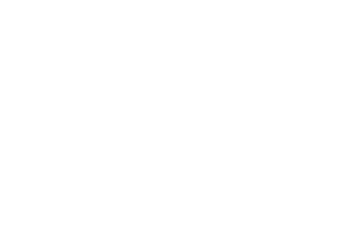

In [35]:
plt.axis('off')
plt.imshow(data_augmentation(X)[5].numpy().astype("uint8"))

Train the model using data augmentation and a dropout layer

In [29]:
num_classes = 8

model = Sequential([
  data_augmentation,
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model.fit(X_train_scaled, y_train, epochs=30)
print(model.summary())

Epoch 1/30


2022-11-24 13:56:12.832982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


11/11 [==============================] - 6s 416ms/step - loss: 2.2571 - accuracy: 0.1455
Epoch 2/30
11/11 [==============================] - 4s 346ms/step - loss: 2.0732 - accuracy: 0.1667
Epoch 3/30
11/11 [==============================] - 4s 334ms/step - loss: 2.0583 - accuracy: 0.1758
Epoch 4/30
11/11 [==============================] - 4s 332ms/step - loss: 2.0693 - accuracy: 0.1636
Epoch 5/30
11/11 [==============================] - 4s 337ms/step - loss: 2.0665 - accuracy: 0.1970
Epoch 6/30
11/11 [==============================] - 4s 333ms/step - loss: 2.0574 - accuracy: 0.1939
Epoch 7/30
11/11 [==============================] - 4s 332ms/step - loss: 2.0491 - accuracy: 0.1939
Epoch 8/30
11/11 [==============================] - 4s 342ms/step - loss: 2.0493 - accuracy: 0.1939
Epoch 9/30
11/11 [==============================] - 4s 351ms/step - loss: 2.0484 - accuracy: 0.1939
Epoch 10/30
11/11 [==============================] - 4s 333ms/step - loss: 2.0470 - accuracy: 0.1939
Epoch 11/3

In [30]:
model.evaluate(X_test_scaled,y_test)

1/4 [======>.......................] - ETA: 0s - loss: 1.7550 - accuracy: 0.3125

2022-11-24 13:58:10.384195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 50ms/step - loss: 1.8400 - accuracy: 0.2973


[1.8400441408157349, 0.29729729890823364]

In [31]:
predictions = model.predict(X_test_scaled)
predictions

1/4 [======>.......................] - ETA: 0s

2022-11-24 13:58:12.843195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 0s 38ms/step


array([[ 2.16337945e-02, -6.17284894e-01,  1.25409767e-01,
         1.42215099e-03,  4.83835876e-01,  4.41177905e-01,
         1.20303571e+00,  9.73467410e-01],
       [-4.23224866e-01,  1.38915375e-01,  5.89416027e-01,
         6.21784985e-01,  7.67947197e-01,  1.61535513e+00,
        -6.32443666e-01,  1.43889713e+00],
       [-3.70923191e-01,  1.25480190e-01,  6.34845078e-01,
         6.20894551e-01,  7.50983357e-01,  1.62833071e+00,
        -7.05892444e-01,  1.43412662e+00],
       [-2.21425563e-01, -6.81590289e-02,  4.92233872e-01,
         5.10274053e-01,  6.93981290e-01,  1.43679810e+00,
        -3.01517278e-01,  1.49899185e+00],
       [-3.95186335e-01,  2.23456815e-01,  6.20218515e-01,
         7.46881783e-01,  8.56349051e-01,  1.77451980e+00,
        -7.77372539e-01,  1.53398991e+00],
       [-6.61063850e-01,  3.71285319e-01,  7.22235143e-01,
         9.01484251e-01,  1.06876314e+00,  2.10421705e+00,
        -9.89519060e-01,  1.72871852e+00],
       [ 6.69097826e-02, -5.464613

In [32]:
score = tf.nn.softmax(predictions[0])

In [33]:
np.argmax(score)

6

In [34]:
y_test[0]

6

In [39]:
test_im = Path("../input/defect-detection/Blurry/X15Y2_1.bmp")
#test_im2 = Path("../input/defect-detection/negative/X1Y92_9858_15.bmp")
#image_path = tf.keras.utils.get_file('test_image', origin=test_im)
img = tf.keras.preprocessing.image.load_img(
    test_im, target_size=(180,180)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(y_test[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 36ms/step
This image most likely belongs to 7 with a 94.91 percent confidence.
